In [10]:
# load a coffea file
from coffea.util import load
import copy
import os
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import matplotlib
from hist import Hist
from coffea.processor.accumulator import column_accumulator
from collections import defaultdict
matplotlib.rcParams["figure.dpi"] = 300

# Util functions

In [11]:
def normalize_era_name(name):
    if "DATA_JetMET_JMENano" in name and "2022_postEE" in name:
        return "DATA_JetMET_JMENano_2022_postEE"
    elif "DATA_JetMET_JMENano" in name and "skimmed" in name:
        return "DATA_JetMET_JMENano"
    return name

def normalize_keys(d):
    if isinstance(d, dict):
        return {
            normalize_era_name(k): normalize_keys(v)
            for k, v in d.items()
        }
    return d

def merge_accumulators(accumulators):
    """
    Recursively merge a list of accumulator dictionaries.
    
    Supports:
    - hist.Hist objects (added together)
    - Nested dictionaries (merged recursively)
    - Numeric types (summed)
    """
    def recursive_merge(a, b):
        if isinstance(a, (dict, defaultdict)) and isinstance(b, (dict, defaultdict)):
            merged = copy.deepcopy(a)
            for key in b:
                if key in merged.keys():
                    merged[key] = recursive_merge(merged[key], b[key])
                else:
                    merged[key] = copy.deepcopy(b[key])
            return merged

        elif isinstance(a, Hist) and isinstance(b, Hist):
            a_copy = copy.deepcopy(a)
            a_copy.add(b)
            return a_copy
        
        elif isinstance(a, column_accumulator) and isinstance(b, column_accumulator):
            return a + b

        elif isinstance(a, (int, float, np.int64, str)) and isinstance(b, (int, float, np.int64, str)):
            return a + b

        elif isinstance(a, set) and isinstance(b, set):
            return a.union(b)
        

        else:
            raise TypeError(f"Cannot merge types: {type(a)} and {type(b)}")

    # Start with a deep copy of the first accumulator
    merged = copy.deepcopy(accumulators[0])
    merged = normalize_keys(merged)

    # Merge all others
    for acc in accumulators[1:]:
        acc = normalize_keys(acc)
        merged = recursive_merge(merged, acc)

    return merged

In [12]:
def compute_significance(s, b):
    """Compute S/sqrt(B), but return 0 where B == 0."""
    significance = np.zeros_like(s)
    nonzero = b > 0
    significance[nonzero] = s[nonzero] / np.sqrt(b[nonzero])
    return significance

def total_significance(bin_edges, sig_vals, sig_weights, bkg_vals):
    sig_hist, _ = np.histogram(sig_vals, bins=bin_edges, weights=sig_weights)
    bkg_hist, _ = np.histogram(bkg_vals, bins=bin_edges)
    return np.sqrt(np.sum(compute_significance(sig_hist, bkg_hist)**2))

def optimize_bin_edges(n_bins, adp_m, weights_m, adp_d, n_scan=100):
    """
    Optimize bin edges to maximize sum of S/sqrt(B), with significance=0 if B=0.

    Parameters:
    - n_bins: Number of desired bins
    - adp_m: Signal variable values
    - weights_m: Signal weights
    - adp_d: Background variable values (unweighted)
    - n_scan: Number of candidate splits to test in each bin

    Returns:
    - np.ndarray of optimal bin edges
    """
    min_val = min(np.min(adp_m), np.min(adp_d))
    max_val = max(np.max(adp_m), np.max(adp_d))
    
    min_val=-1
    max_val=10
    initial_edges = [min_val, max_val]

    for _ in range(n_bins - 1):  # Already 1 bin, need n_bins - 1 new edges
        best_score = -np.inf
        best_edge = None
        current_edges = np.sort(initial_edges)

        candidate_edges = []
        for i in range(len(current_edges) - 1):
            left, right = current_edges[i], current_edges[i + 1]
            scan_points = np.linspace(left, right, n_scan + 2)[1:-1]  # exclude edges
            candidate_edges.extend(scan_points)

        for edge in candidate_edges:
            new_edges = np.sort(initial_edges + [edge])
            score = total_significance(new_edges, adp_m, weights_m, adp_d)
            if score > best_score:
                best_score = score
                best_edge = edge

        if best_edge is not None:
            initial_edges.append(best_edge)
        else:
            break

    return np.sort(initial_edges), best_score


In [43]:

def plot_distribution(adp_d, adp_m, adp_d2, weights_m, weights_d2, title, category_4, category_2, bins, tanh=False, preW_ratio=True):    
    print(len(adp_d))
    if isinstance(weights_m, type(None)):
        weights_m = np.zeros_like(adp_m)
    if isinstance(weights_d2, type(None)):
        weights_d2 = np.zeros_like(adp_d2)
    
    if tanh:
        adp_d = np.tanh(adp_d)
        adp_m = np.tanh(adp_m)
        adp_d2 = np.tanh(adp_d2)

    # plot the columns histograms
    # plot aloso the ratio 
    fig, (ax, ax_ratio) = plt.subplots(2, 1, figsize=(10, 6), height_ratios=[3, 1], sharex=True)
    ax.hist(adp_d, bins=bins, histtype='step', label=f'Data {category_4}', color='blue', alpha=0.7, density=True)
    ax.hist(adp_m, bins=bins, weights=weights_m, histtype='step', label=f'HH4b {category_4}', color='red', alpha=0.7, density=True)
    ax.hist(adp_d2, bins=bins, histtype='step', label=f'Data {category_2.rsplit("_",1)[0]}', color='green', alpha=0.7, density=True)
    if "postW" in category_2:
        ax.hist(adp_d2, bins=bins, weights=weights_d2, histtype='step', label=f'Data {category_2.rsplit("_",1)[0]} reweighted', color='yellow', alpha=0.7, density=True)
    if tanh:
        ax.set_title(f'Delta pairing probabilities distribution for {title}')
    else:
        ax.set_title(f'Arctanh Delta pairing probabilities distribution for {title}')
    # ax.set_xlabel('Arctanh Delta pairing probabilities')
    ax.set_ylabel('Number of events')
    # log scale
    ax.legend()
    ax.set_yscale('log')
    plt.grid()
    plt.tight_layout()
    
    # plot the ratio d and d2
    # get the histogram
    hist_d, edges_d = np.histogram(adp_d, bins=bins, density=True)
    hist_m, edges_m = np.histogram(adp_m, bins=bins, density=True, weights=weights_m)
    hist_d2, edges_d2 = np.histogram(adp_d2, bins=bins, density=True)
    if "postW" in category_2:
        hist_d2_rw, edges_d2_rw = np.histogram(adp_d2, bins=bins, density=True, weights=weights_d2)
        
    # compute the bin centers
    bin_centers_d = 0.5 * (edges_d[:-1] + edges_d[1:])
    ratio_d = hist_d / hist_m
    ratio_d2 = hist_d / hist_d2
    if "postW" in category_2:
        ratio_d2_rw = hist_d / hist_d2_rw
    
    # plot the ratio
    # ax_ratio.plot(bin_centers_d, ratio_d, label='Data 4b / Signal 4b', color='blue')
    if "postW" not in category_2 and preW_ratio:
        ax_ratio.plot(bin_centers_d, ratio_d2, label='Data 4b / Data 2b', color='green')
    else:
        ax_ratio.plot(bin_centers_d, ratio_d2_rw, label='Data 4b / Data 2b reweighted', color='yellow')
    if tanh:
        ax_ratio.set_xlabel('Delta pairing probabilities')
    else:
        ax_ratio.set_xlabel('Arctanh Delta pairing probabilities')
    ax_ratio.set_ylabel('Ratio')
    ax_ratio.axhline(1, color='black', linestyle='--', label='Ratio = 1')
    ax_ratio.legend()
    ax_ratio.grid()
    ax_ratio.legend()
    plt.tight_layout()
    plt.show()
    
    

def get_cols(input_data, input_mc, category_4, category_2, arctanh=True, filter_dnn_score=False):
    if len(input_data)>1:
        input_data = [load(file) for file in input_data]
        o_d = merge_accumulators(input_data)
    elif isinstance(input_data, list):
        o_d = load(input_data[0])
    sample_d=list(o_d["columns"].keys())[0]
    dataset_d=list(o_d["columns"][sample_d].keys())[0]
    
    if len(input_mc)>1:
        input_mc = [load(file) for file in input_mc]
        o_m = merge_accumulators(input_mc)
    elif isinstance(input_mc, list):
        o_m = load(input_mc[0])
    sample_m=list(o_m["columns"].keys())[0]
    dataset_m=list(o_m["columns"][sample_m].keys())[0]


    print(f"Data: {sample_d} {dataset_d}")
    print(f"MC: {sample_m} {dataset_m}")
    col_d = o_d["columns"][sample_d][dataset_d][category_4]
    col_m = o_m["columns"][sample_m][dataset_m][category_4]

    
    col_d2 = o_d["columns"][sample_d][dataset_d][category_2]
    # Define a mask only if we filter by dnn score. If not, this is a passthrough
    mask_d2 = np.ones_like(col_d2['weight'].value, dtype=bool) if not filter_dnn_score else col_d2['events_sig_bkg_dnn_score'].value > 0.9
    mask_d = np.ones_like(col_d['weight'].value, dtype=bool) if not filter_dnn_score else col_d['events_sig_bkg_dnn_score'].value > 0.9
    mask_m = np.ones_like(col_m['weight'].value, dtype=bool) if not filter_dnn_score else col_m['events_sig_bkg_dnn_score'].value > 0.9
    if arctanh:
        column = "events_Arctanh_Delta_pairing_probabilities"
    else:
        column = "events_Delta_pairing_probabilities"
    # mask only relevant if filter by dnn score, else passthrough
    adp_d=col_d[column].value[mask_d]
    adp_m=col_m[column].value[mask_m]
    adp_d2=col_d2[column].value[mask_d2]
    weights_m=col_m["weight"].value[mask_m]
    weights_d2=col_d2["weight"].value[mask_d2]
    
    

    return adp_d, adp_m, adp_d2, weights_m, weights_d2



# SPANet models inclusive b-region reweight analysis

## b-ratio with PD input for reweighting

Data: DATA_JetMET_JMENano DATA_JetMET_JMENano_2022_postEE
MC: GluGlutoHHto4B_spanet GluGlutoHHto4B_spanet_kl-1p00_kt-1p00_c2-0p00_2022_postEE
[10.3087024 10.3087024 10.3087024 ... 10.3087024 10.3087024 10.3087024]
84357


/tmp/ipykernel_1386628/2355170080.py:43: RuntimeWarning: invalid value encountered in divide
  ratio_d = hist_d / hist_m
/tmp/ipykernel_1386628/2355170080.py:44: RuntimeWarning: invalid value encountered in divide
  ratio_d2 = hist_d / hist_d2
/tmp/ipykernel_1386628/2355170080.py:46: RuntimeWarning: invalid value encountered in divide
  ratio_d2_rw = hist_d / hist_d2_rw


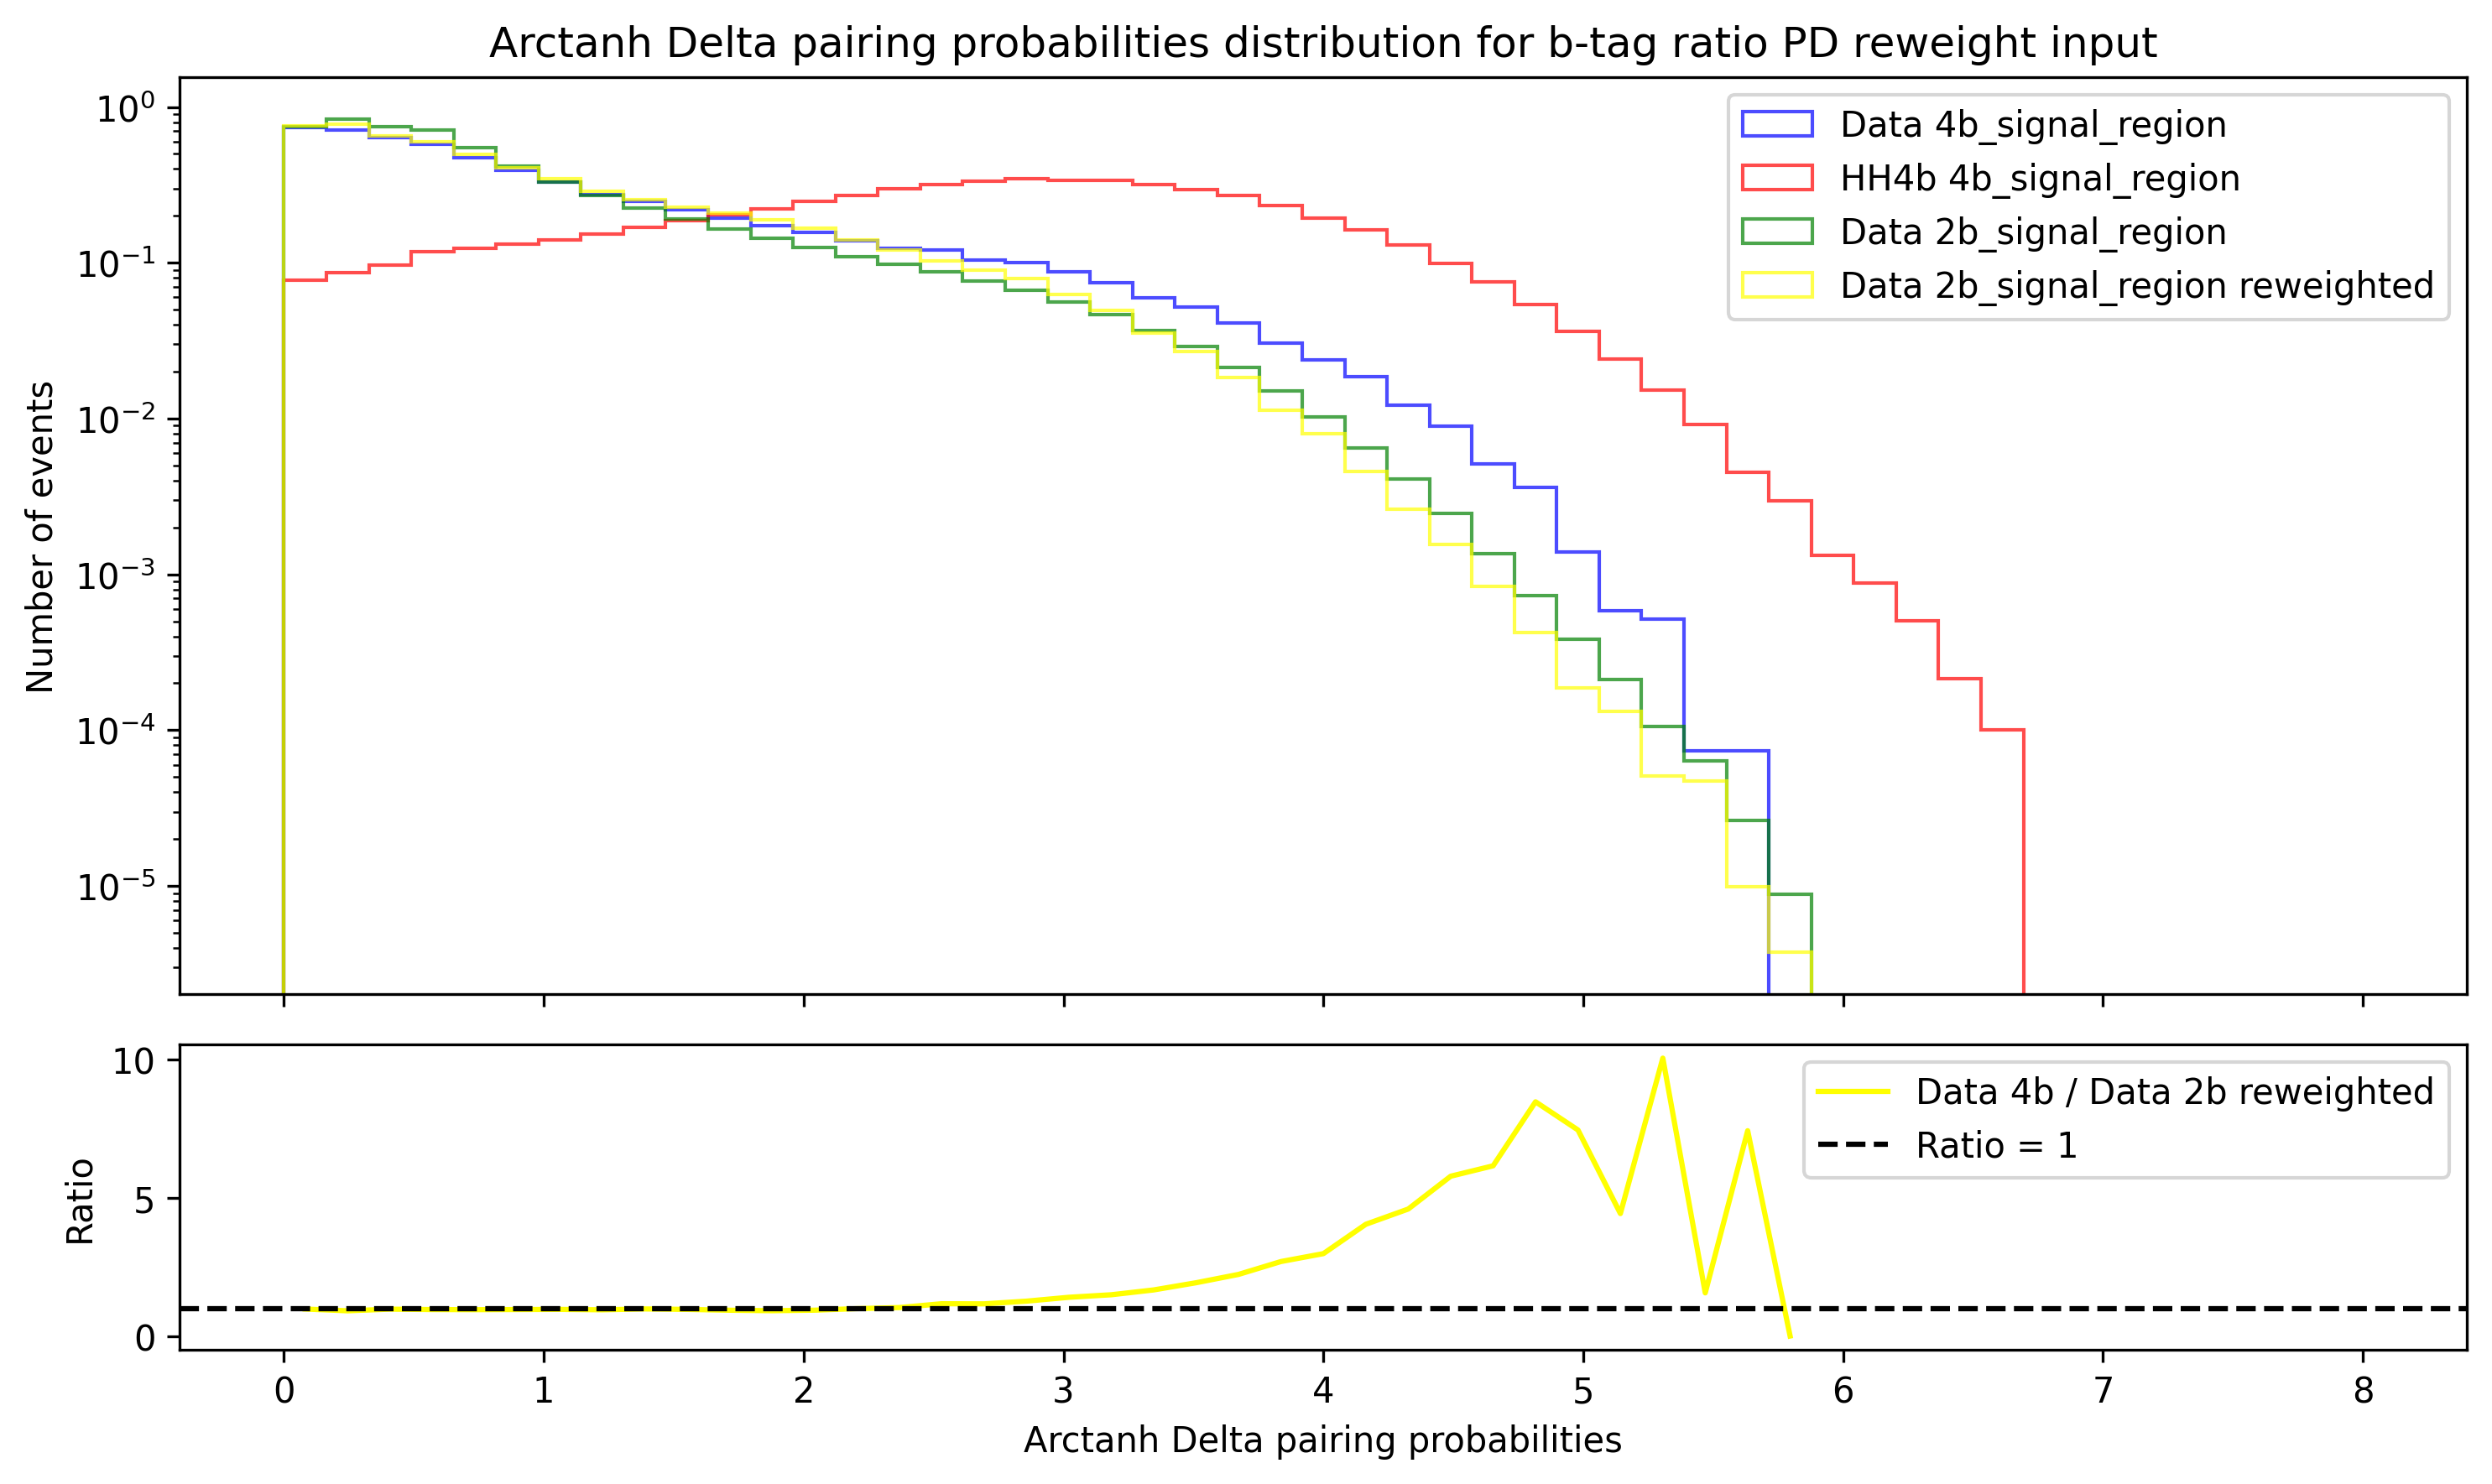

84357


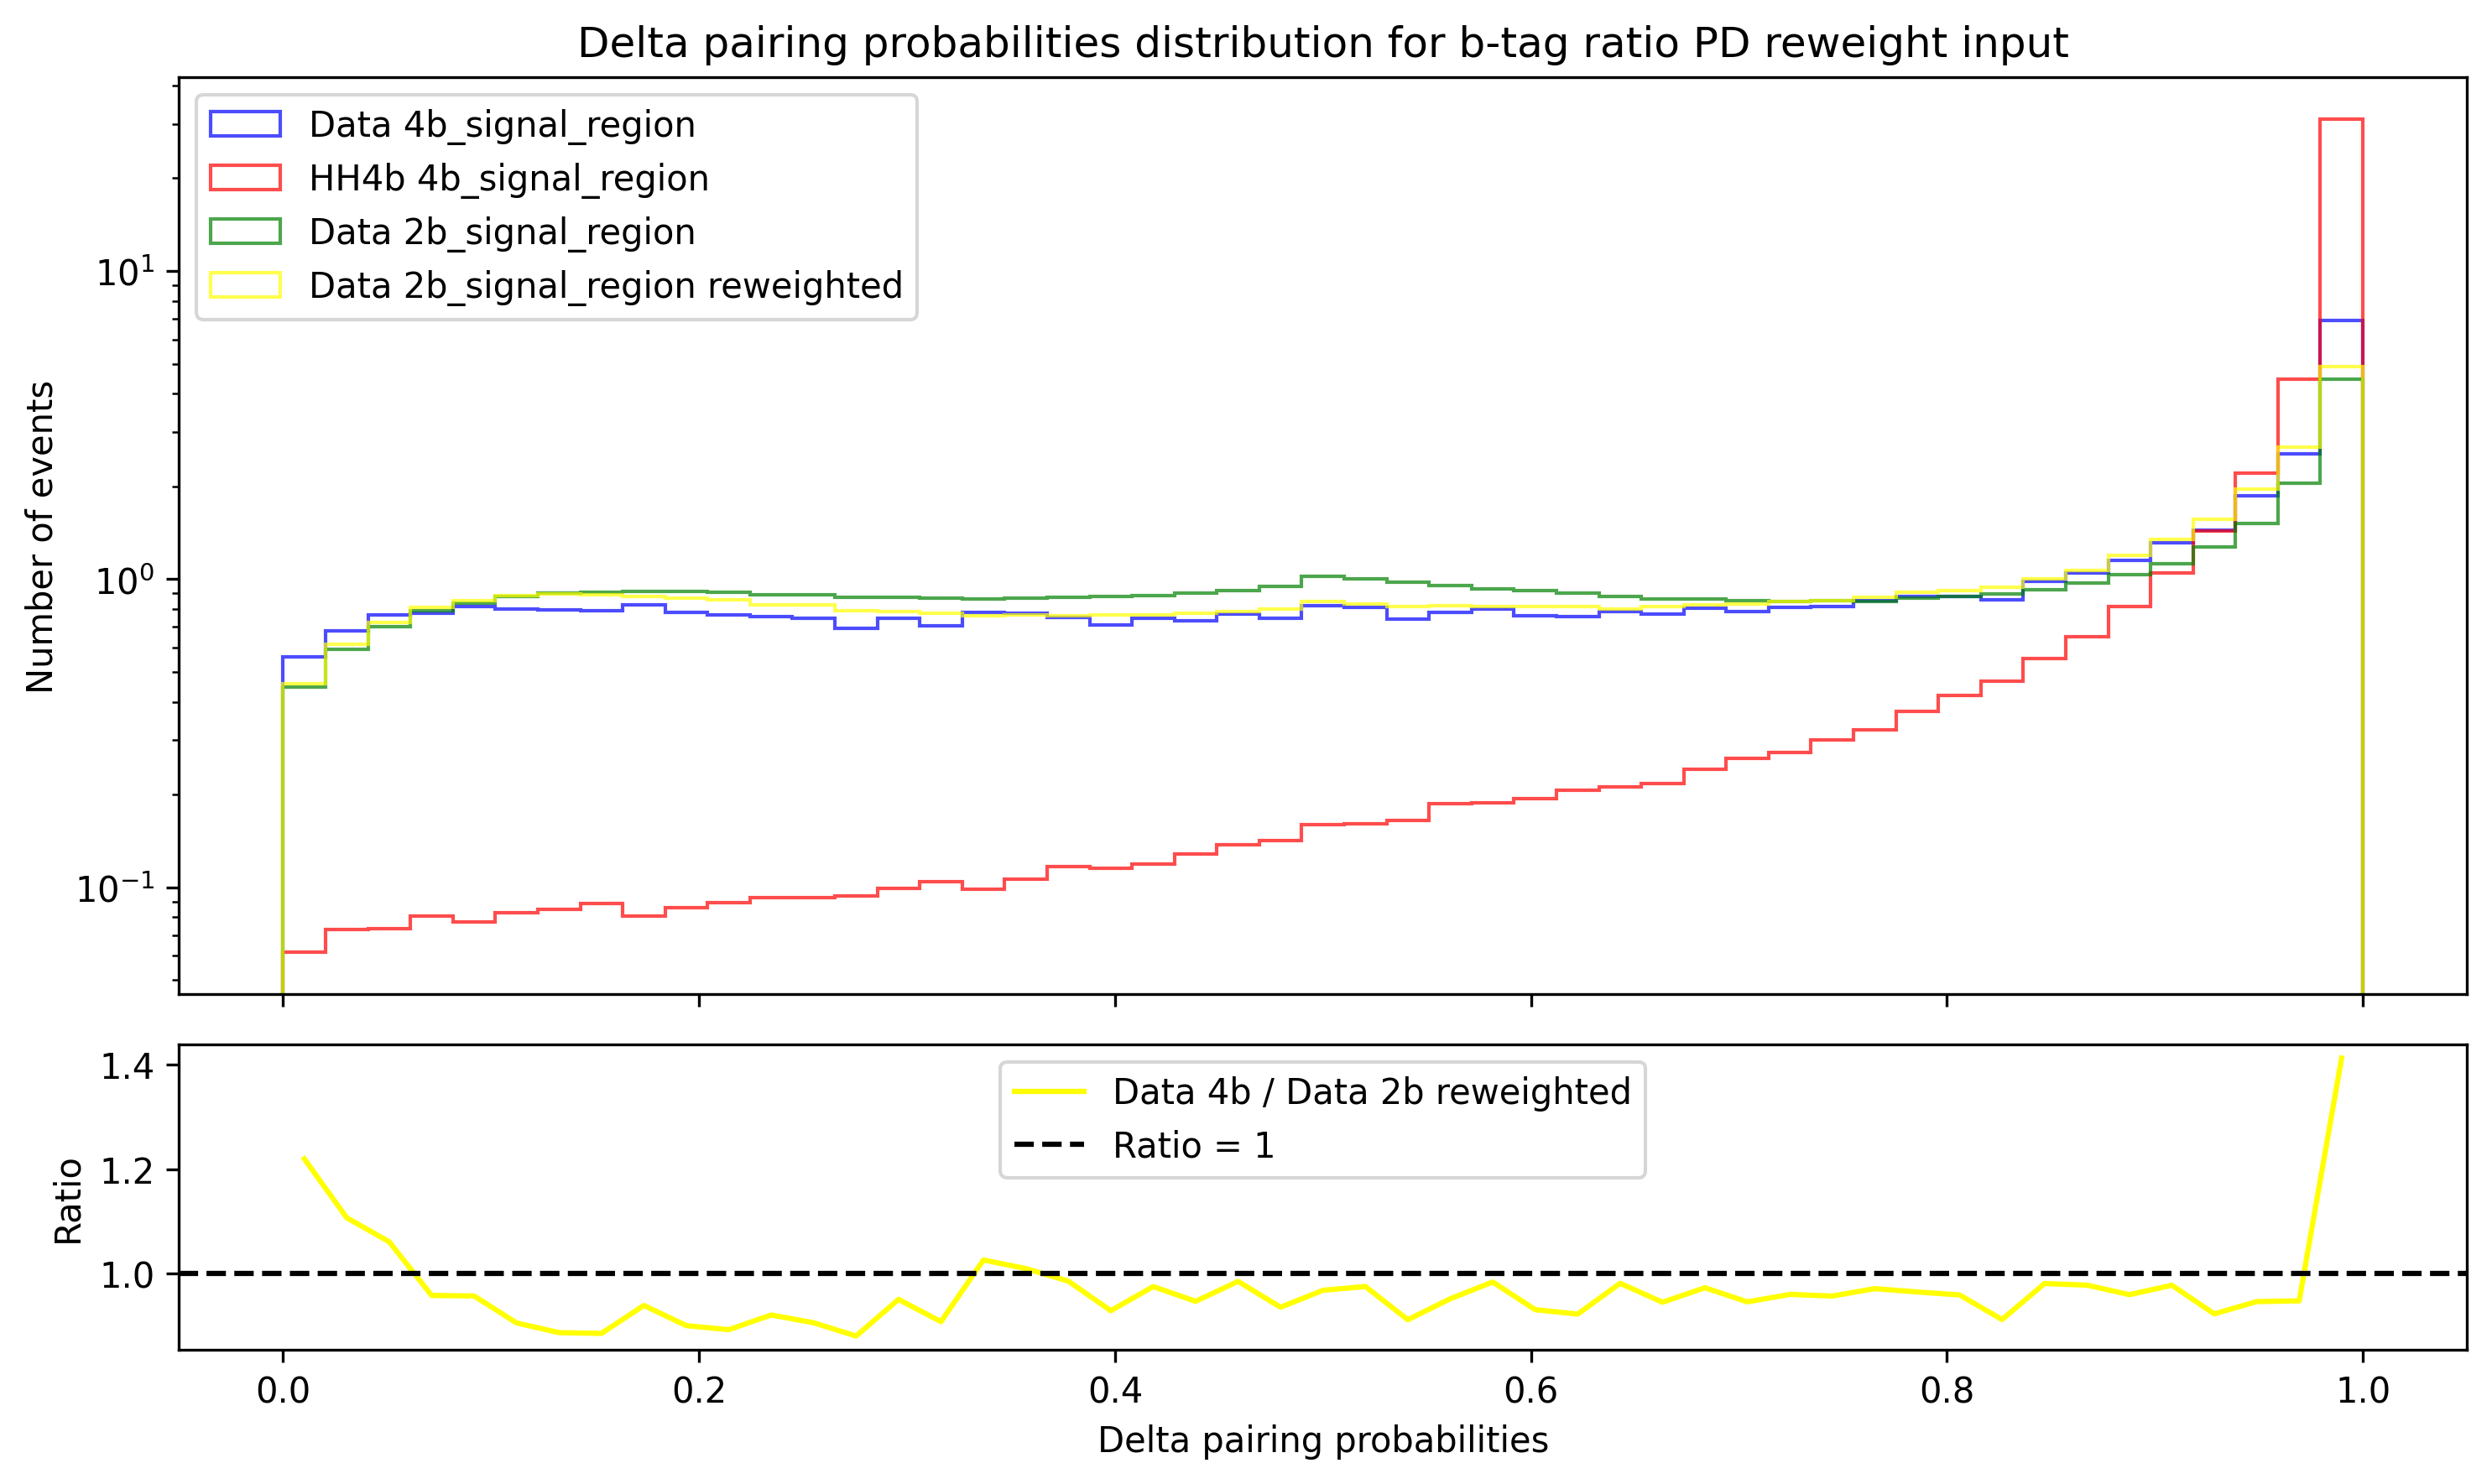

84357


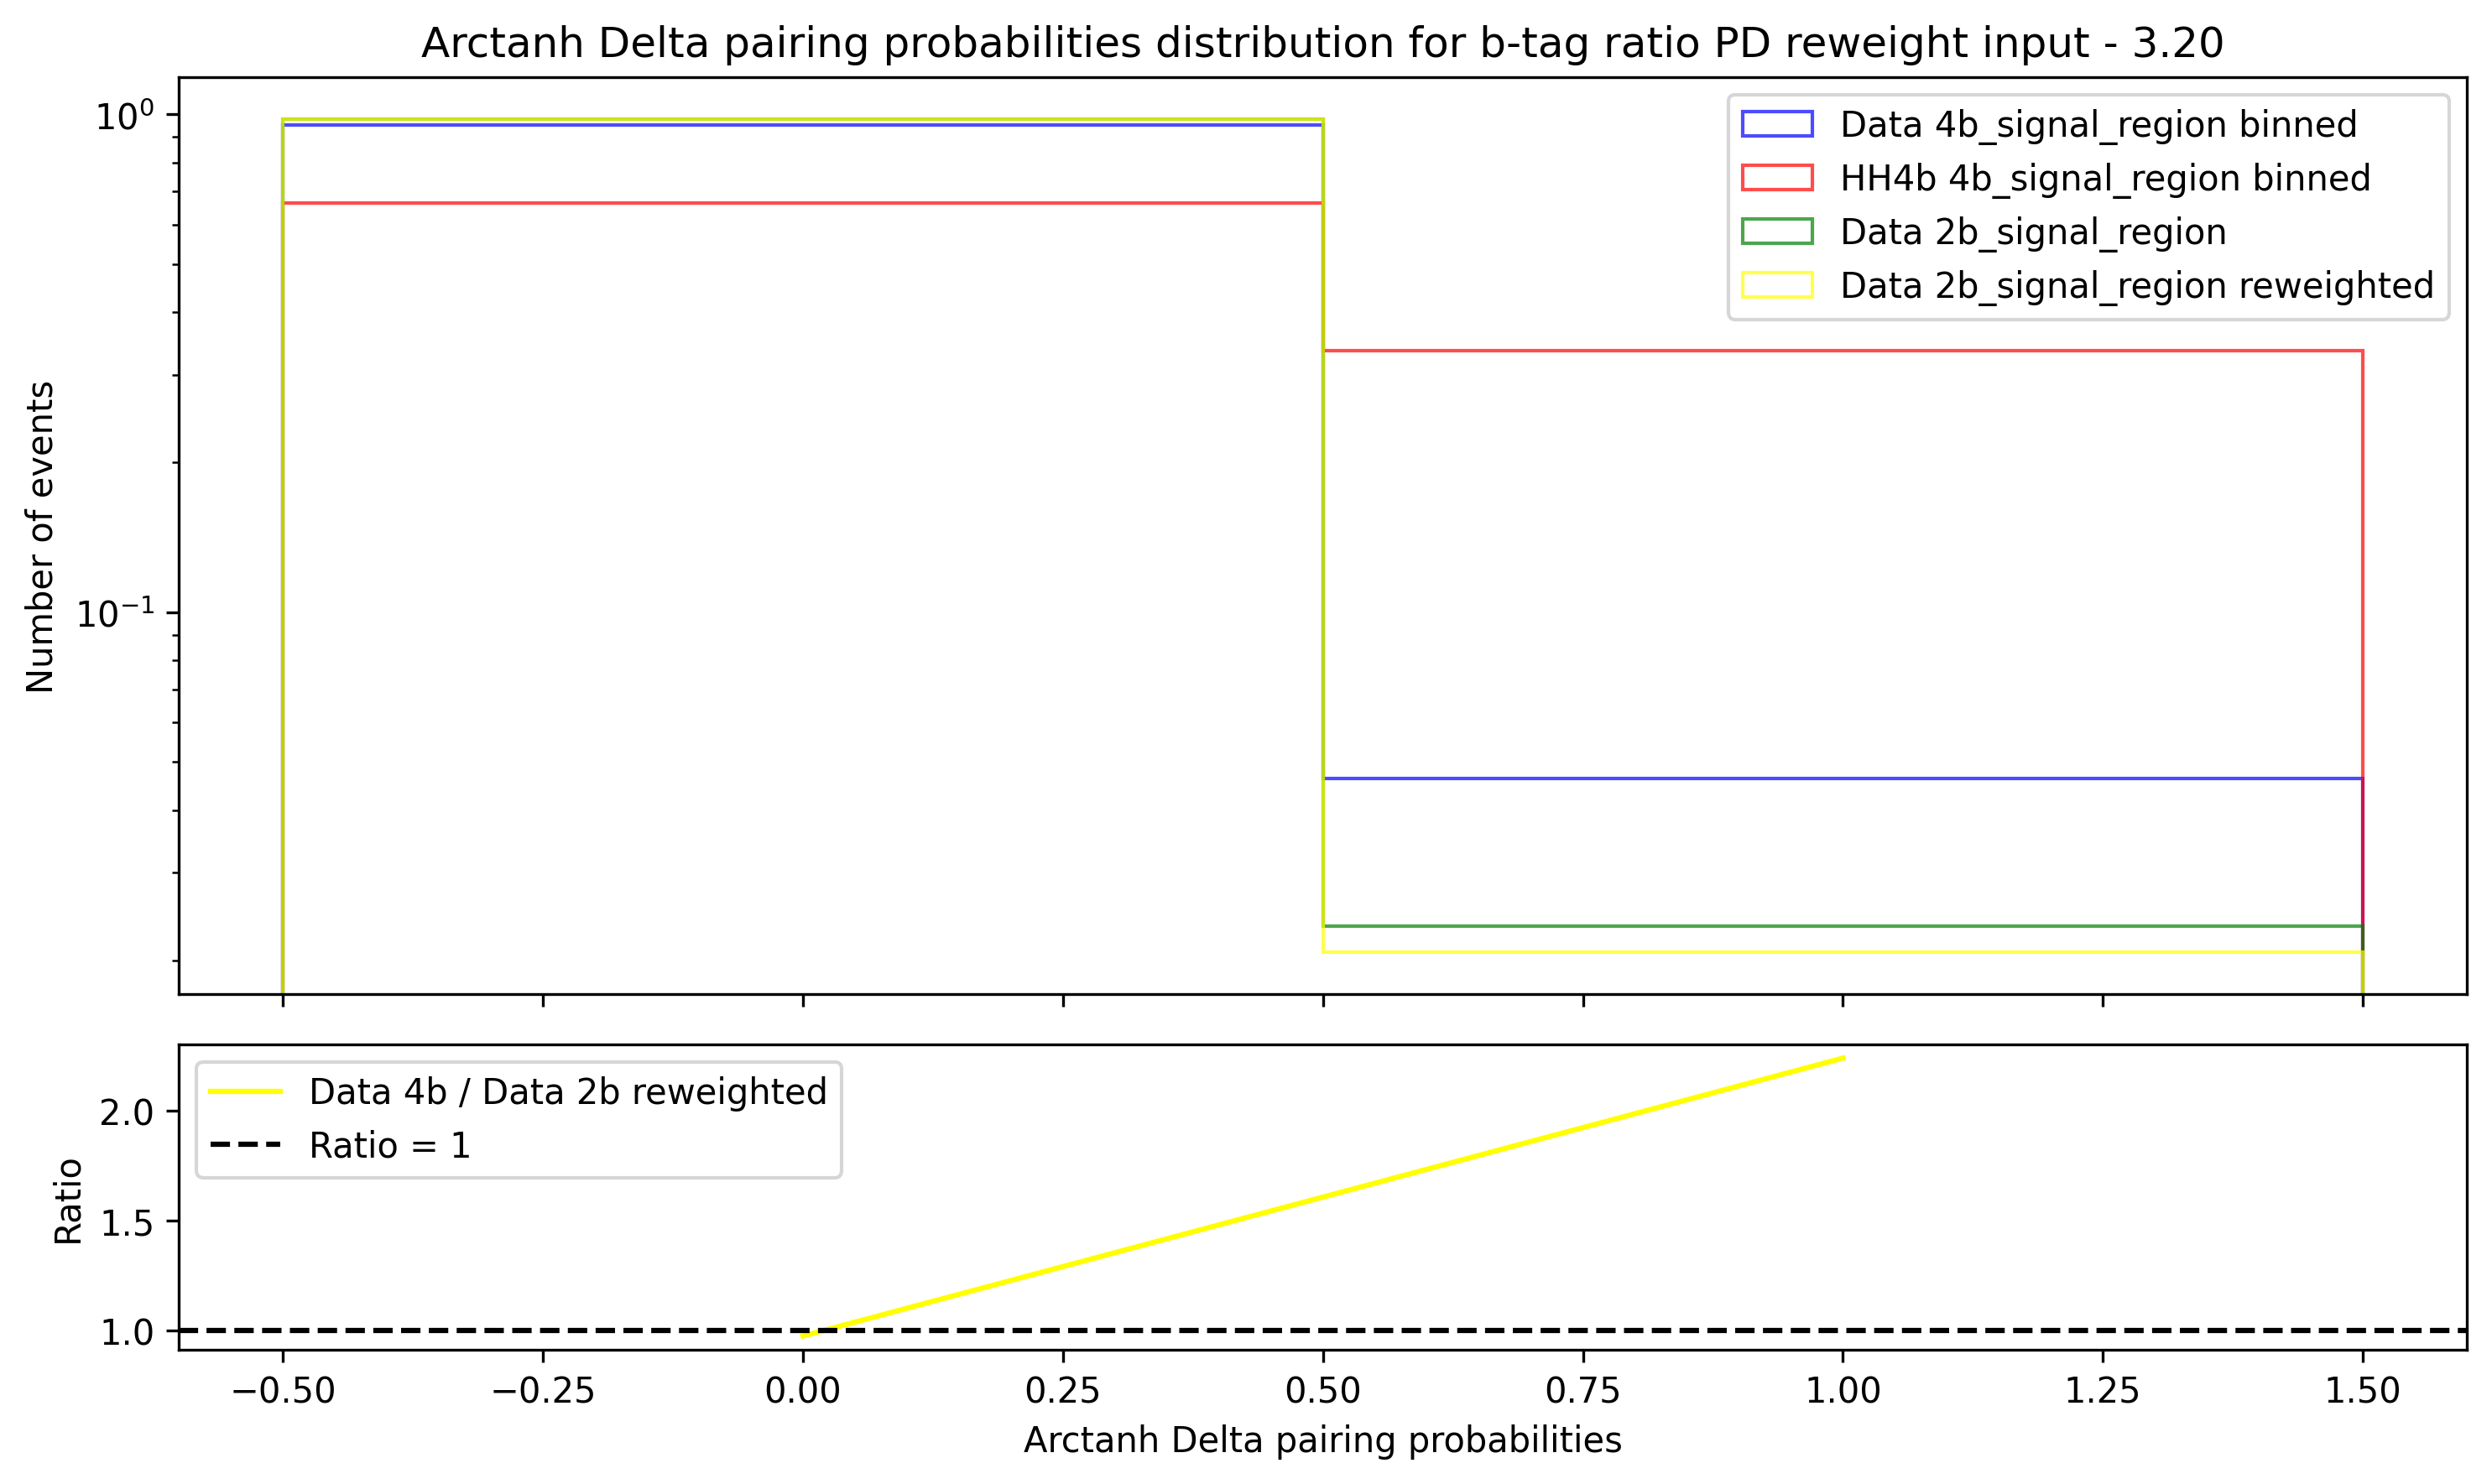

Data: DATA_JetMET_JMENano DATA_JetMET_JMENano_2022_postEE
MC: GluGlutoHHto4B_spanet GluGlutoHHto4B_spanet_kl-1p00_kt-1p00_c2-0p00_2022_postEE
[ 10.3087024  10.3087024 -10.3087024 ...  10.3087024  10.3087024
  10.3087024]
161633


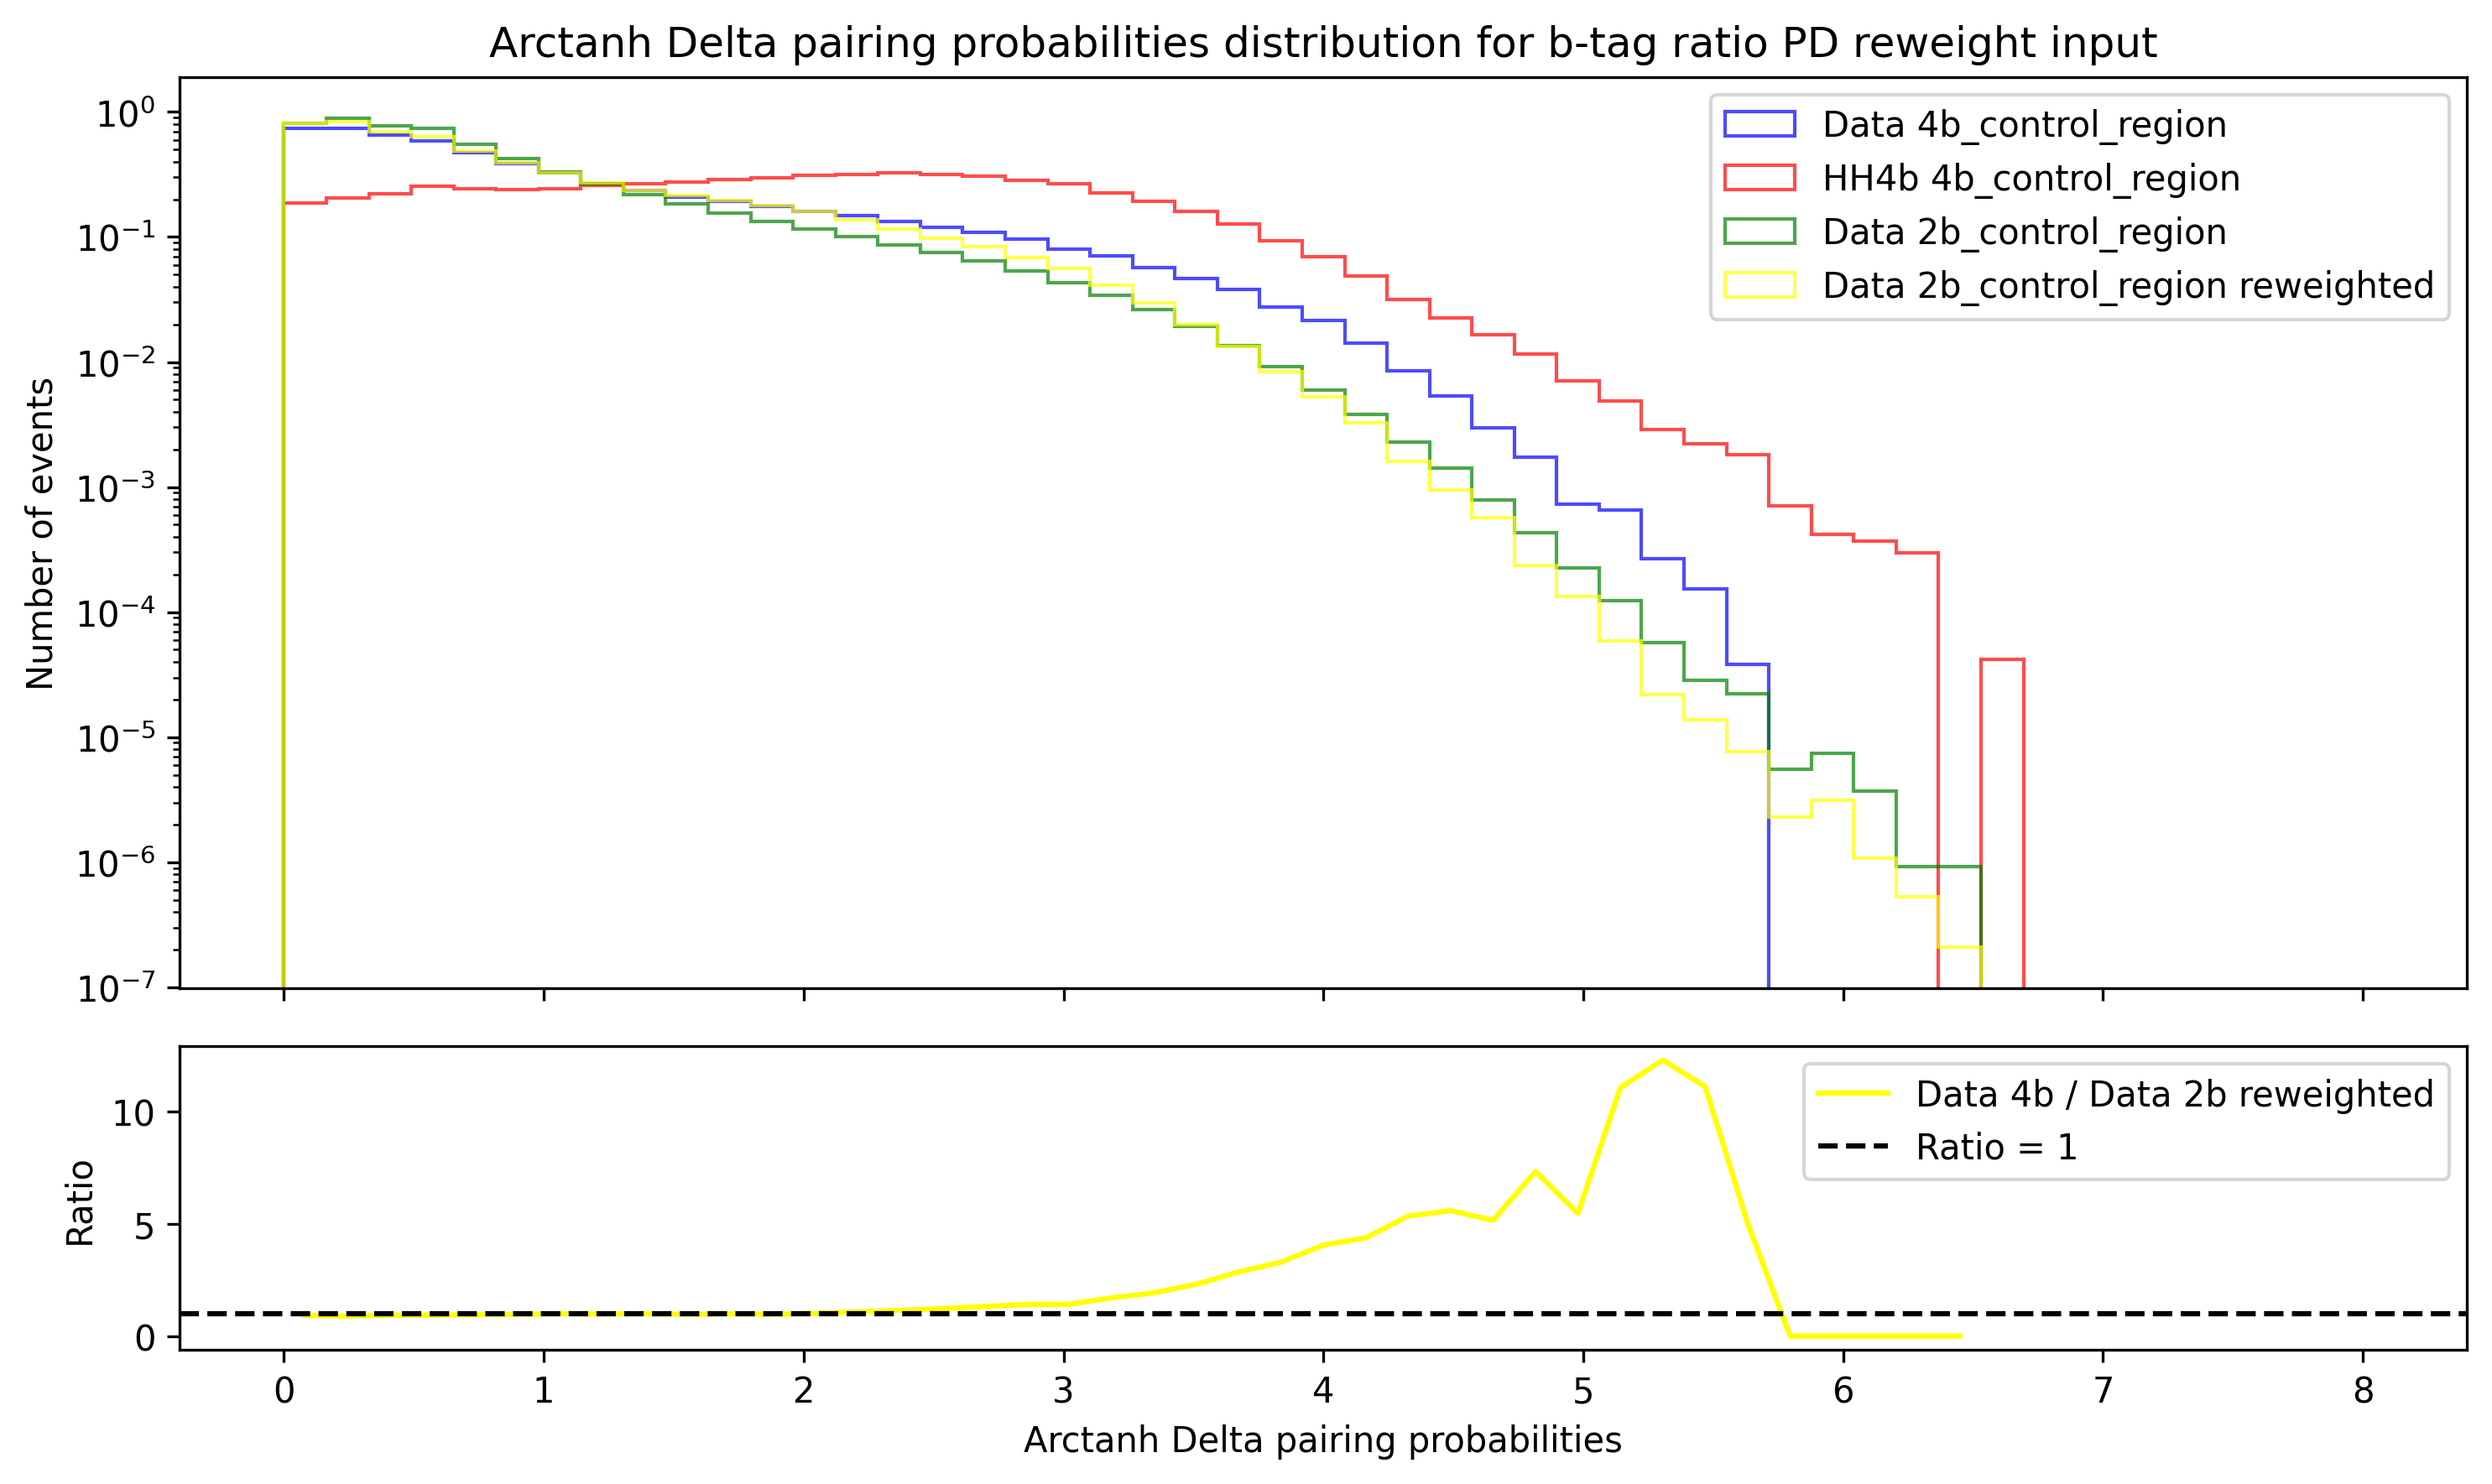

161633


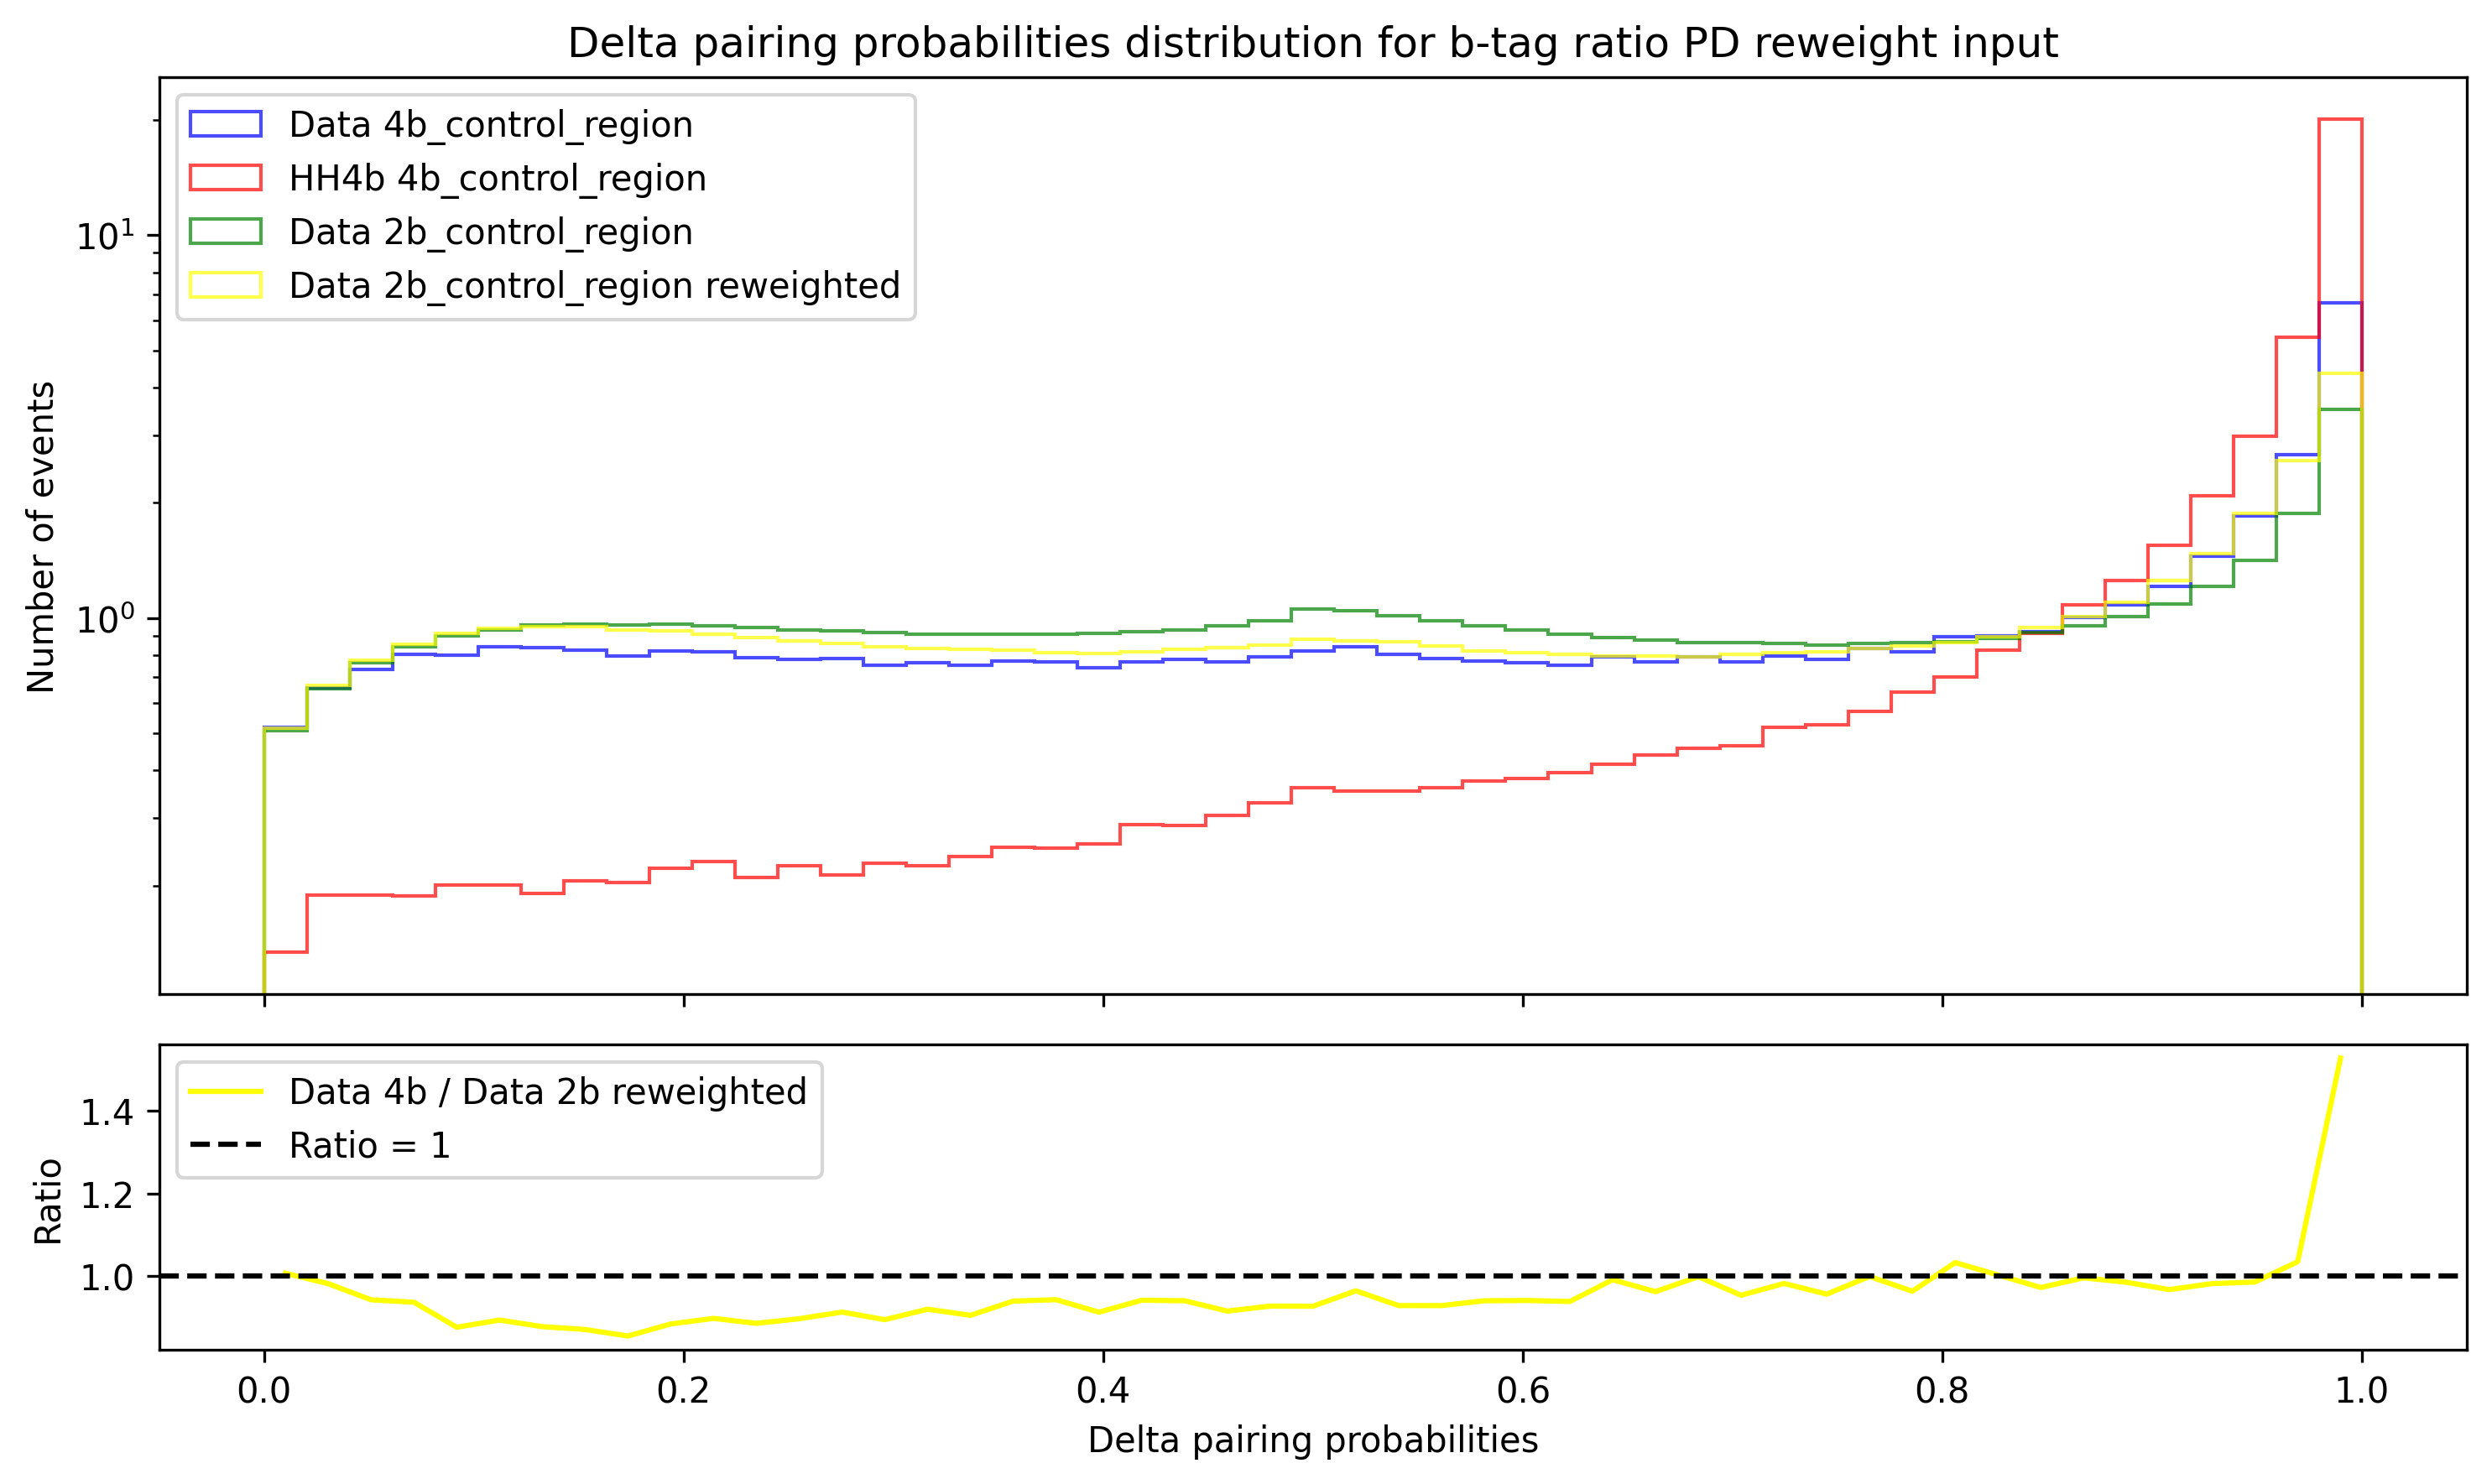

161633


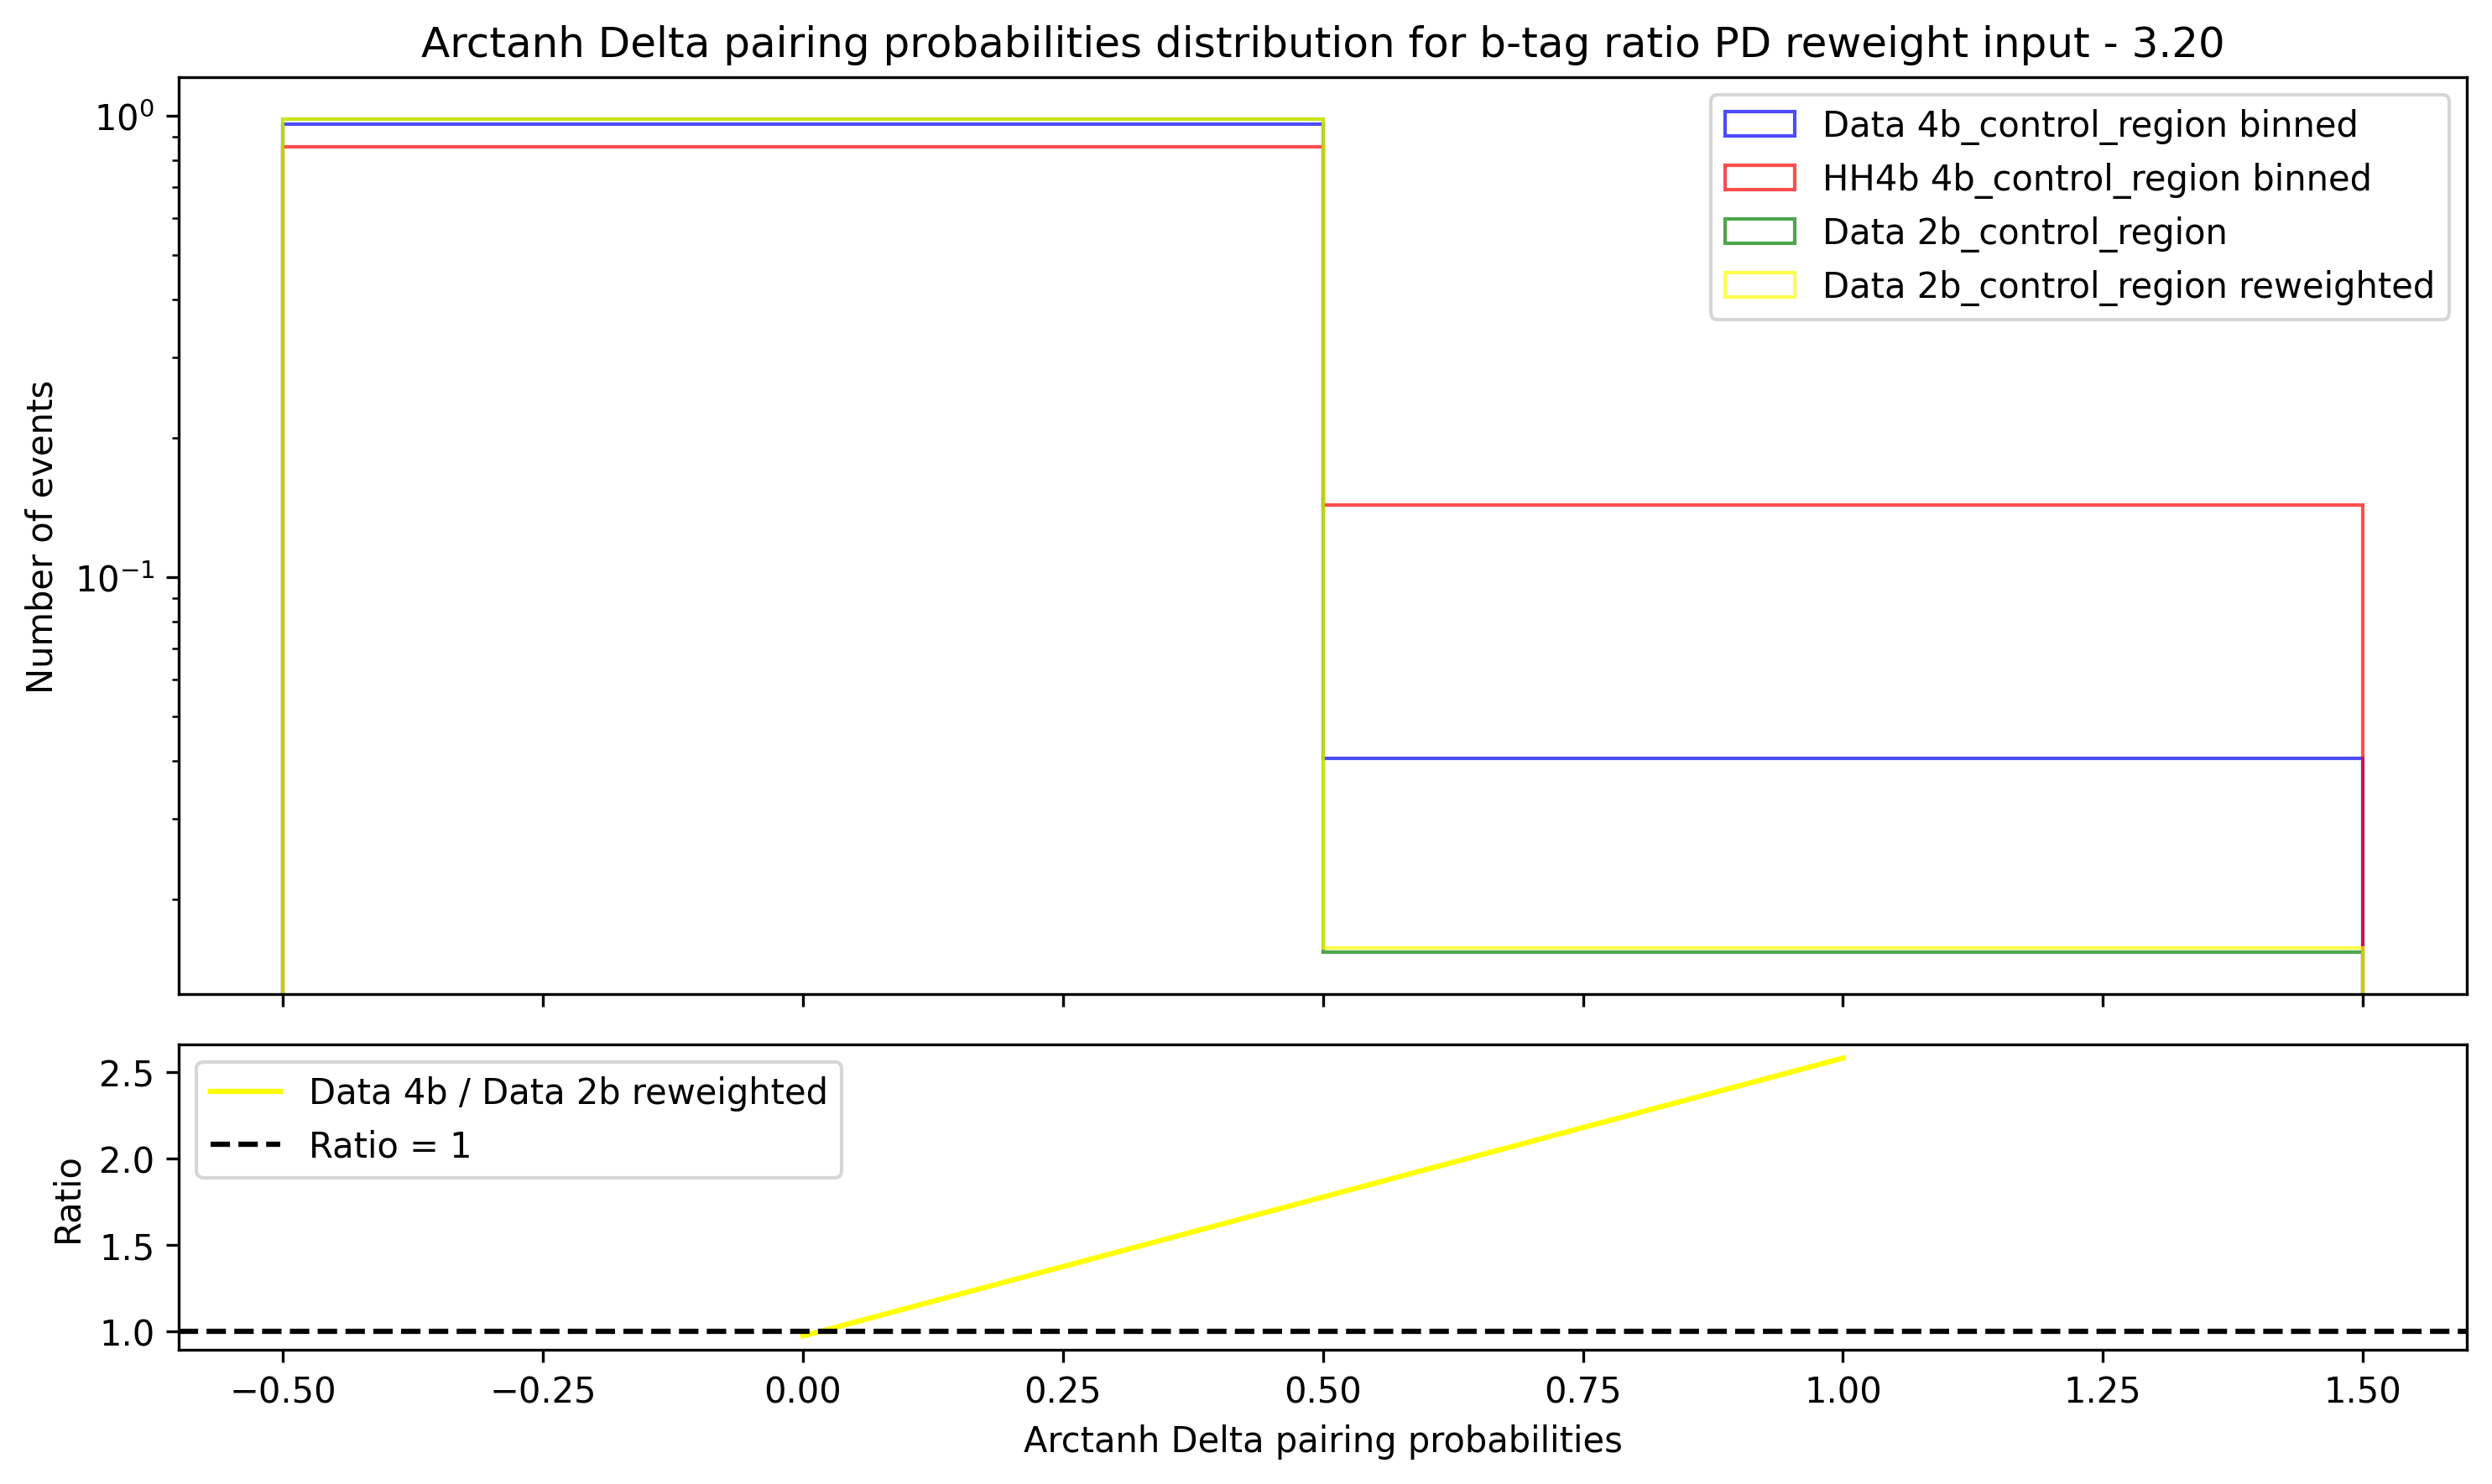

In [50]:
input_data = ["/work/tharte/datasets/sig_bkg_classifier/spanet_ptflat_inclusive_b_trained_bratio_DeltaProb/output_DATA_JetMET_JMENano_E_2022_postEE_EraE.coffea", "/work/tharte/datasets/sig_bkg_classifier/spanet_ptflat_inclusive_b_trained_bratio_DeltaProb/output_DATA_JetMET_JMENano_F_2022_postEE_EraF.coffea", "/work/tharte/datasets/sig_bkg_classifier/spanet_ptflat_inclusive_b_trained_bratio_DeltaProb/output_DATA_JetMET_JMENano_G_2022_postEE_EraG.coffea"]
input_mc = ["/work/tharte/datasets/sig_bkg_classifier/spanet_ptflat_inclusive_b_trained_bratio_ArctanhDeltaProb/output_GluGlutoHHto4B_spanet_kl-1p00_kt-1p00_c2-0p00_2022_postEE.coffea"]
title = "b-tag ratio PD reweight input"
edge = 3.2

for region in ["signal", "control"]:
    category_4 = f"4b_{region}_region"
    category_2 = f"2b_{region}_region_postW"
    
    # d=data, m=MC, d2=DHH
    adp_d, adp_m, adp_d2, weights_m, weights_d2 = get_cols(input_data, input_mc, category_4, category_2)
    print(weights_m)
    plot_distribution(adp_d, adp_m, adp_d2, weights_m, weights_d2, title, category_4, category_2,np.linspace(0, 8, 50))
    plot_distribution(adp_d, adp_m, adp_d2, weights_m, weights_d2, title, category_4, category_2,np.linspace(0, 1, 50), tanh=True)
    
    arctanh_delta_prob_bin_edges=[-0.2, edge, 20]
    bin_adp_d=np.digitize(adp_d, arctanh_delta_prob_bin_edges)-1
    bin_adp_m=np.digitize(adp_m, arctanh_delta_prob_bin_edges)-1
    bin_adp_d2=np.digitize(adp_d2, arctanh_delta_prob_bin_edges)-1
    
    plot_distribution(
        bin_adp_d, bin_adp_m, bin_adp_d2, weights_m, weights_d2, f"{title} - {edge:.2f}", category_4 + " binned", category_2 + " binned", [-0.5, 0.5, 1.5]
    )



Data: DATA_JetMET_JMENano DATA_JetMET_JMENano_2022_postEE
MC: GluGlutoHHto4B_spanet GluGlutoHHto4B_spanet_kl-1p00_kt-1p00_c2-0p00_2022_postEE
[10.3087024 10.3087024 10.3087024 ... 10.3087024 10.3087024 10.3087024]
2908


/tmp/ipykernel_1386628/2355170080.py:43: RuntimeWarning: invalid value encountered in divide
  ratio_d = hist_d / hist_m
/tmp/ipykernel_1386628/2355170080.py:44: RuntimeWarning: invalid value encountered in divide
  ratio_d2 = hist_d / hist_d2
/tmp/ipykernel_1386628/2355170080.py:46: RuntimeWarning: invalid value encountered in divide
  ratio_d2_rw = hist_d / hist_d2_rw


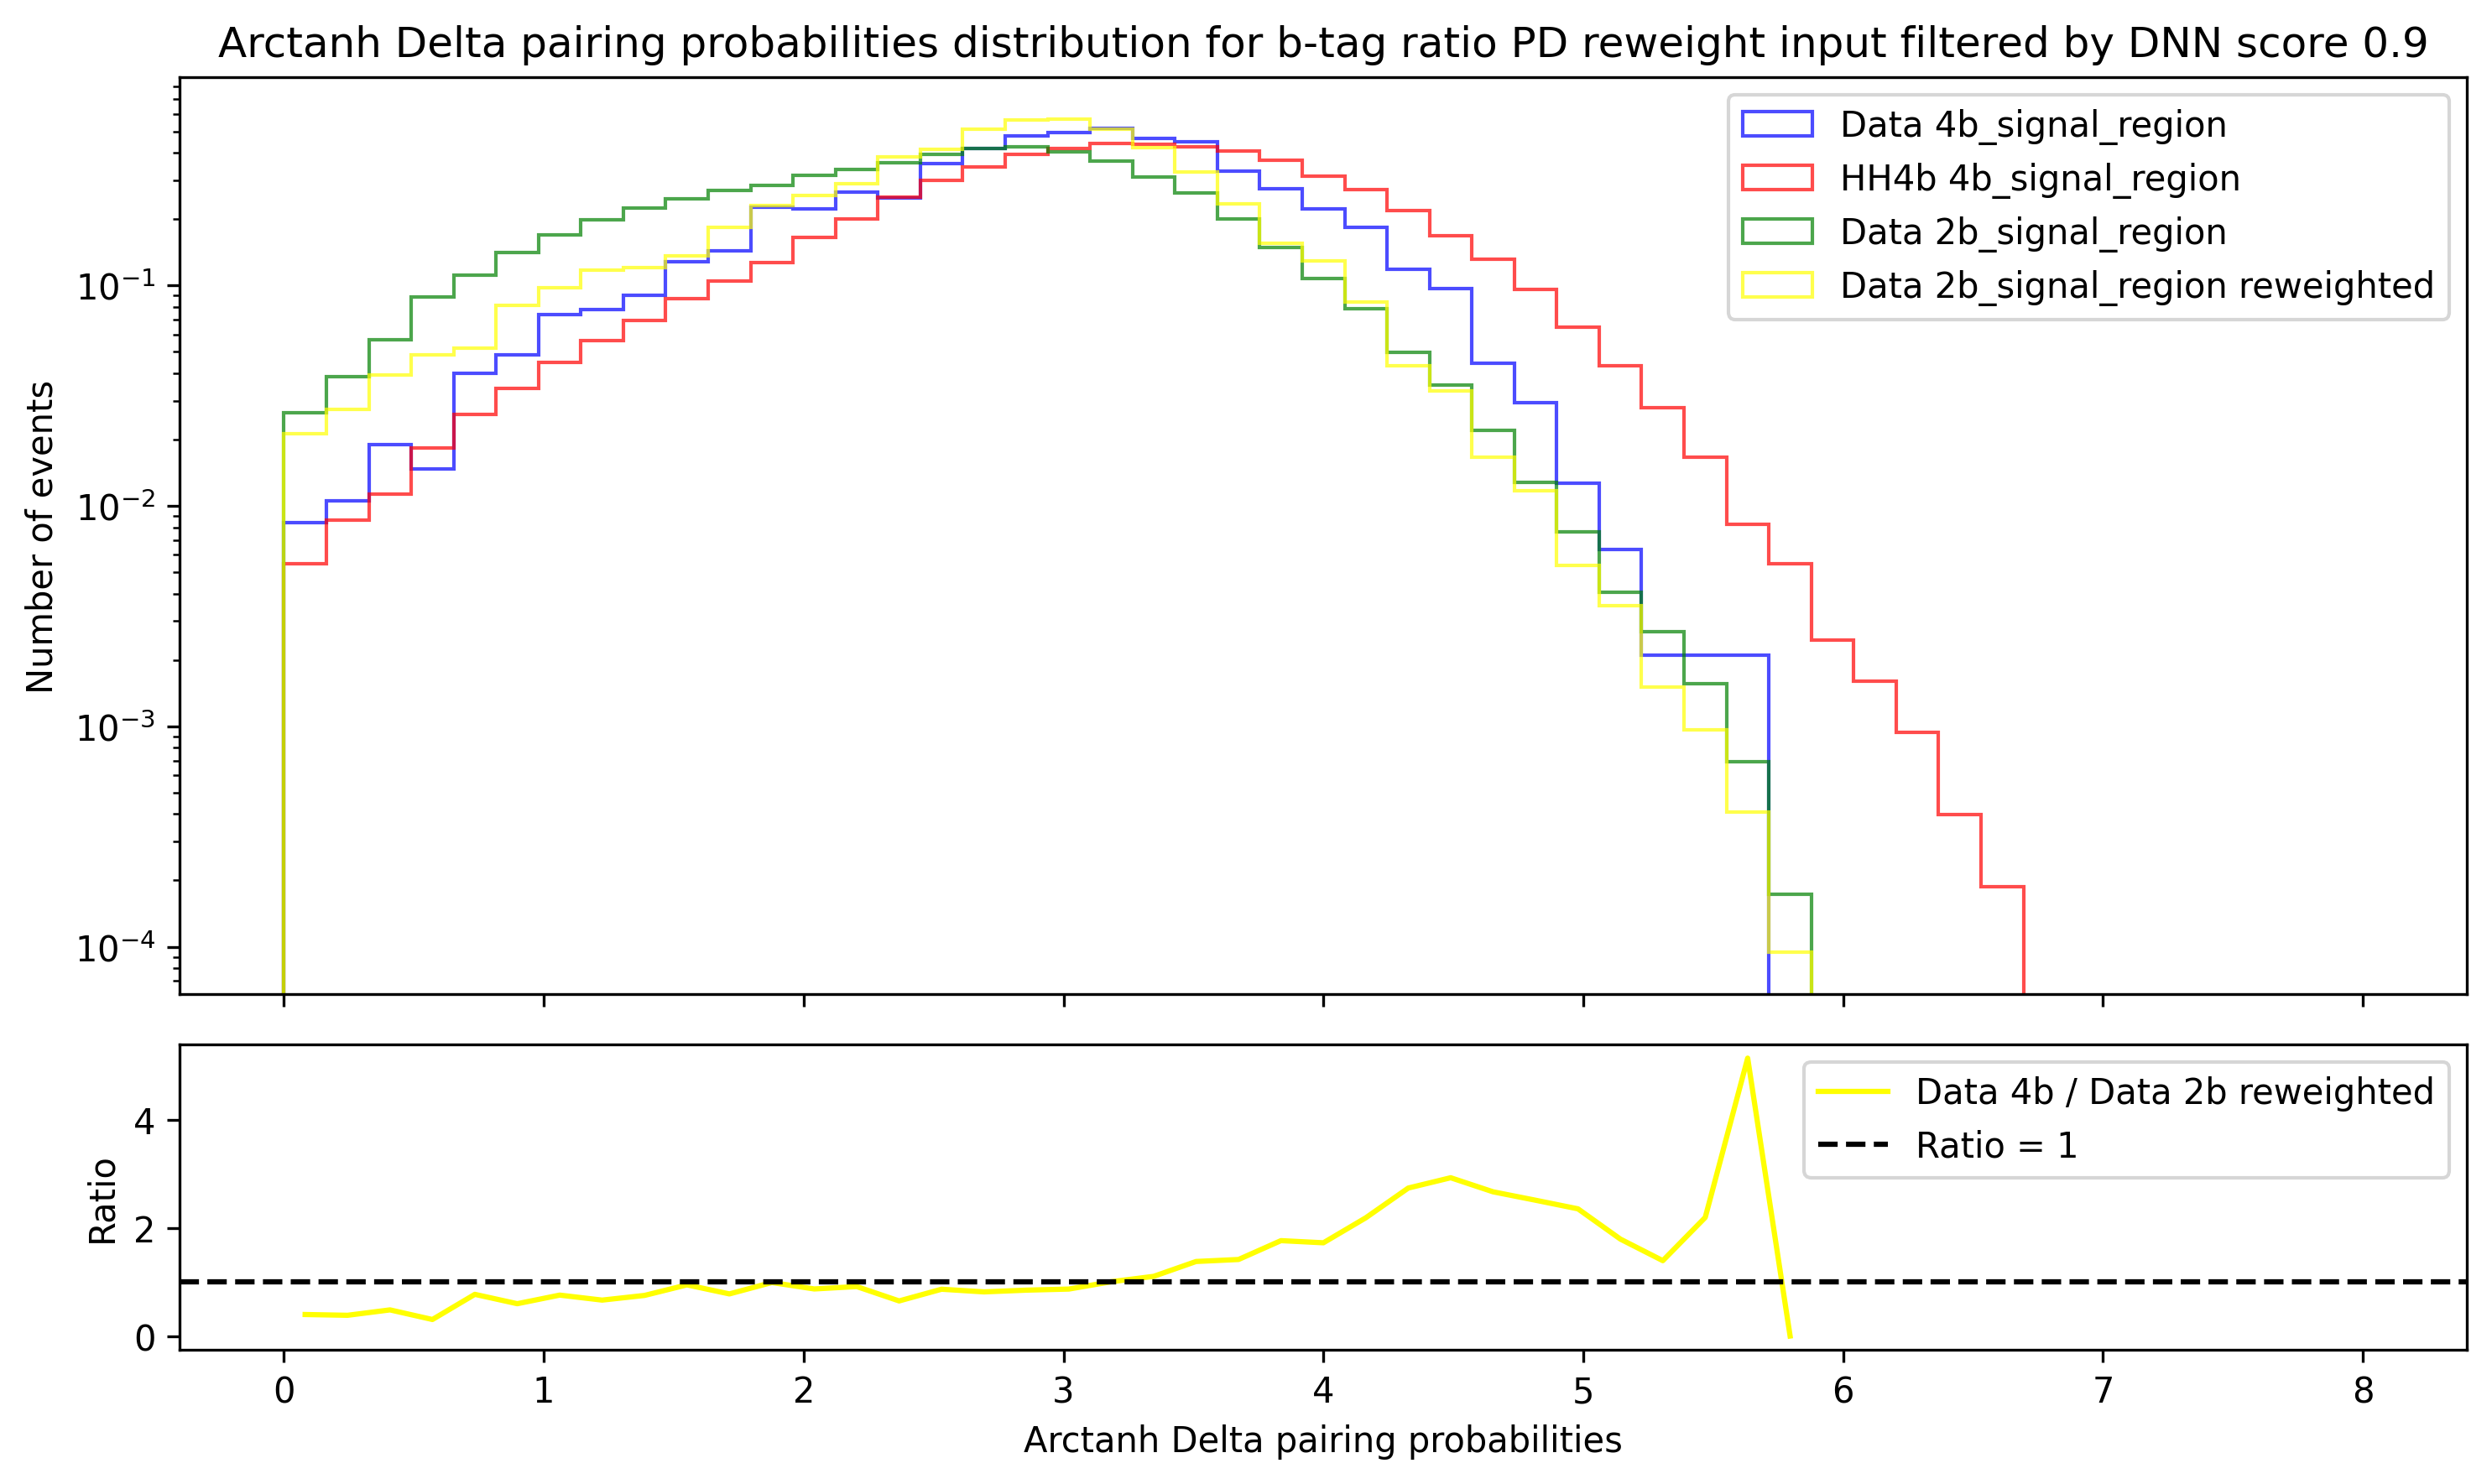

2908


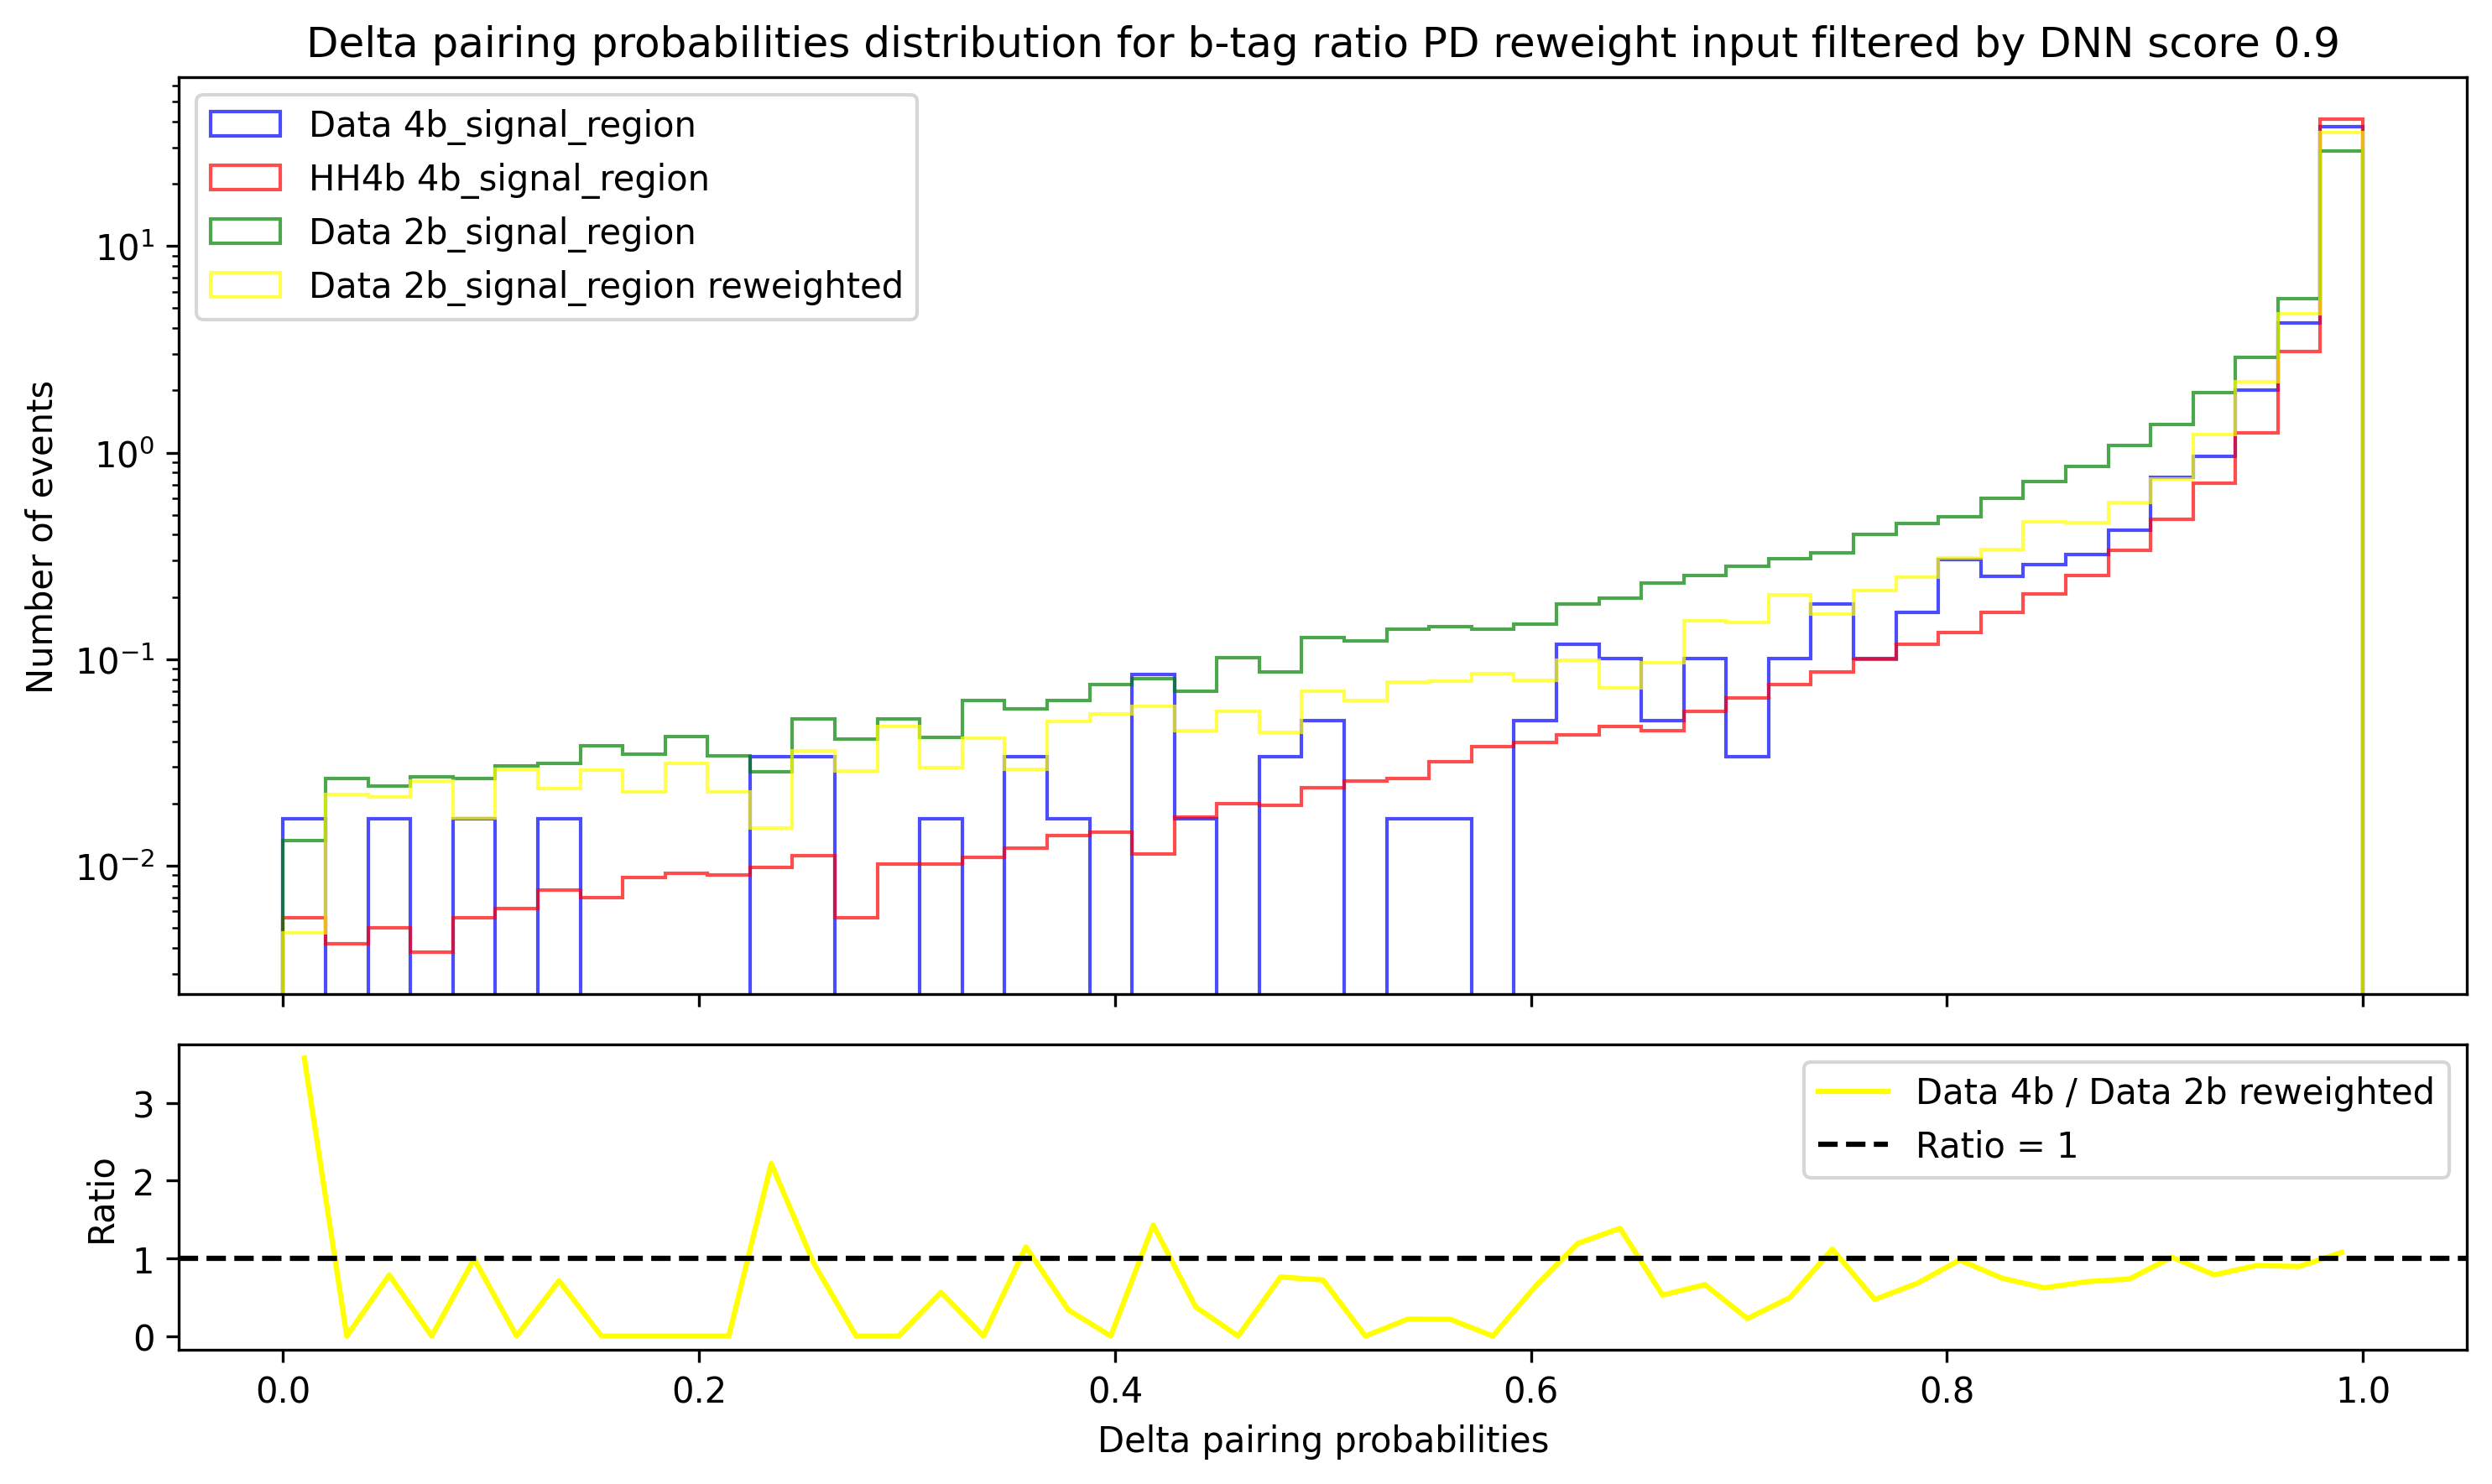

2908


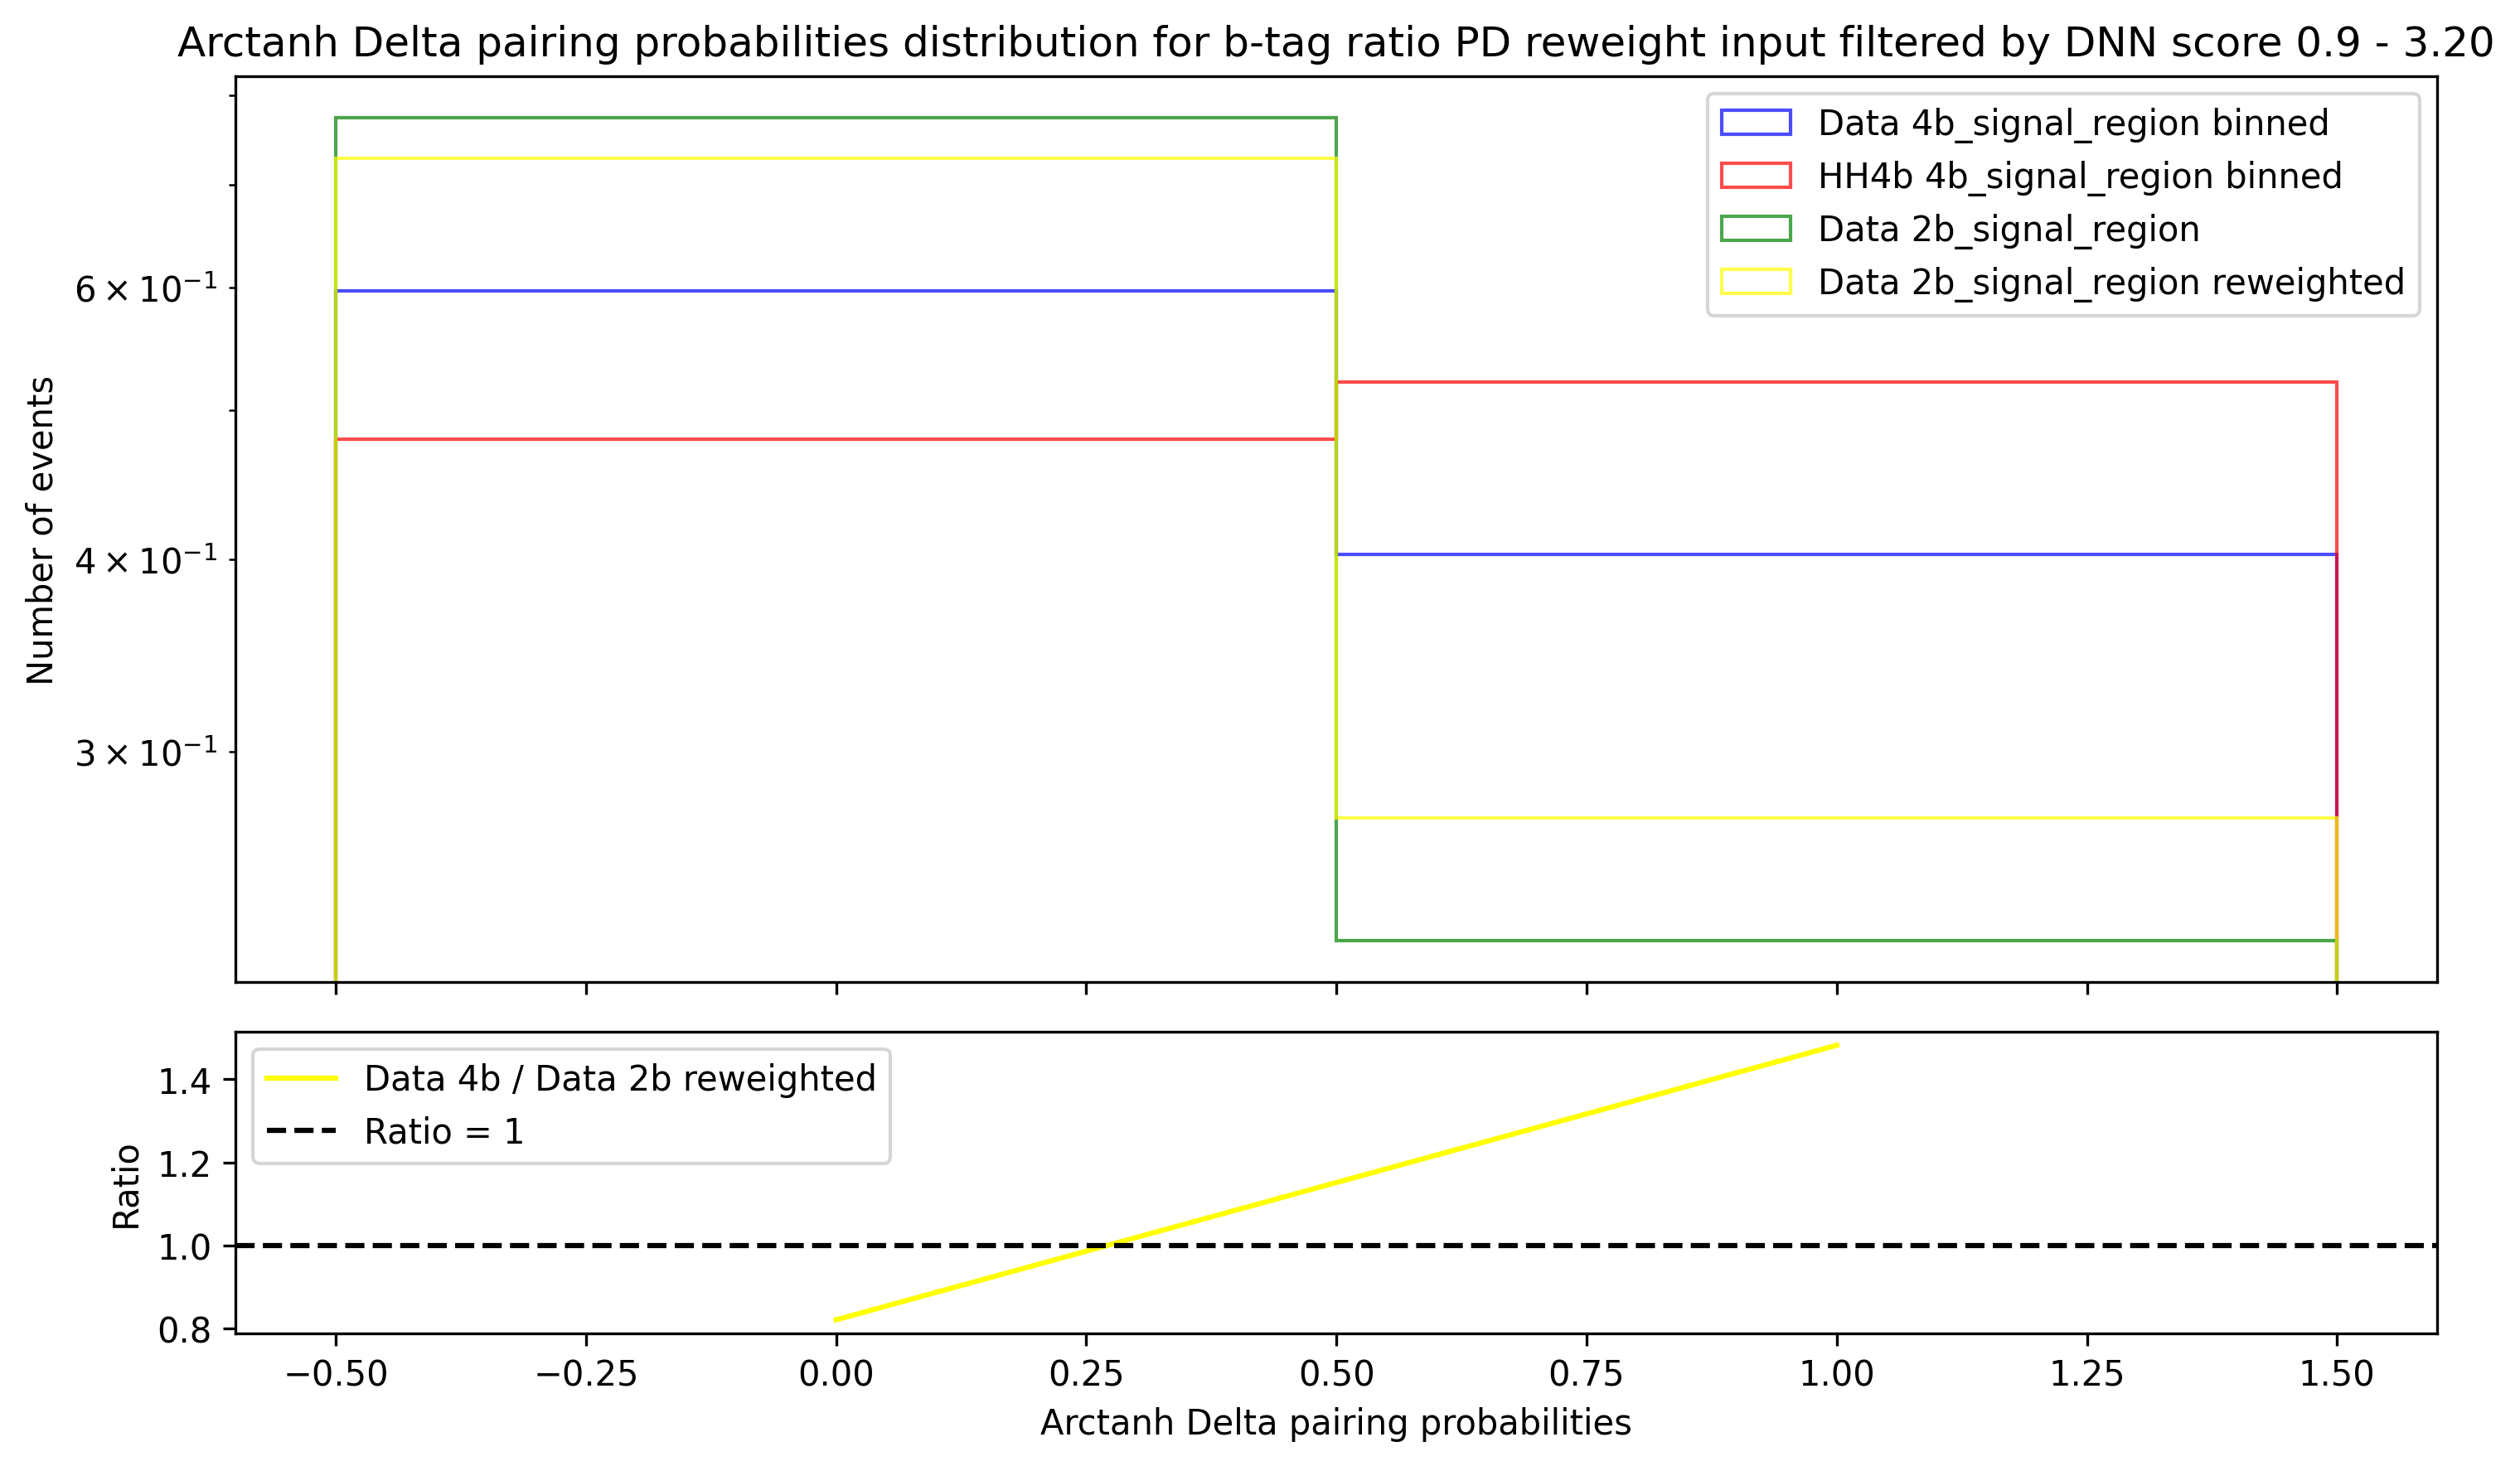

In [ ]:
input_data = ["/work/tharte/datasets/sig_bkg_classifier/spanet_ptflat_inclusive_b_trained_bratio_DeltaProb/output_DATA_JetMET_JMENano_E_2022_postEE_EraE.coffea", "/work/tharte/datasets/sig_bkg_classifier/spanet_ptflat_inclusive_b_trained_bratio_DeltaProb/output_DATA_JetMET_JMENano_F_2022_postEE_EraF.coffea", "/work/tharte/datasets/sig_bkg_classifier/spanet_ptflat_inclusive_b_trained_bratio_DeltaProb/output_DATA_JetMET_JMENano_G_2022_postEE_EraG.coffea"]
input_mc = ["/work/tharte/datasets/sig_bkg_classifier/spanet_ptflat_inclusive_b_trained_bratio_ArctanhDeltaProb/output_GluGlutoHHto4B_spanet_kl-1p00_kt-1p00_c2-0p00_2022_postEE.coffea"]
title = "b-tag ratio PD reweight input filtered by DNN score 0.9"
edge = 3.2

for region in ["signal", "control"]:
    category_4 = f"4b_{region}_region"
    category_2 = f"2b_{region}_region_postW"
    
    # d=data, m=MC, d2=DHH
    adp_d, adp_m, adp_d2, weights_m, weights_d2 = get_cols(input_data, input_mc, category_4, category_2, filter_dnn_score=True)
    print(weights_m)
    plot_distribution(adp_d, adp_m, adp_d2, weights_m, weights_d2, title, category_4, category_2,np.linspace(0, 8, 50))
    plot_distribution(adp_d, adp_m, adp_d2, weights_m, weights_d2, title, category_4, category_2,np.linspace(0, 1, 50), tanh=True)
    
    arctanh_delta_prob_bin_edges=[-0.2, edge, 20]
    bin_adp_d=np.digitize(adp_d, arctanh_delta_prob_bin_edges)-1
    bin_adp_m=np.digitize(adp_m, arctanh_delta_prob_bin_edges)-1
    bin_adp_d2=np.digitize(adp_d2, arctanh_delta_prob_bin_edges)-1
    
    plot_distribution(
        bin_adp_d, bin_adp_m, bin_adp_d2, weights_m, weights_d2, f"{title} - {edge:.2f}", category_4 + " binned", category_2 + " binned", [-0.5, 0.5, 1.5]
    )

# get the histogram
# hist_d, edges_d = np.histogram(dp_d, bins=100, density=True)
# hist_m, edges_m = np.histogram(dp_m, bins=100, weights=weights_m, density=True)
# hist_d2, edges_d2 = np.histogram(dp_d2, bins=100, density=True)
# # print(f"Data 4b histogram: {hist_d} {edges_d}")
# # print(f"Signal 4b histogram: {hist_m} {edges_m}")
# print(f"Data 2b histogram: {hist_d2} {edges_d2}")
# for i in range(len(hist_d2)):
#     print(f"Data 2b histogram bin {i}: {edges_d2[i]} - {edges_d2[i+1]}: {hist_d2[i]}")



## b-ratio with Arctanh(PD) input for reweighting

Data: DATA_JetMET_JMENano DATA_JetMET_JMENano_2022_postEE
MC: GluGlutoHHto4B_spanet GluGlutoHHto4B_spanet_kl-1p00_kt-1p00_c2-0p00_2022_postEE
84357


/tmp/ipykernel_1386628/2355170080.py:43: RuntimeWarning: invalid value encountered in divide
  ratio_d = hist_d / hist_m
/tmp/ipykernel_1386628/2355170080.py:44: RuntimeWarning: invalid value encountered in divide
  ratio_d2 = hist_d / hist_d2
/tmp/ipykernel_1386628/2355170080.py:46: RuntimeWarning: invalid value encountered in divide
  ratio_d2_rw = hist_d / hist_d2_rw


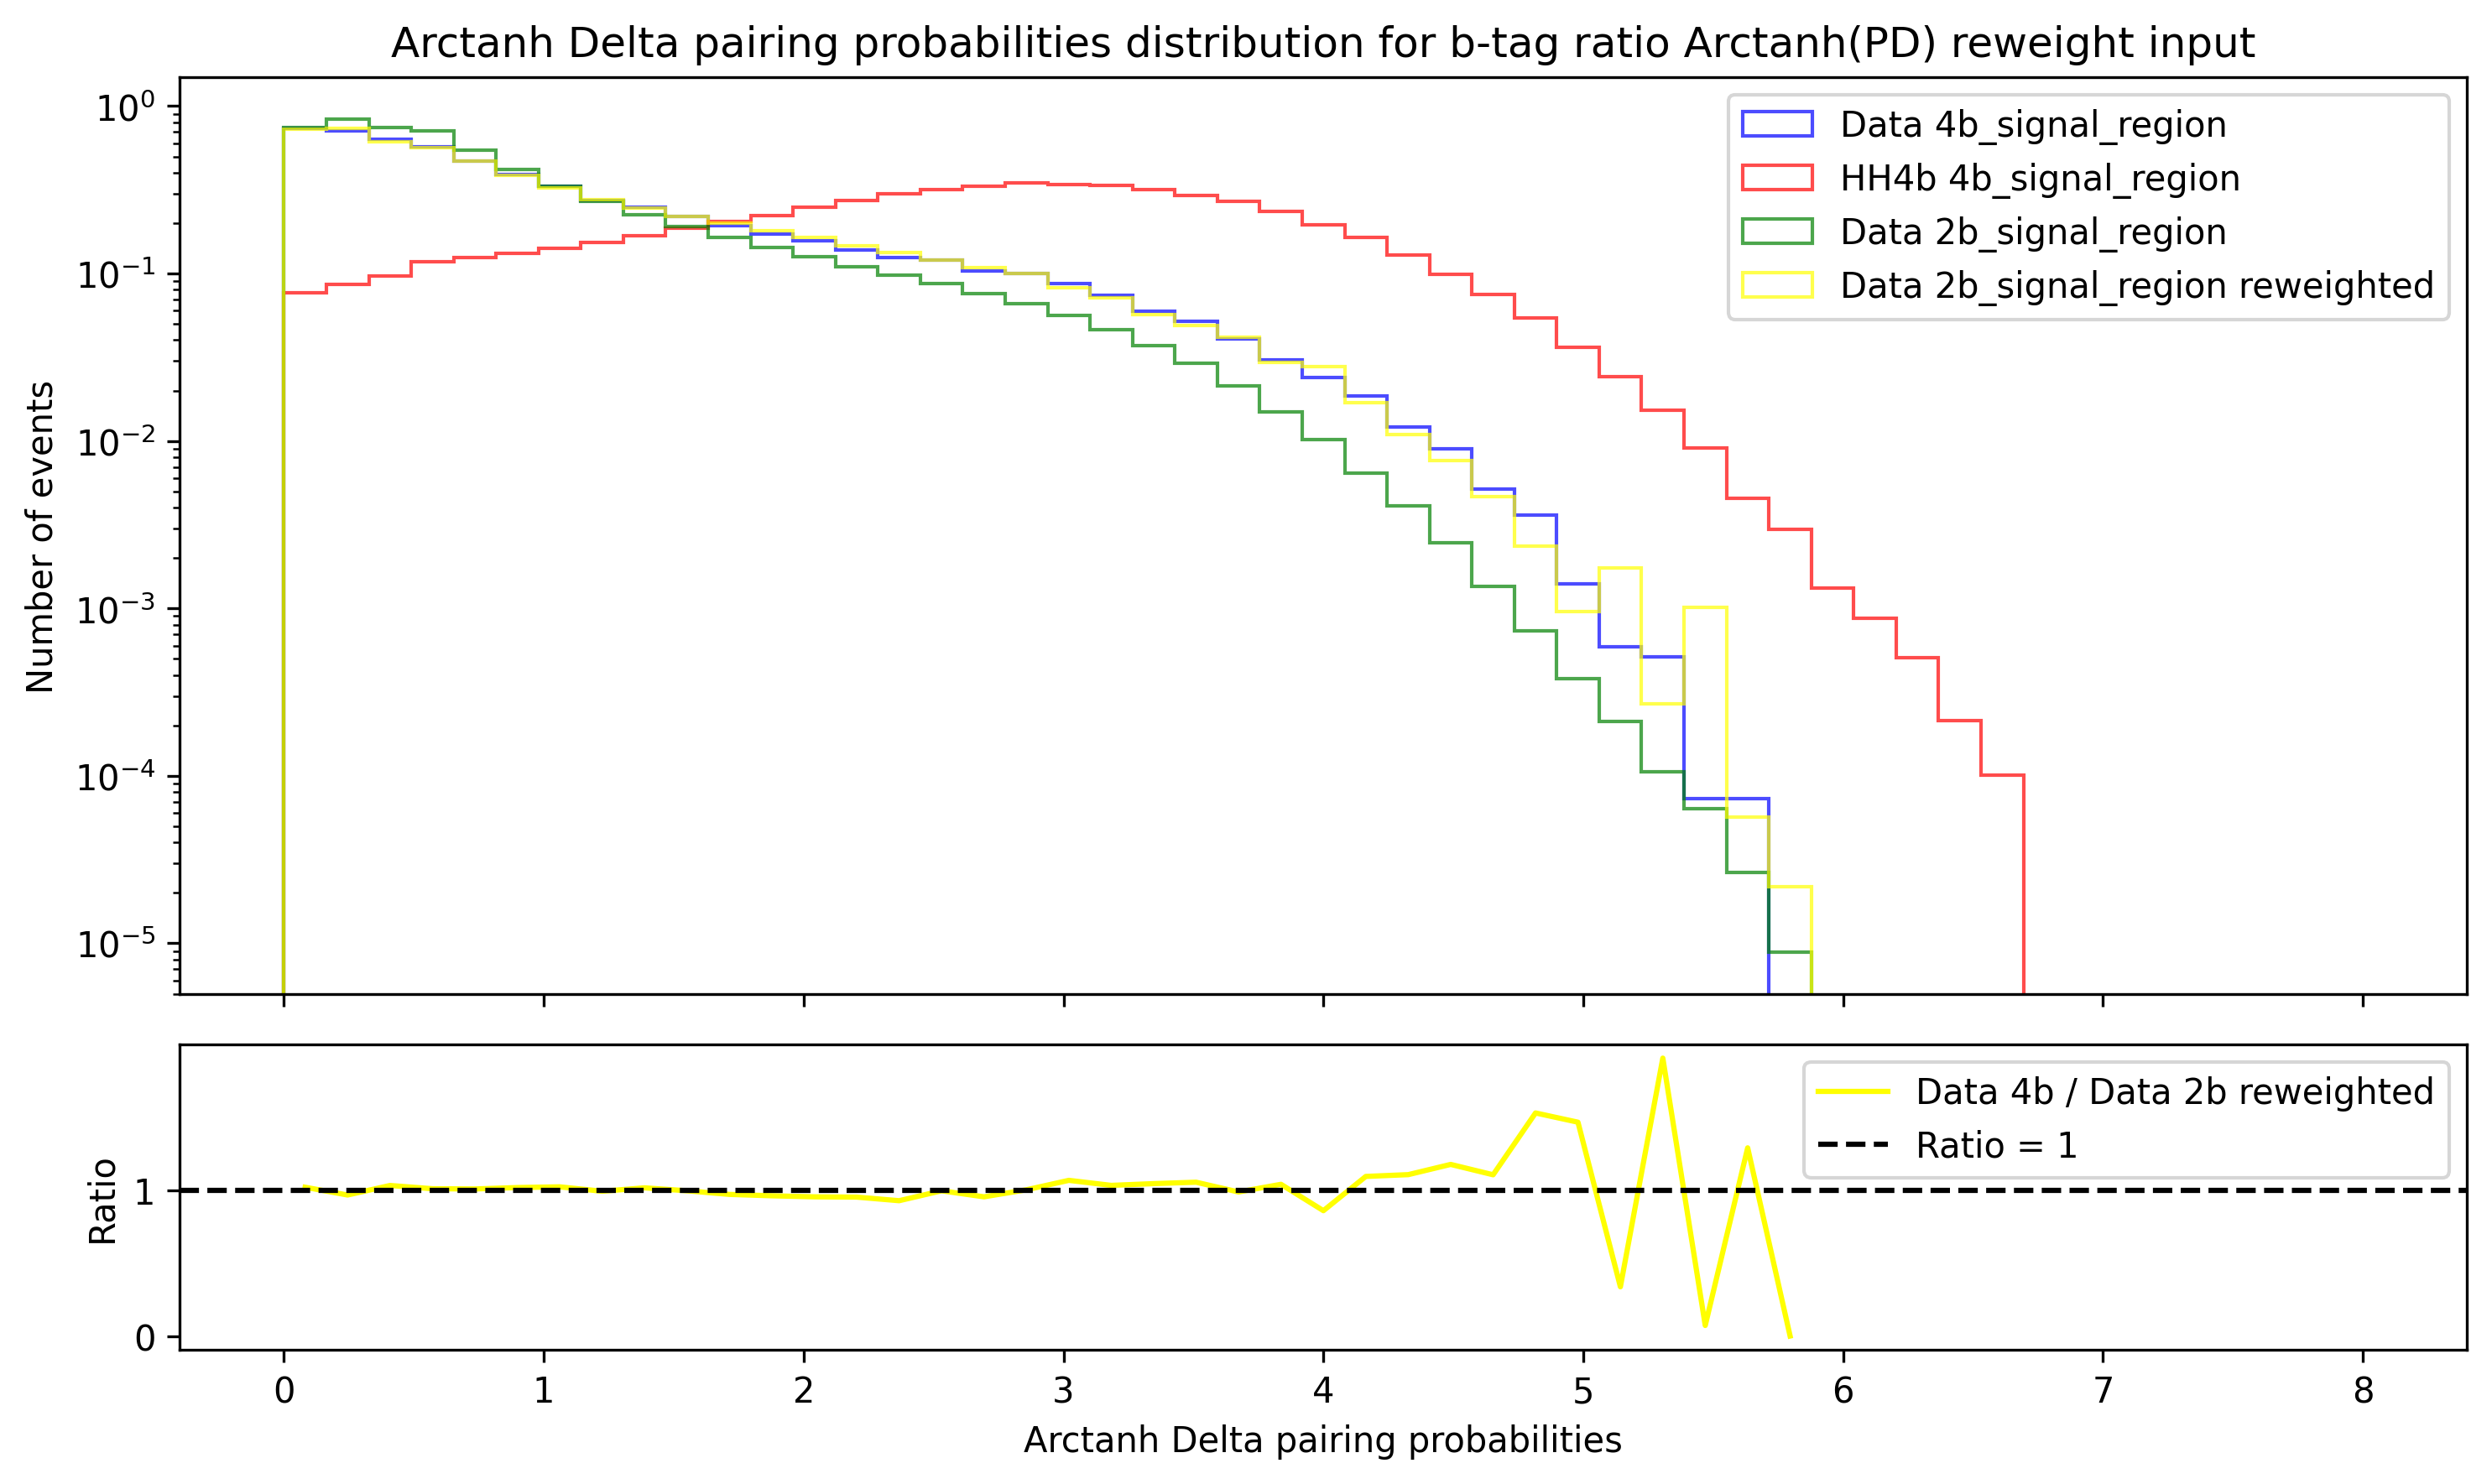

84357


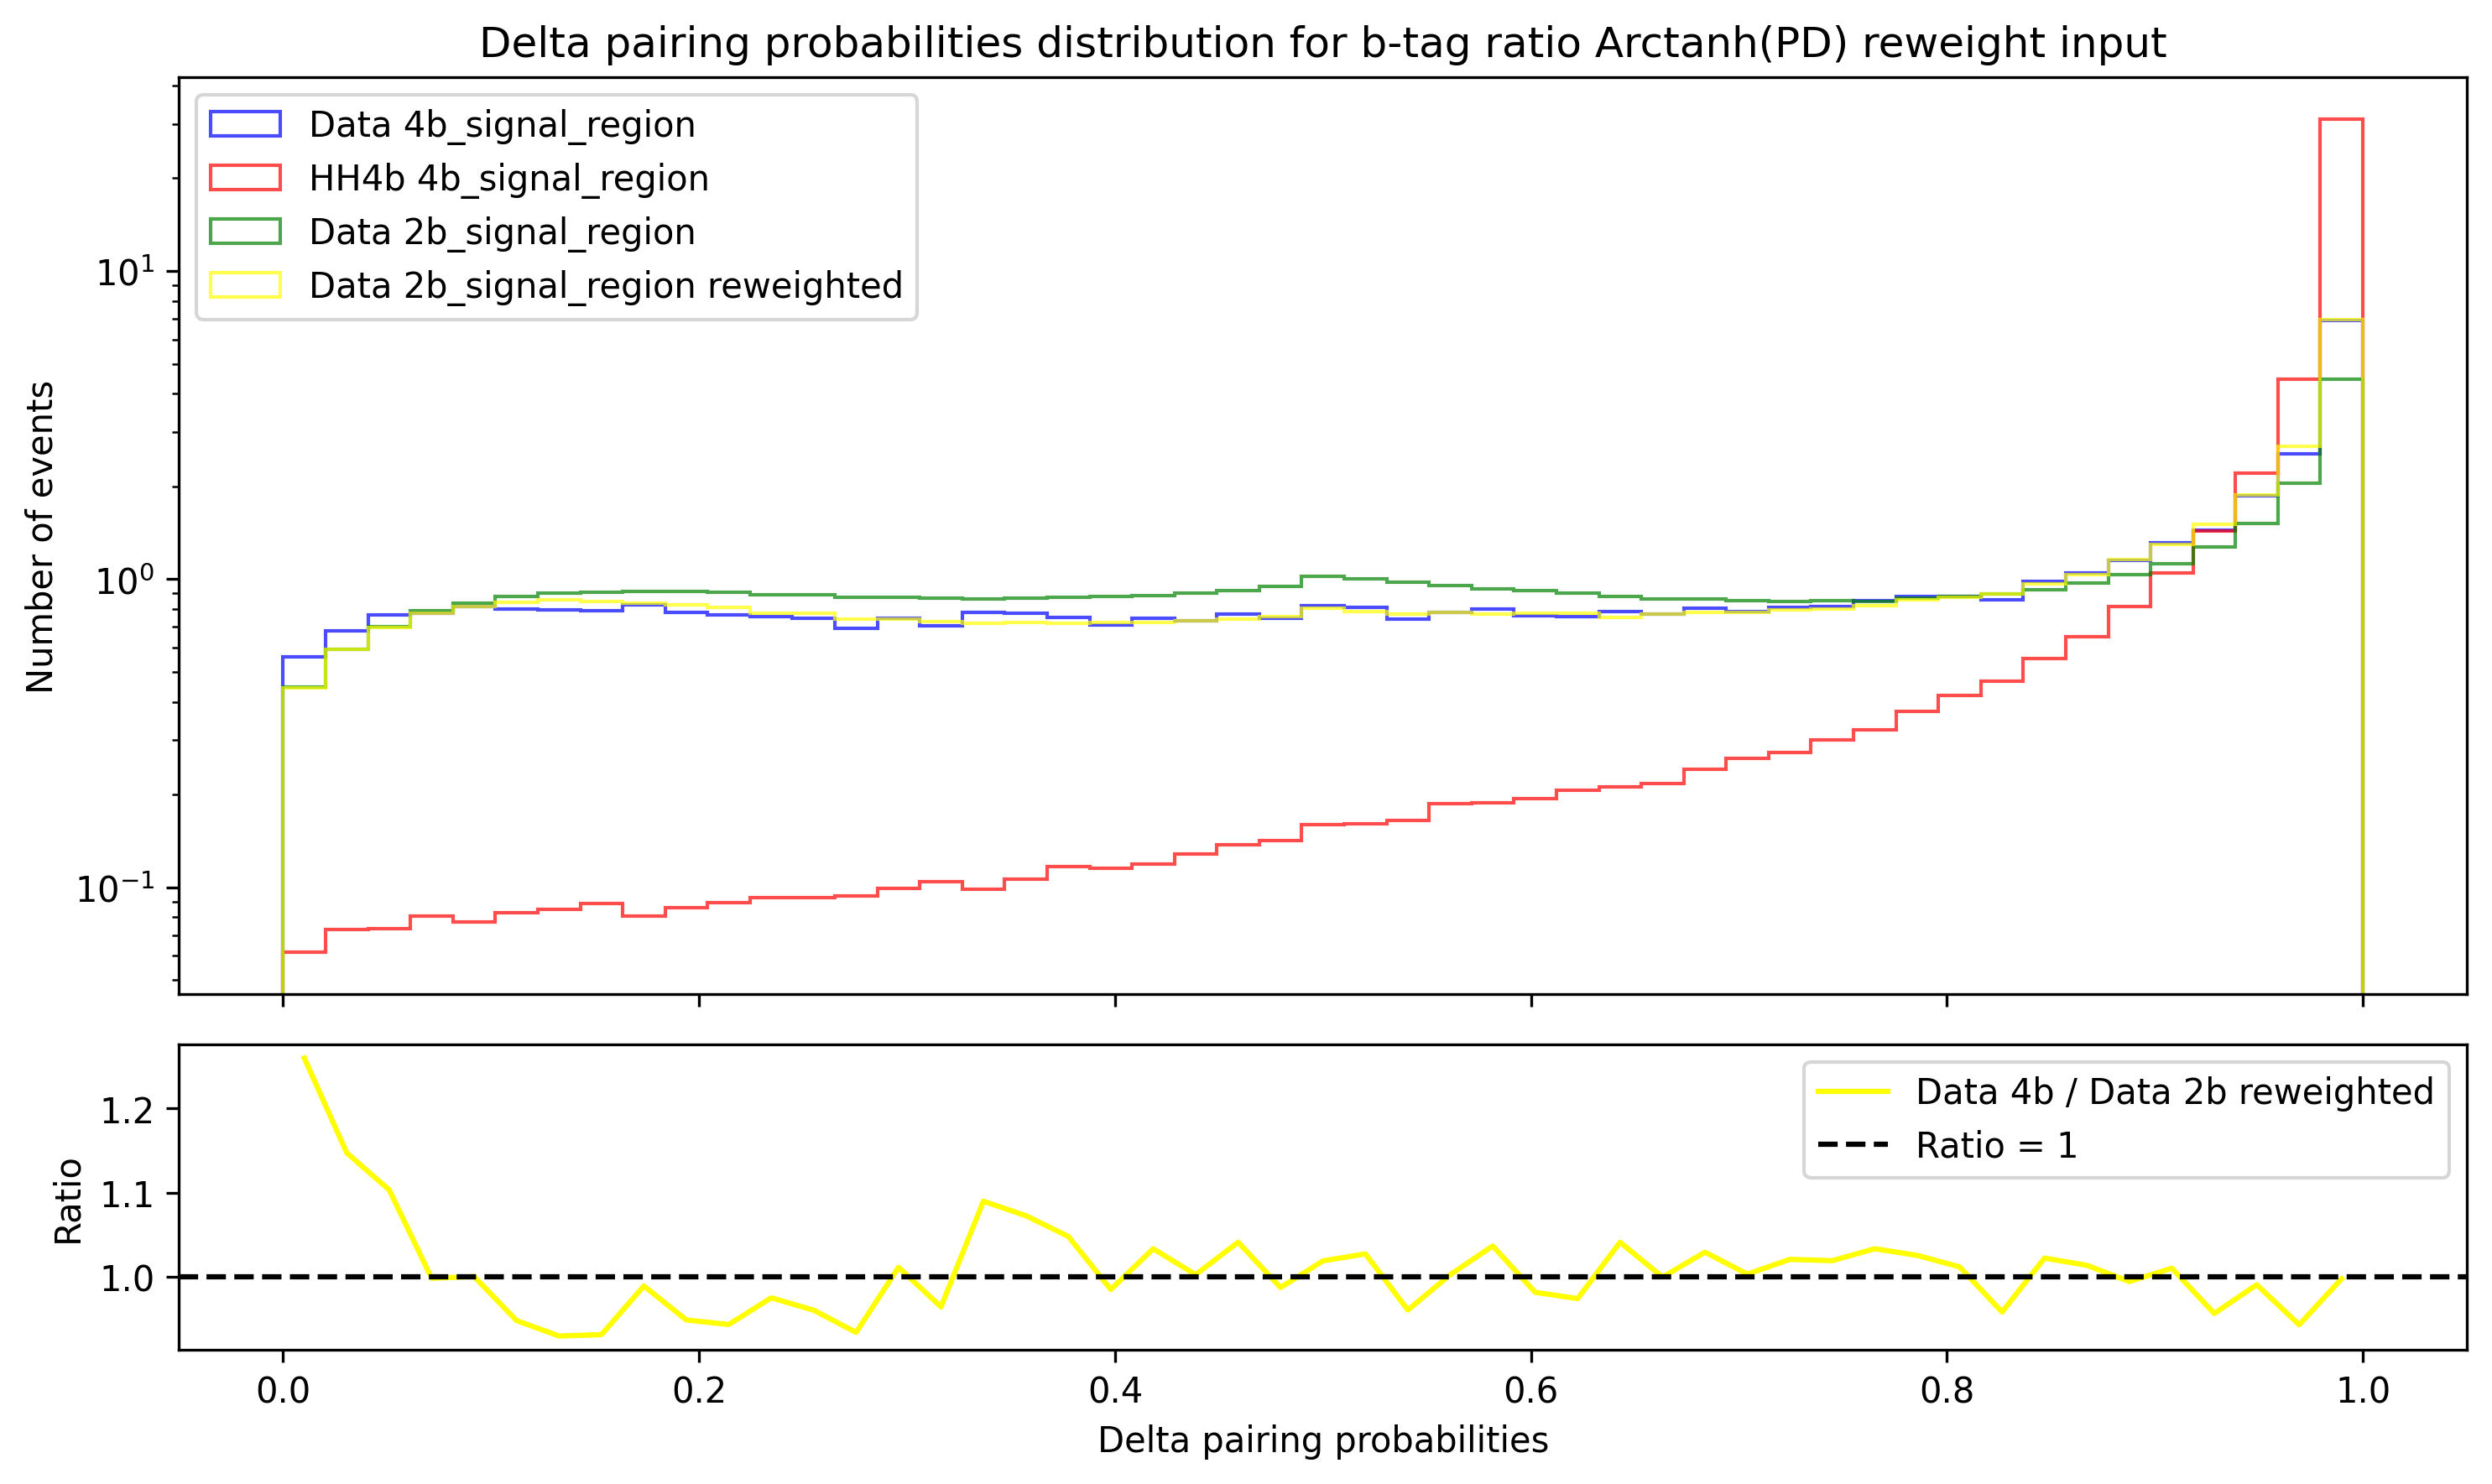

84357


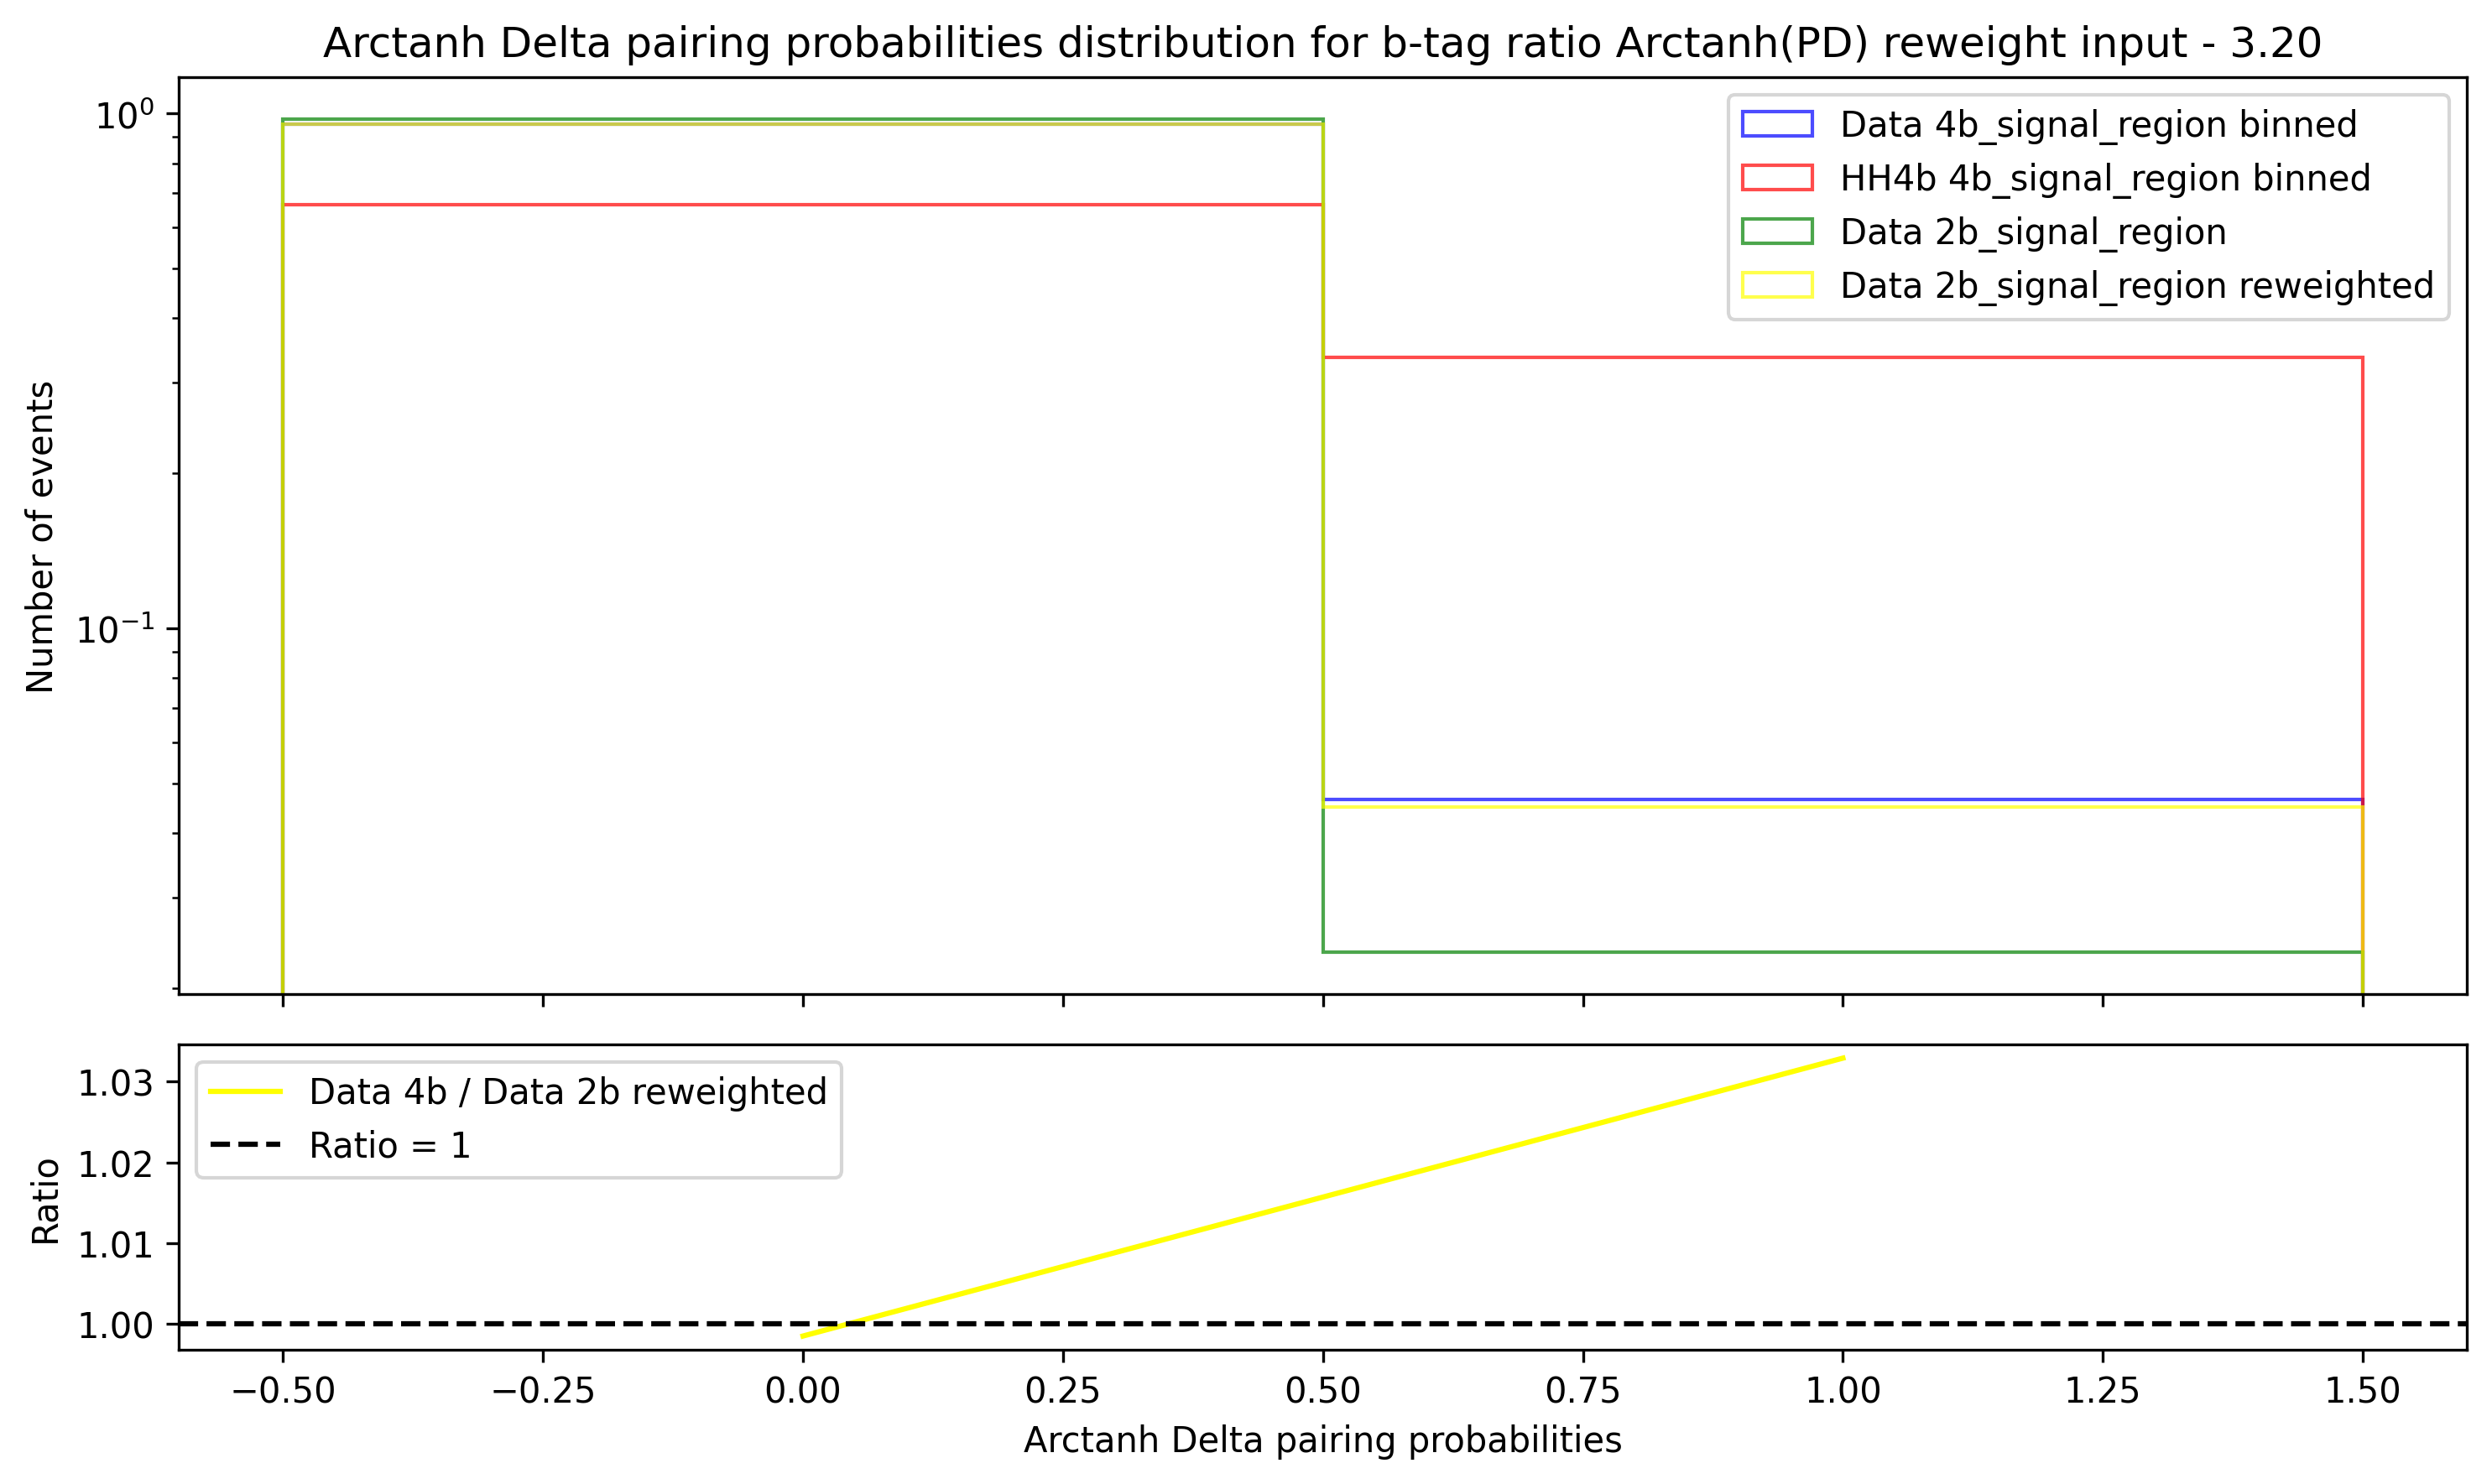

Data: DATA_JetMET_JMENano DATA_JetMET_JMENano_2022_postEE
MC: GluGlutoHHto4B_spanet GluGlutoHHto4B_spanet_kl-1p00_kt-1p00_c2-0p00_2022_postEE
161632


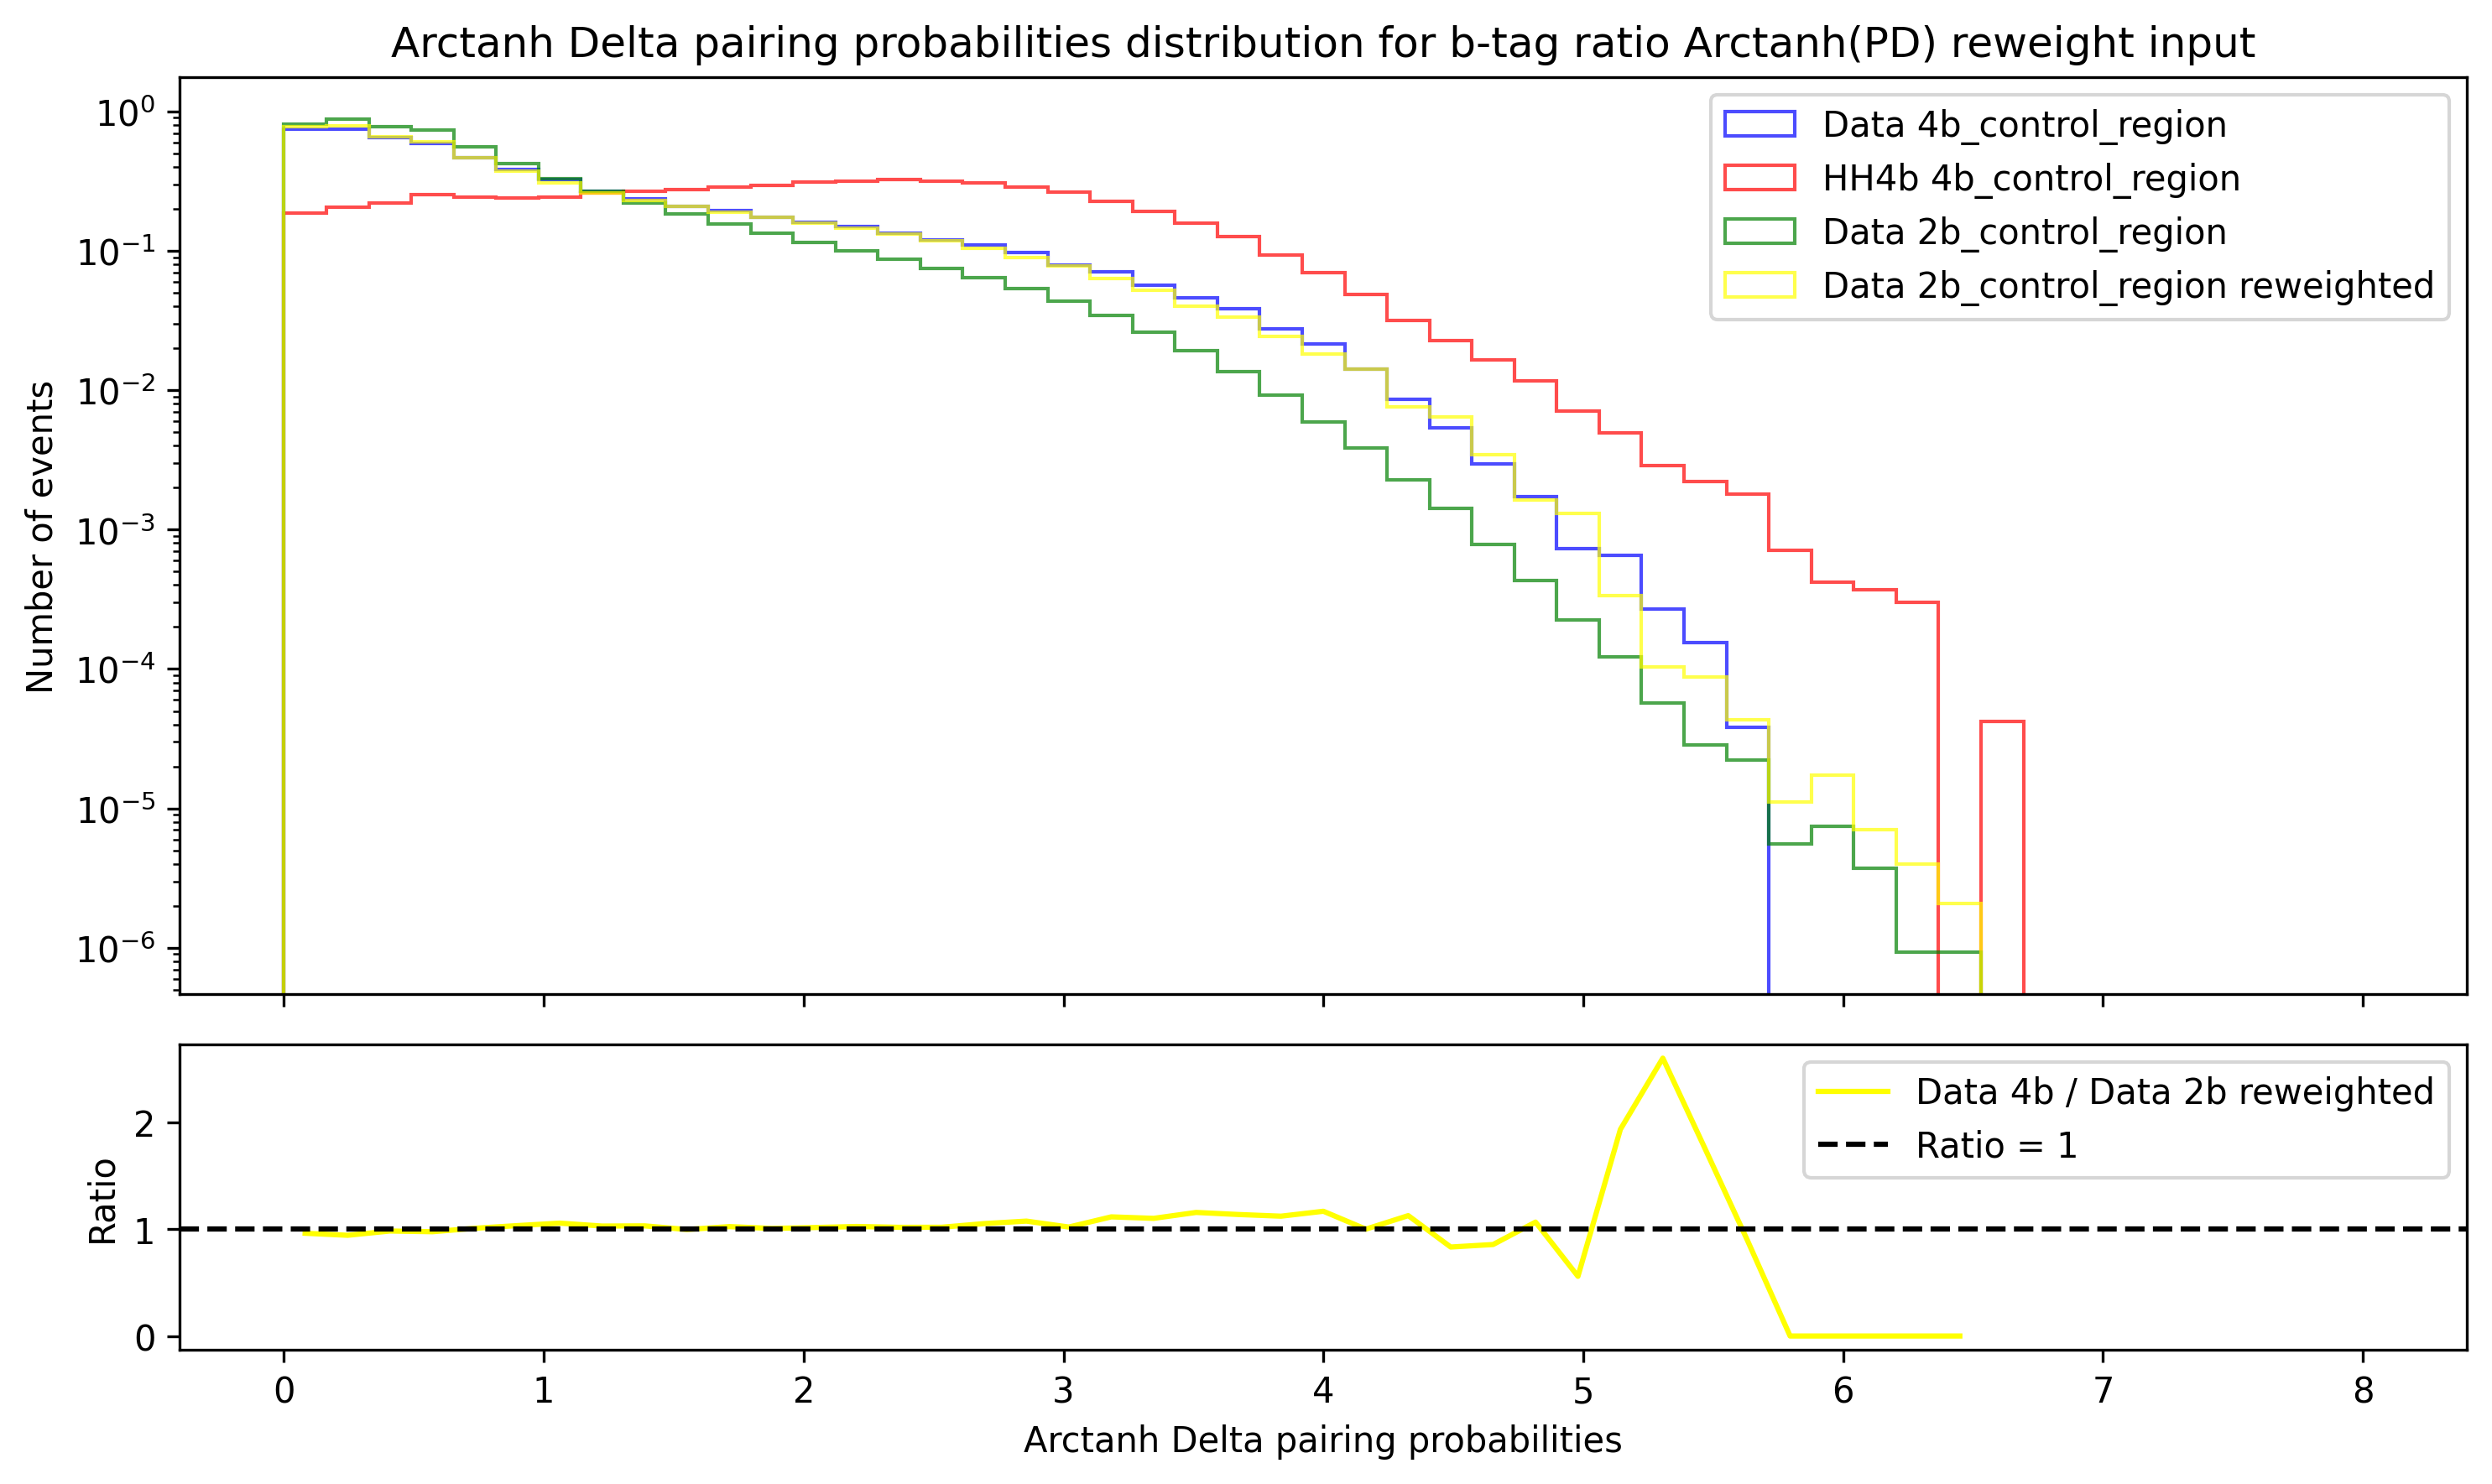

161632


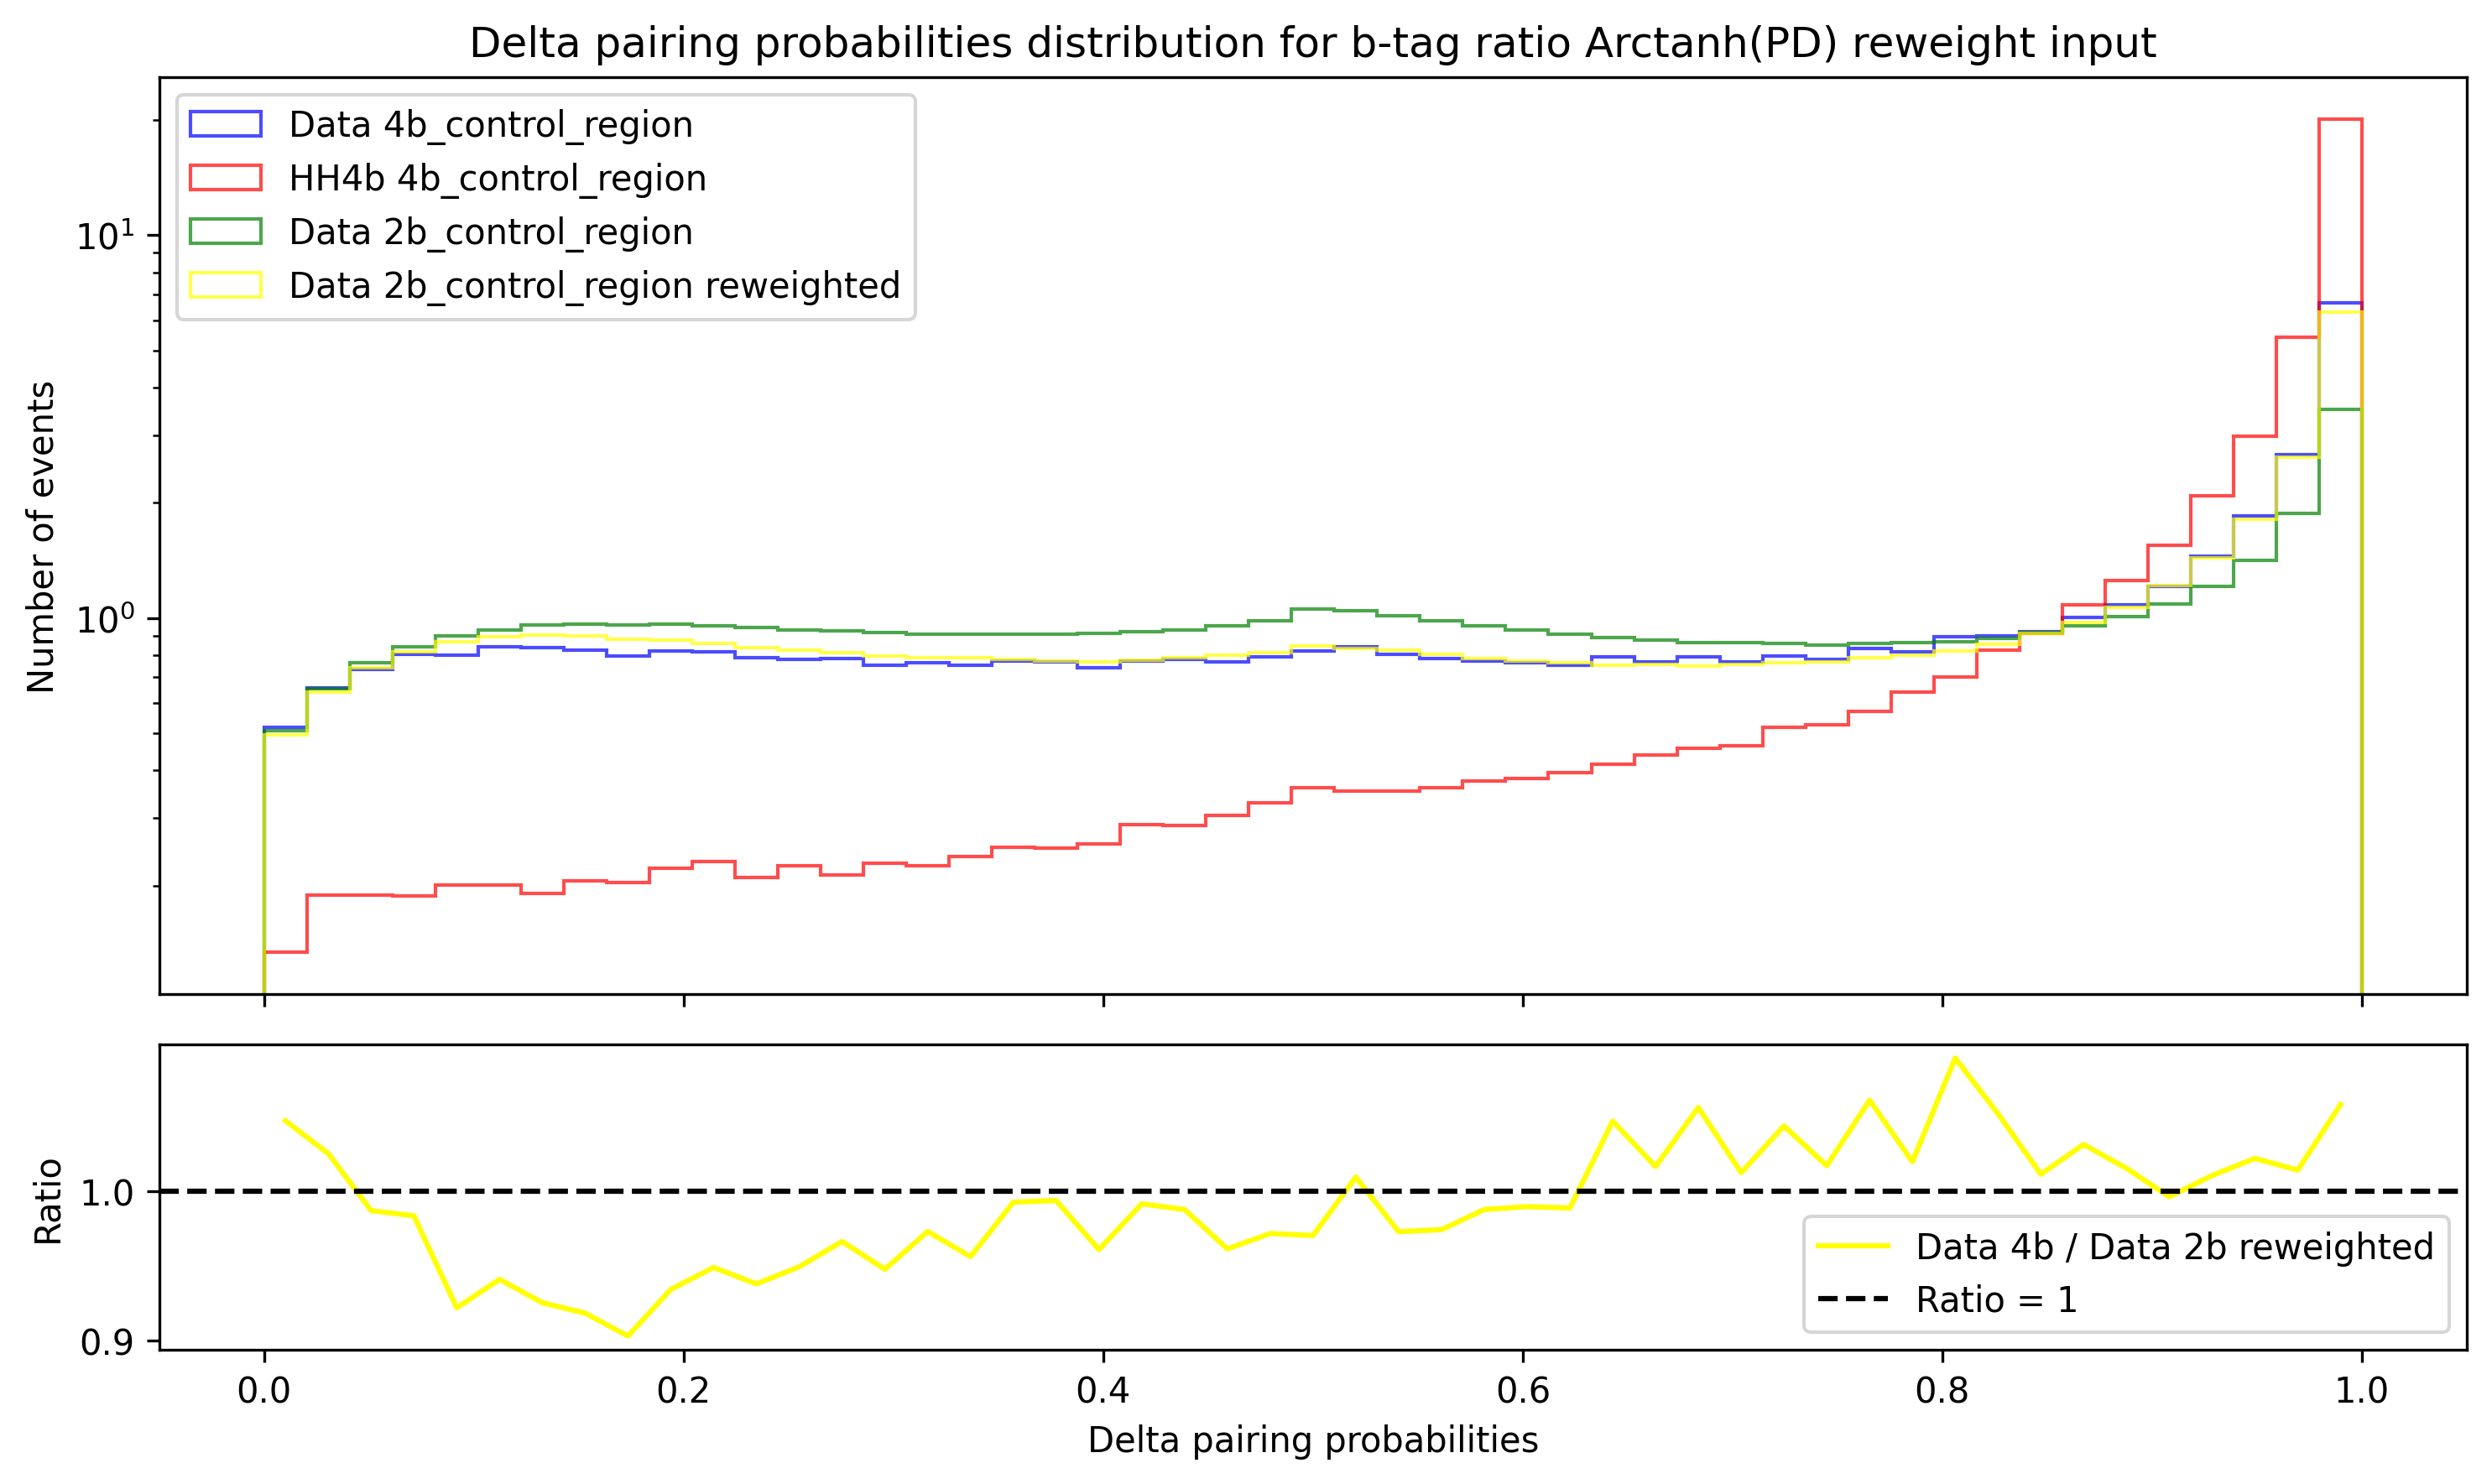

161632


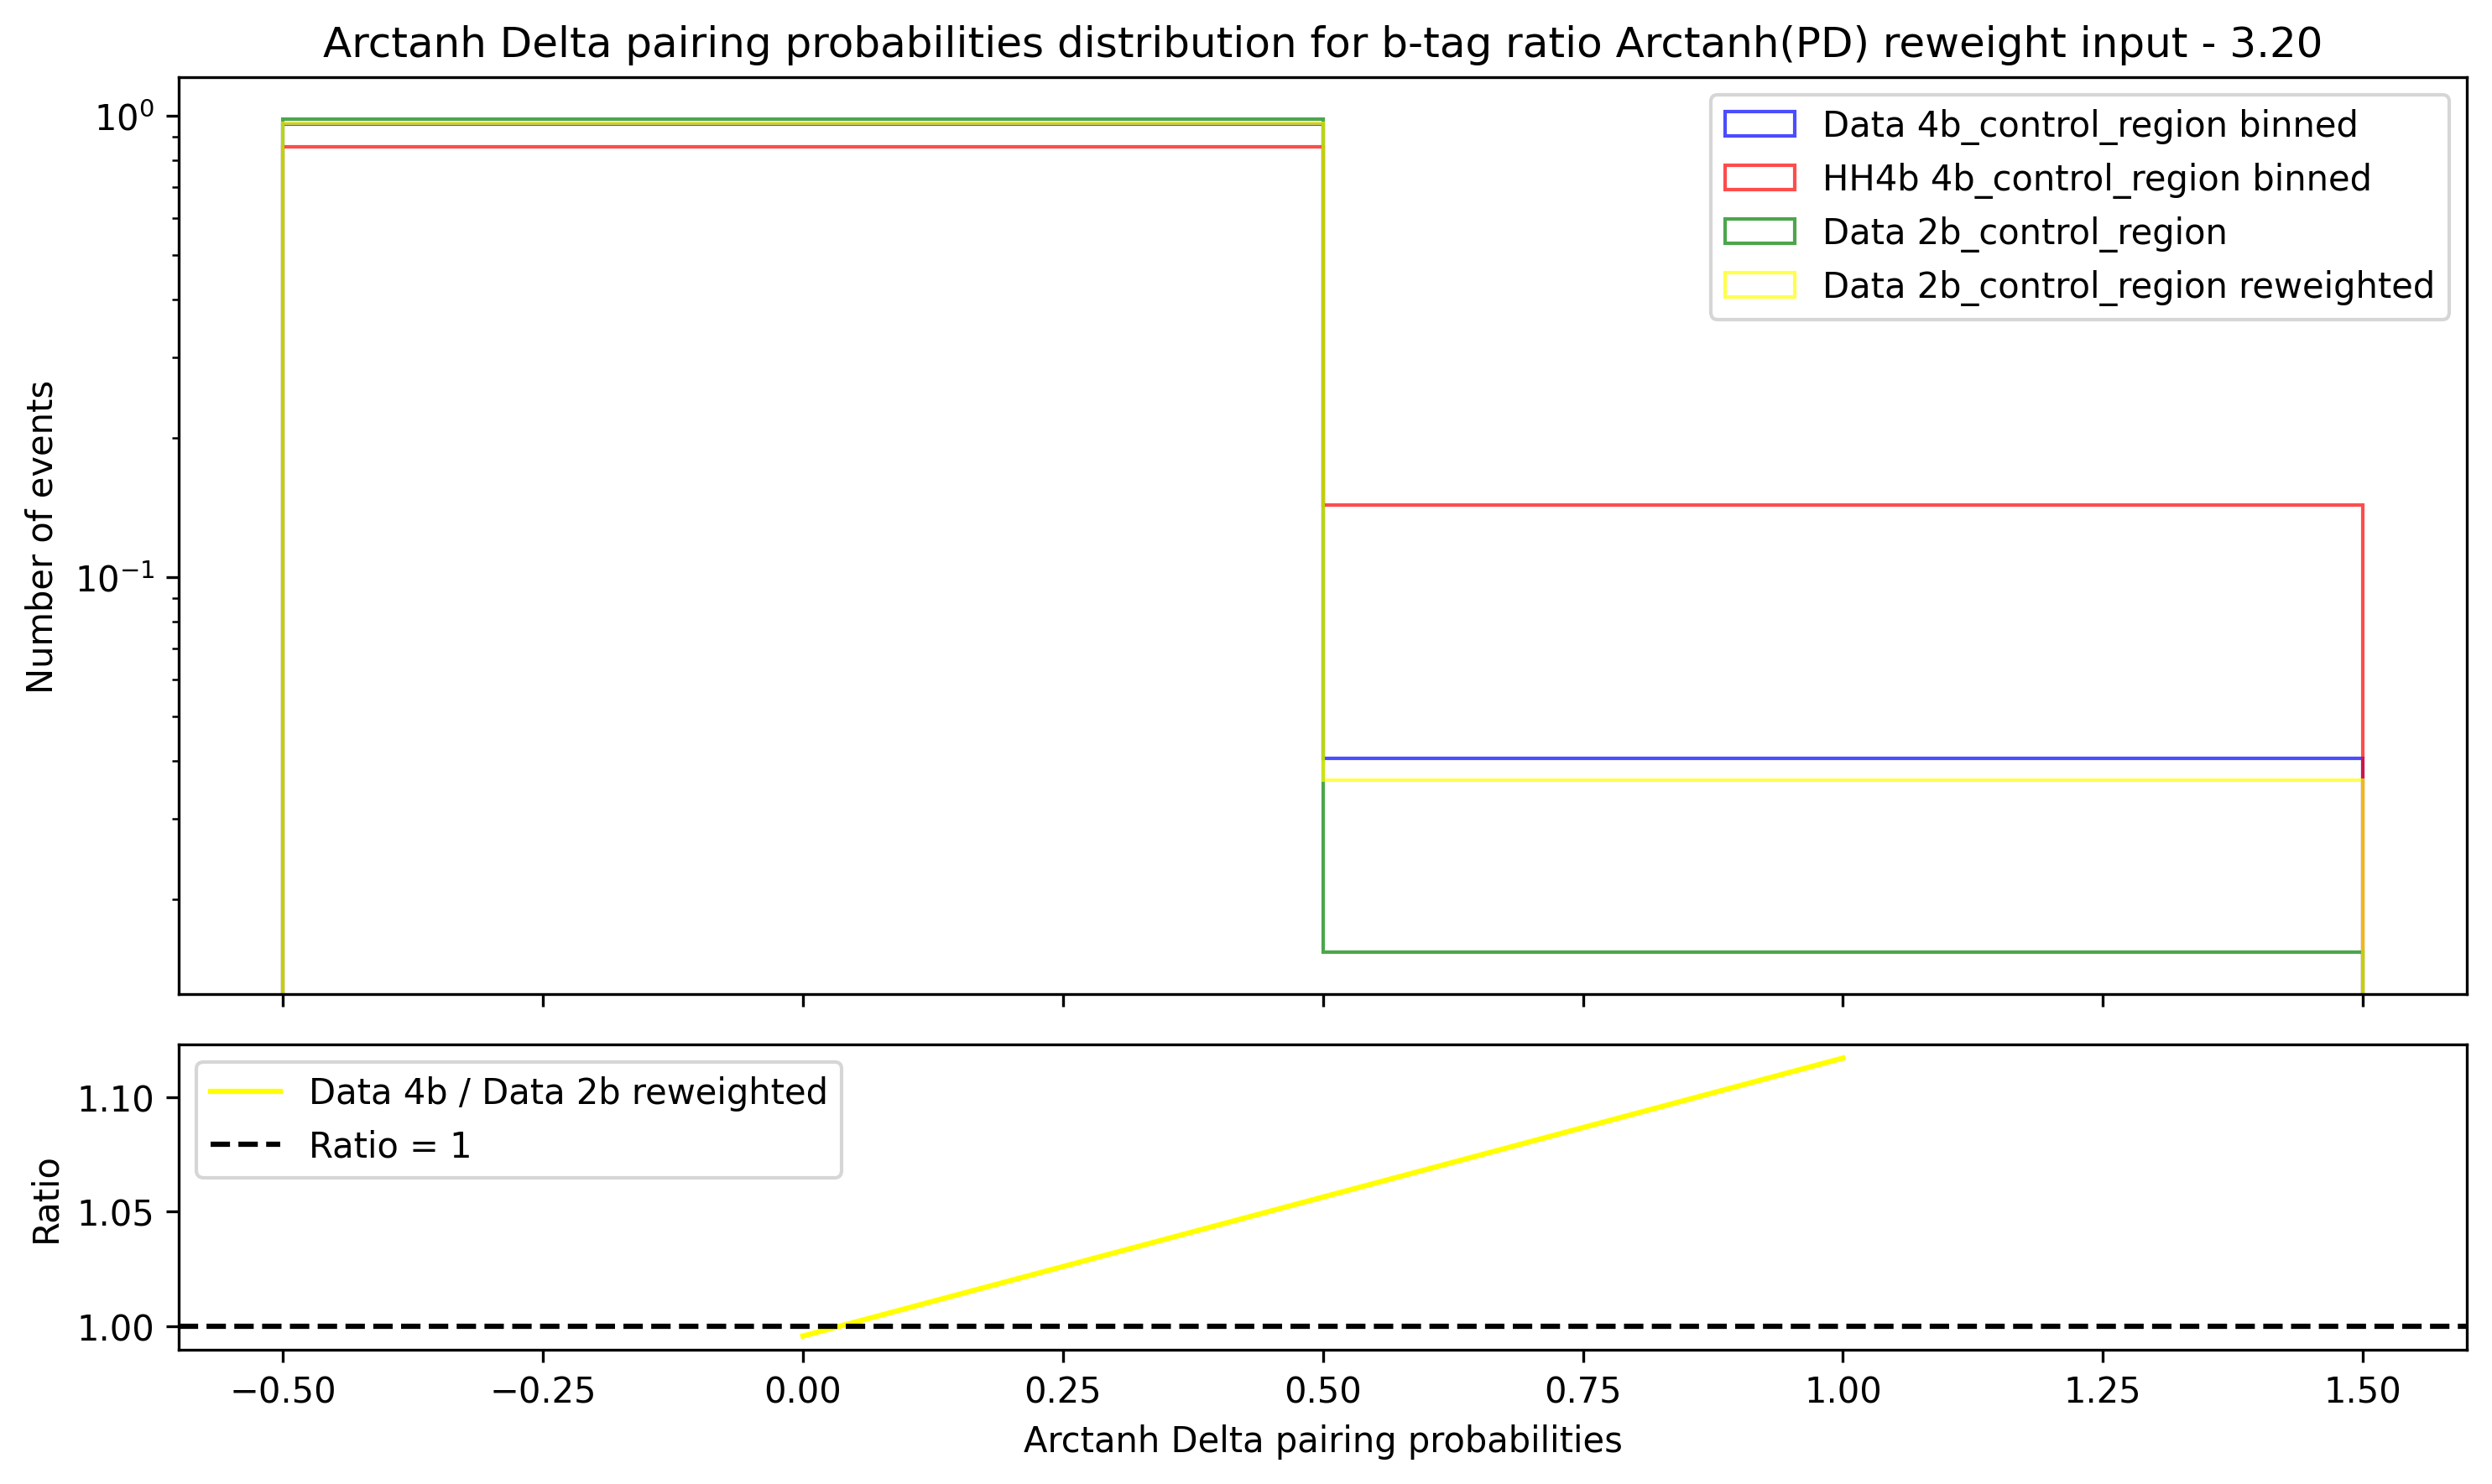

In [54]:
#input_data = "/work/mmalucch/out_hh4b/SigBkg/out_2022postEE_ggFSPANetDataset_SPANETptVary0p3_1p7_Morphing_DNN_AN_1e-3_e20drop75_minDelta1em5_SPANet_only2022postEE_noEarlyStopping_20folds_DeltaProbabilityMorphing_SigBkg_DNN_ptFlatSPANet_class_weights_e5drop75_postEE_DeltaProbability/output_DATA_JetMET_JMENano_G_2022_postEE_EraG.coffea"
#input_mc = "/work/mmalucch/out_hh4b/SigBkg/out_2022postEE_ggFSPANetDataset_SPANETptVary0p3_1p7_Morphing_DNN_AN_1e-3_e20drop75_minDelta1em5_SPANet_only2022postEE_noEarlyStopping_20folds_DeltaProbabilityMorphing_SigBkg_DNN_ptFlatSPANet_class_weights_e5drop75_postEE_DeltaProbability/output_GluGlutoHHto4B_spanet_kl-1p00_kt-1p00_c2-0p00_2022_postEE.coffea"
input_data = ["/work/tharte/datasets/sig_bkg_classifier/spanet_ptflat_inclusive_b_trained_bratio_ArctanhDeltaProb/output_DATA_JetMET_JMENano_E_2022_postEE_EraE.coffea", "/work/tharte/datasets/sig_bkg_classifier/spanet_ptflat_inclusive_b_trained_bratio_ArctanhDeltaProb/output_DATA_JetMET_JMENano_F_2022_postEE_EraF.coffea", "/work/tharte/datasets/sig_bkg_classifier/spanet_ptflat_inclusive_b_trained_bratio_ArctanhDeltaProb/output_DATA_JetMET_JMENano_G_2022_postEE_EraG.coffea"]
input_mc = ["/work/tharte/datasets/sig_bkg_classifier/spanet_ptflat_inclusive_b_trained_bratio_ArctanhDeltaProb/output_GluGlutoHHto4B_spanet_kl-1p00_kt-1p00_c2-0p00_2022_postEE.coffea"]
title = "b-tag ratio Arctanh(PD) reweight input"

for region in ["signal", "control"]:
    category_4 = f"4b_{region}_region"
    category_2 = f"2b_{region}_region_postW"
    
    adp_d, adp_m, adp_d2, weights_m, weights_d2 = get_cols(input_data, input_mc, category_4, category_2)
    plot_distribution(adp_d, adp_m, adp_d2, weights_m, weights_d2, title, category_4, category_2,np.linspace(0, 8, 50))
    plot_distribution(adp_d, adp_m, adp_d2, weights_m, weights_d2, title, category_4, category_2,np.linspace(0, 1, 50), tanh=True)
    
    arctanh_delta_prob_bin_edges=[-0.2, edge, 20]
    bin_adp_d=np.digitize(adp_d, arctanh_delta_prob_bin_edges)-1
    bin_adp_m=np.digitize(adp_m, arctanh_delta_prob_bin_edges)-1
    bin_adp_d2=np.digitize(adp_d2, arctanh_delta_prob_bin_edges)-1
    plot_distribution(
        bin_adp_d, bin_adp_m, bin_adp_d2, weights_m, weights_d2, f"{title} - {edge:.2f}", category_4 + " binned", category_2 + " binned", [-0.5, 0.5, 1.5]
    )


Data: DATA_JetMET_JMENano DATA_JetMET_JMENano_2022_postEE
MC: GluGlutoHHto4B_spanet GluGlutoHHto4B_spanet_kl-1p00_kt-1p00_c2-0p00_2022_postEE
2830


/tmp/ipykernel_1386628/2355170080.py:43: RuntimeWarning: invalid value encountered in divide
  ratio_d = hist_d / hist_m
/tmp/ipykernel_1386628/2355170080.py:44: RuntimeWarning: invalid value encountered in divide
  ratio_d2 = hist_d / hist_d2
/tmp/ipykernel_1386628/2355170080.py:46: RuntimeWarning: invalid value encountered in divide
  ratio_d2_rw = hist_d / hist_d2_rw


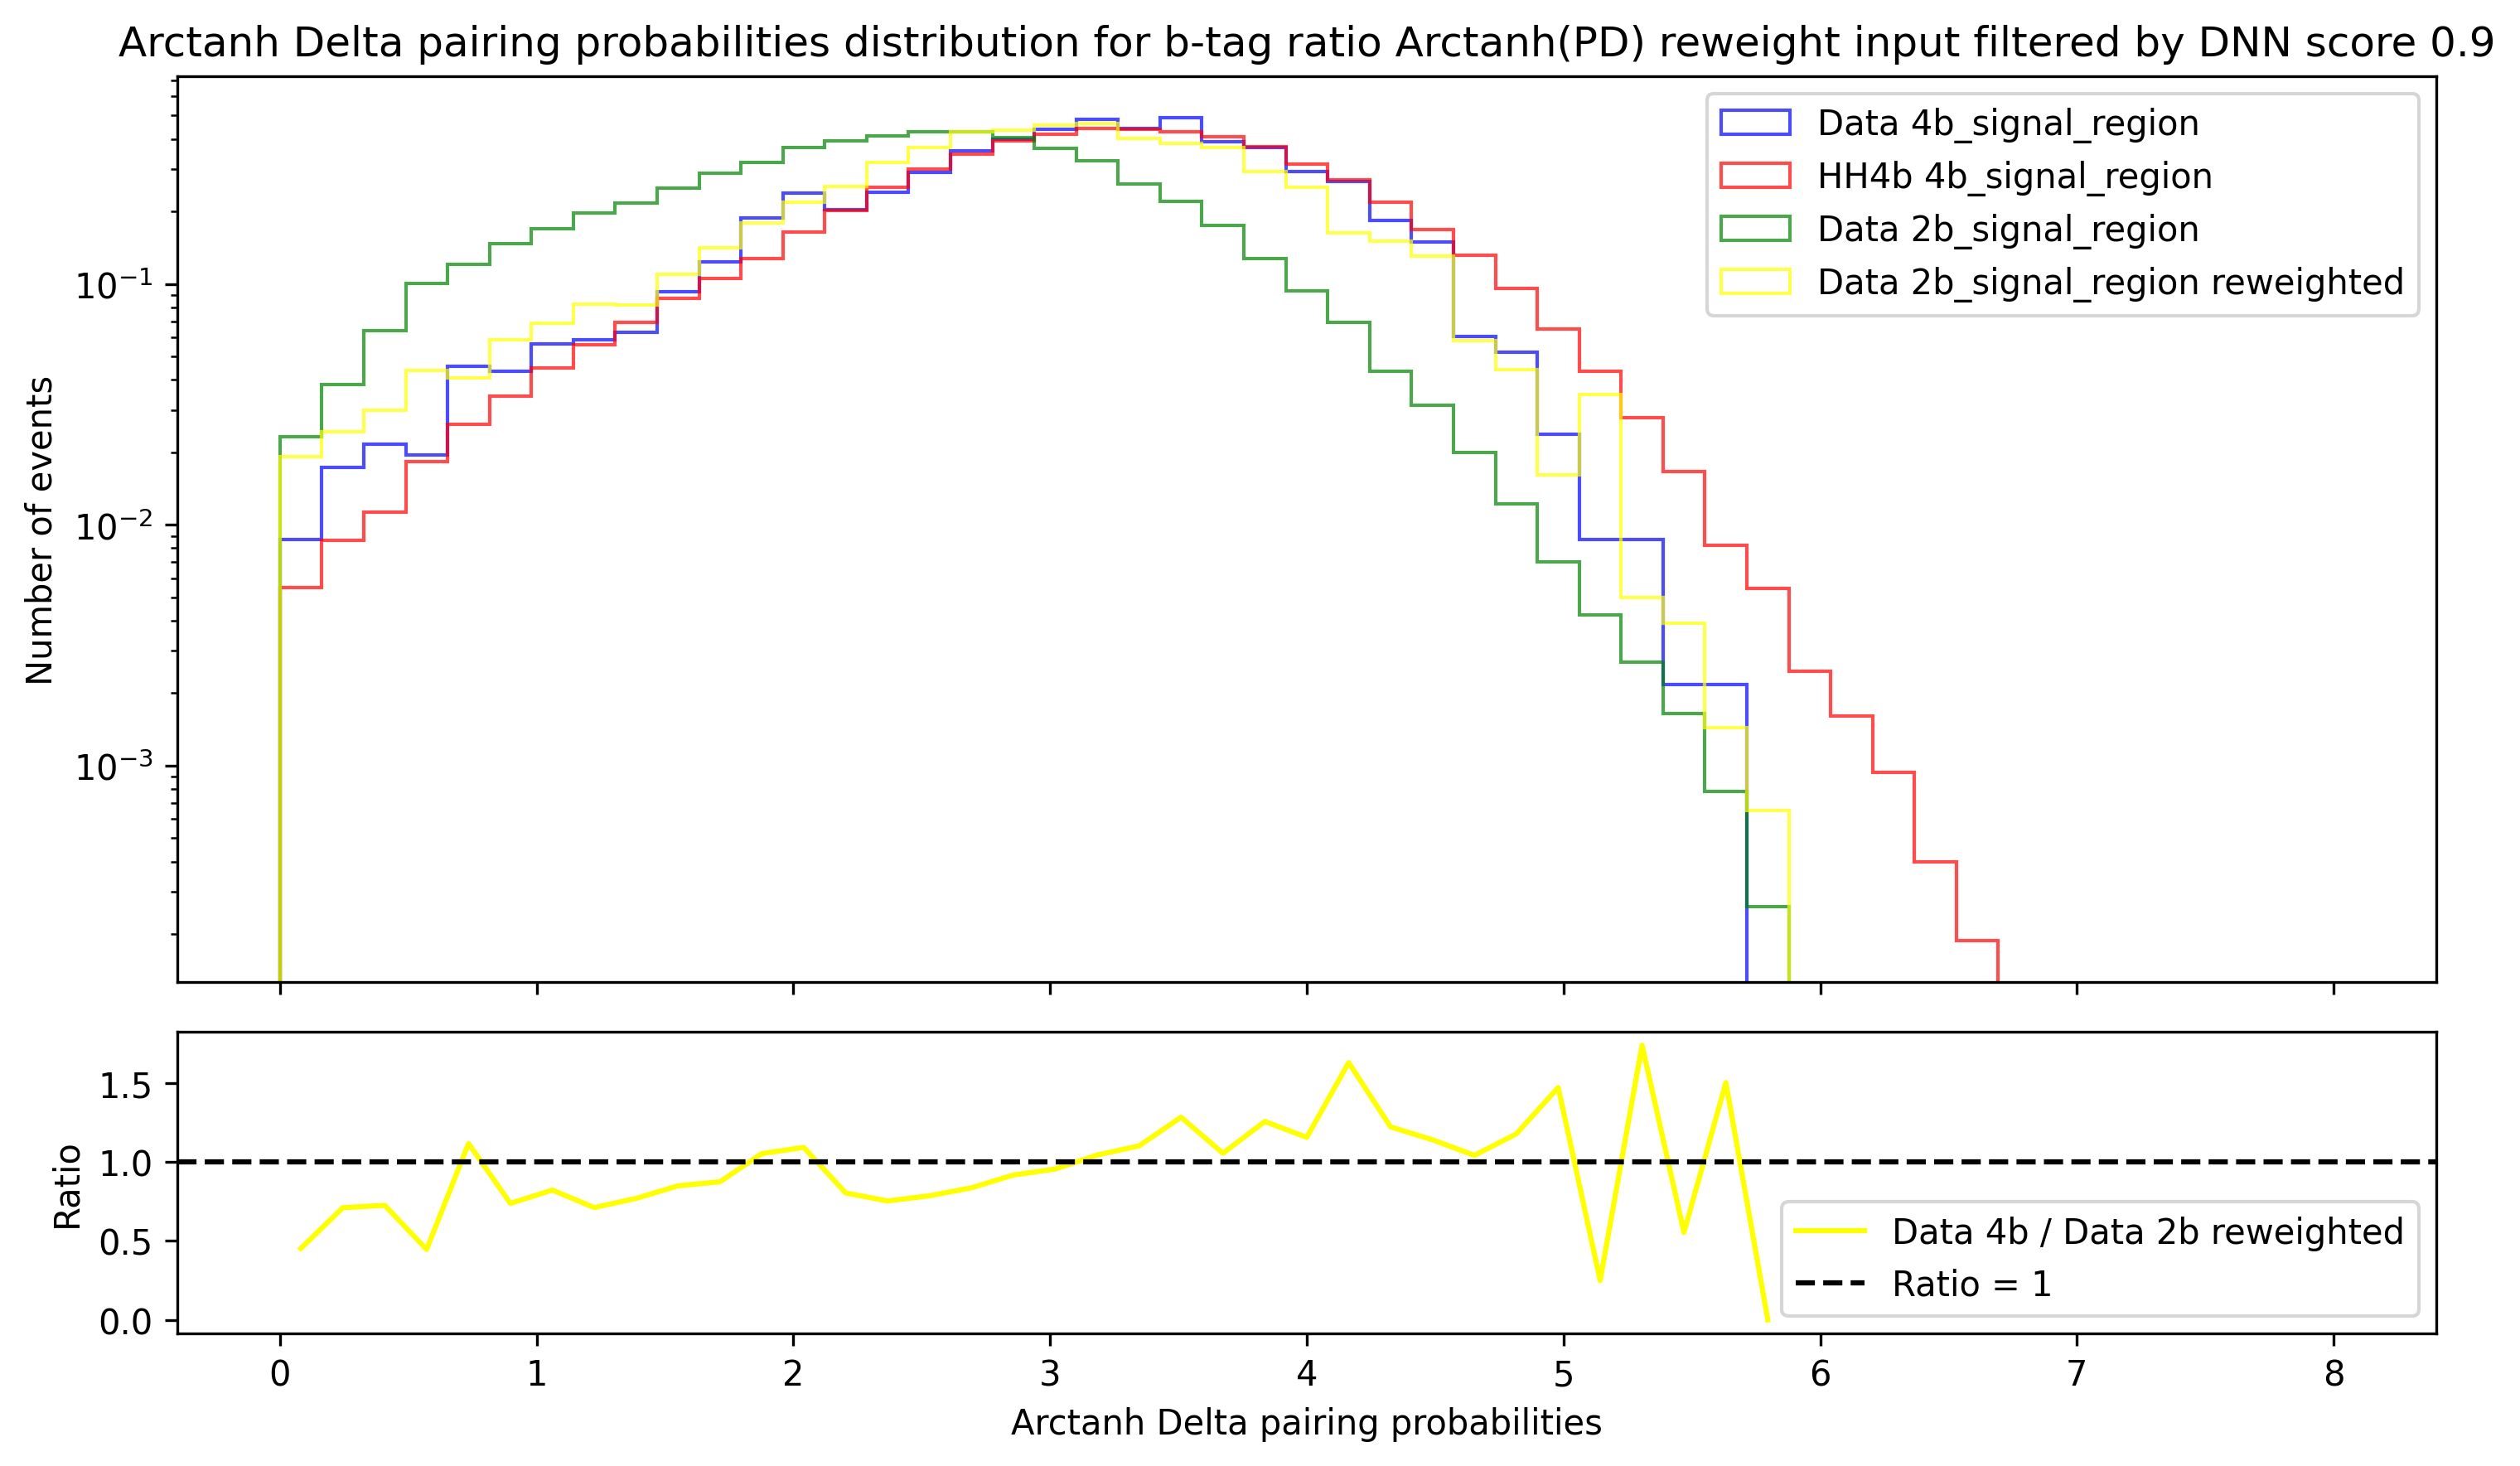

2830


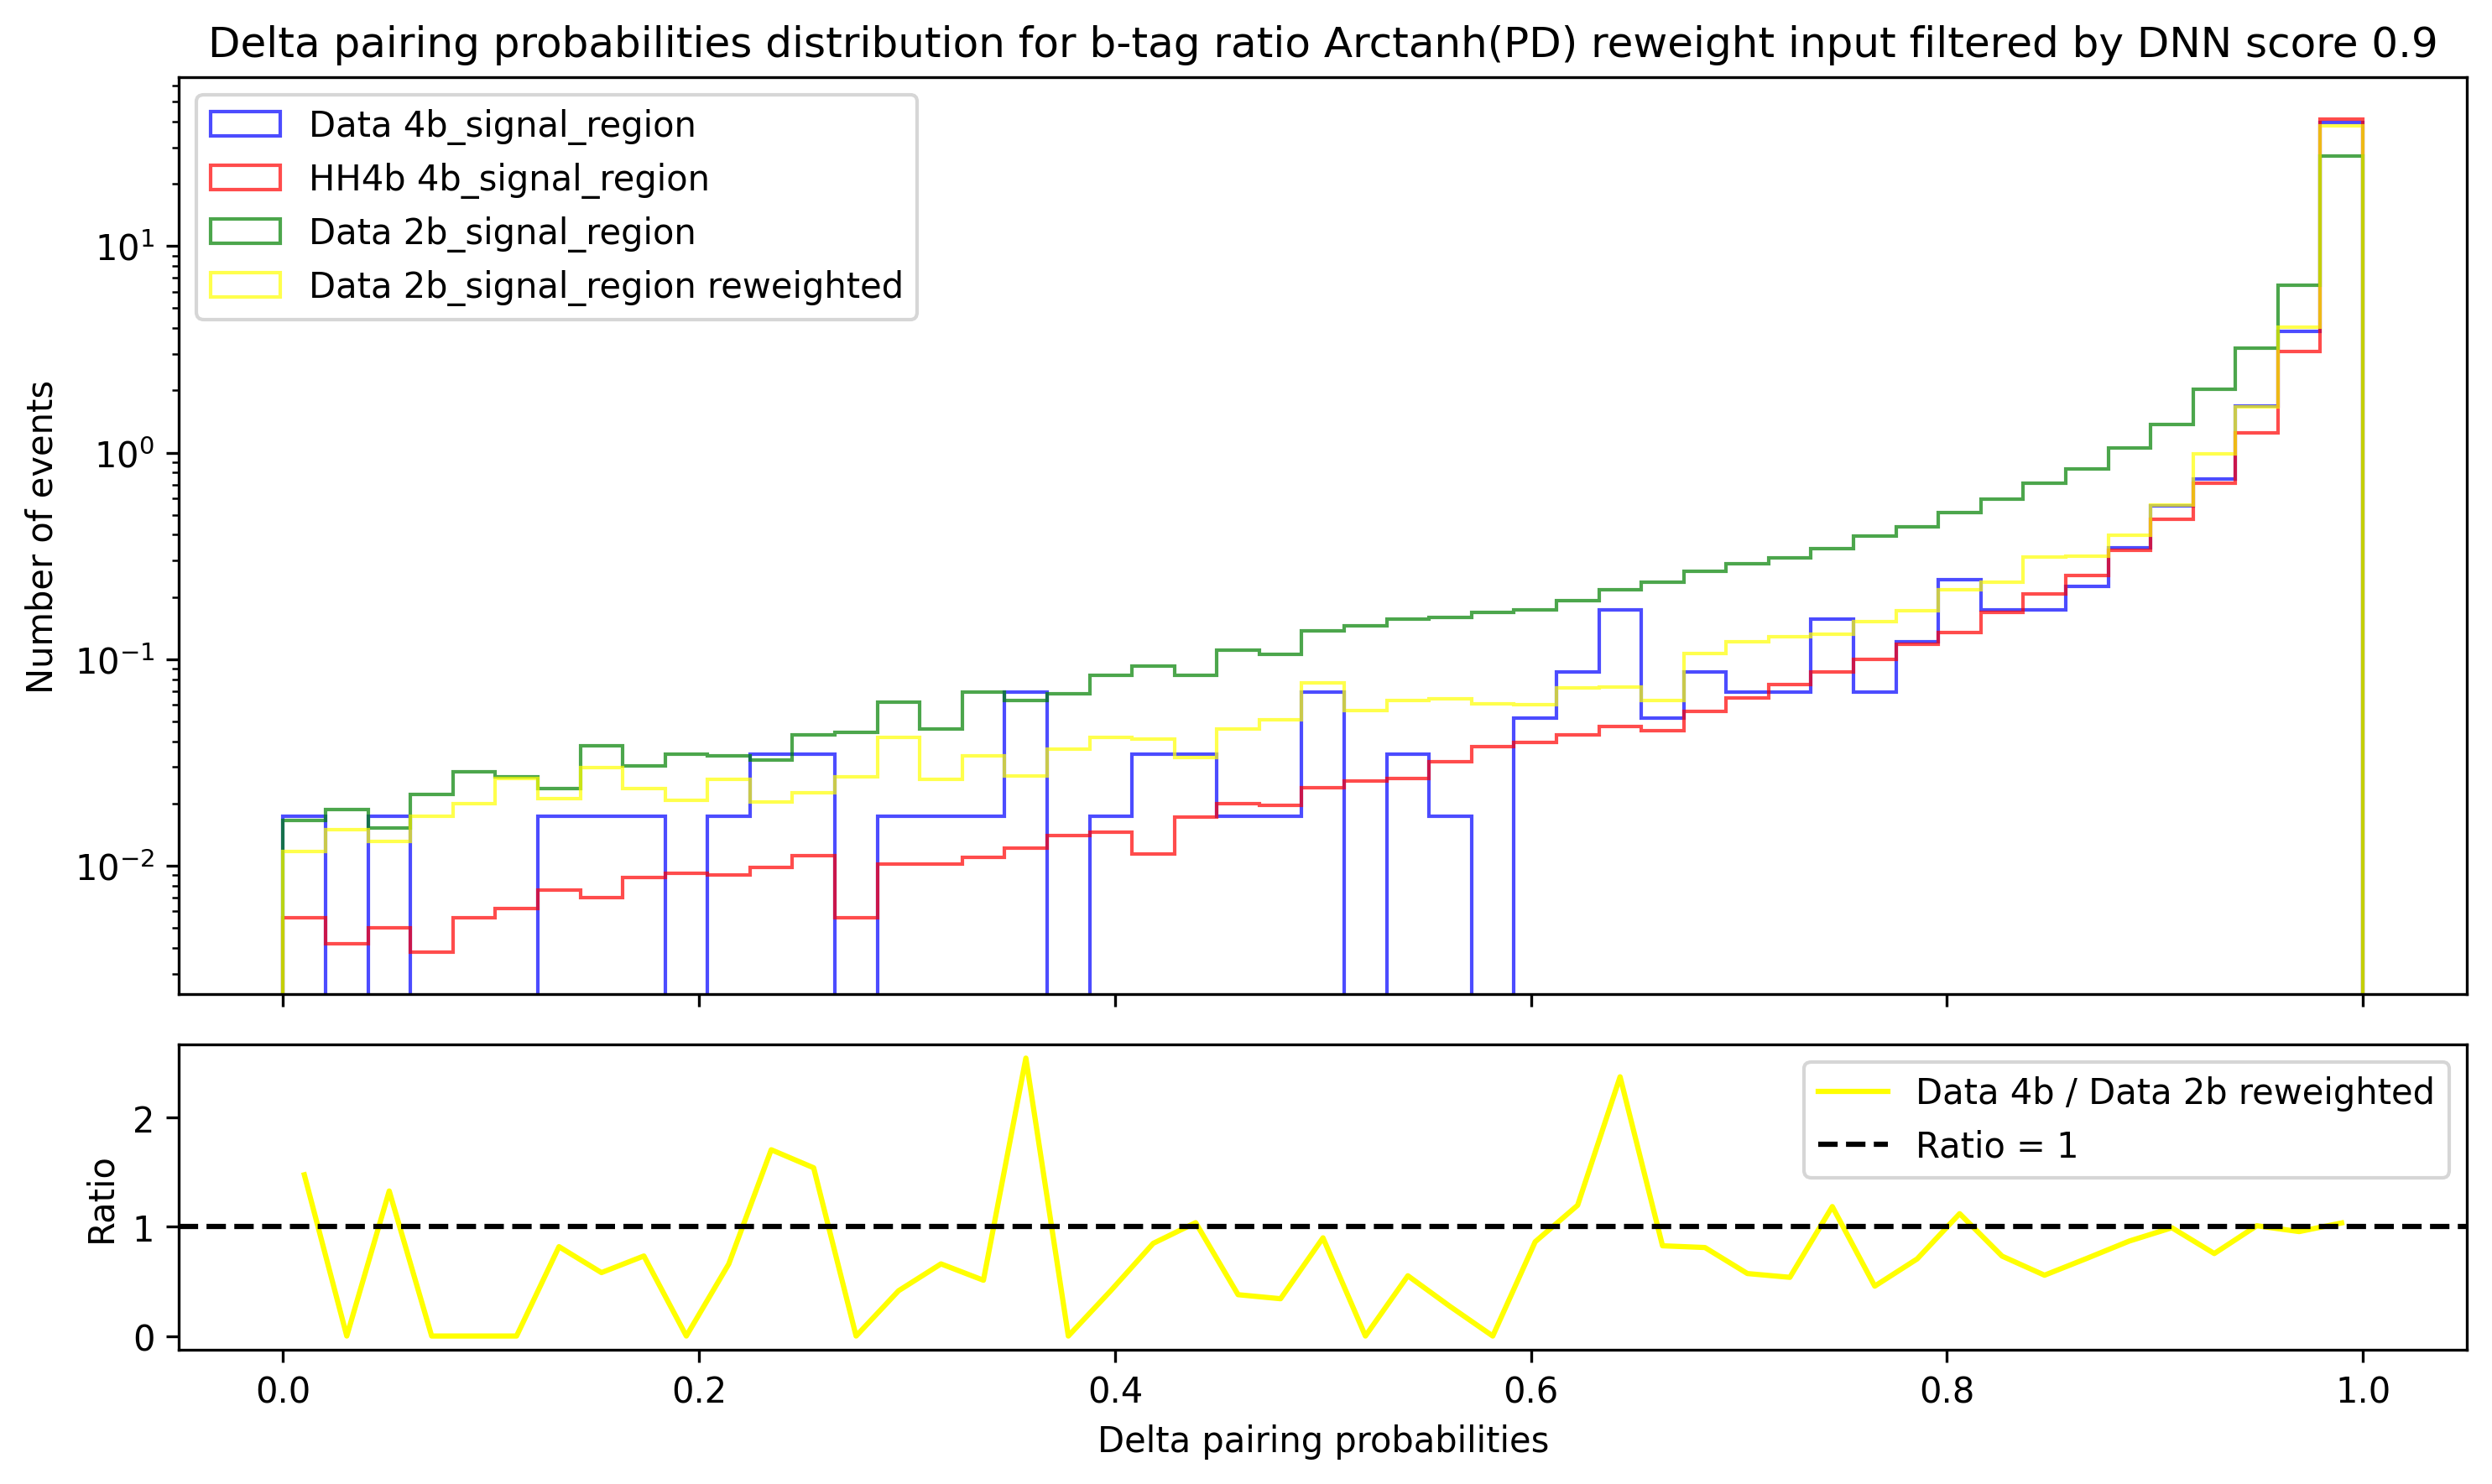

2830


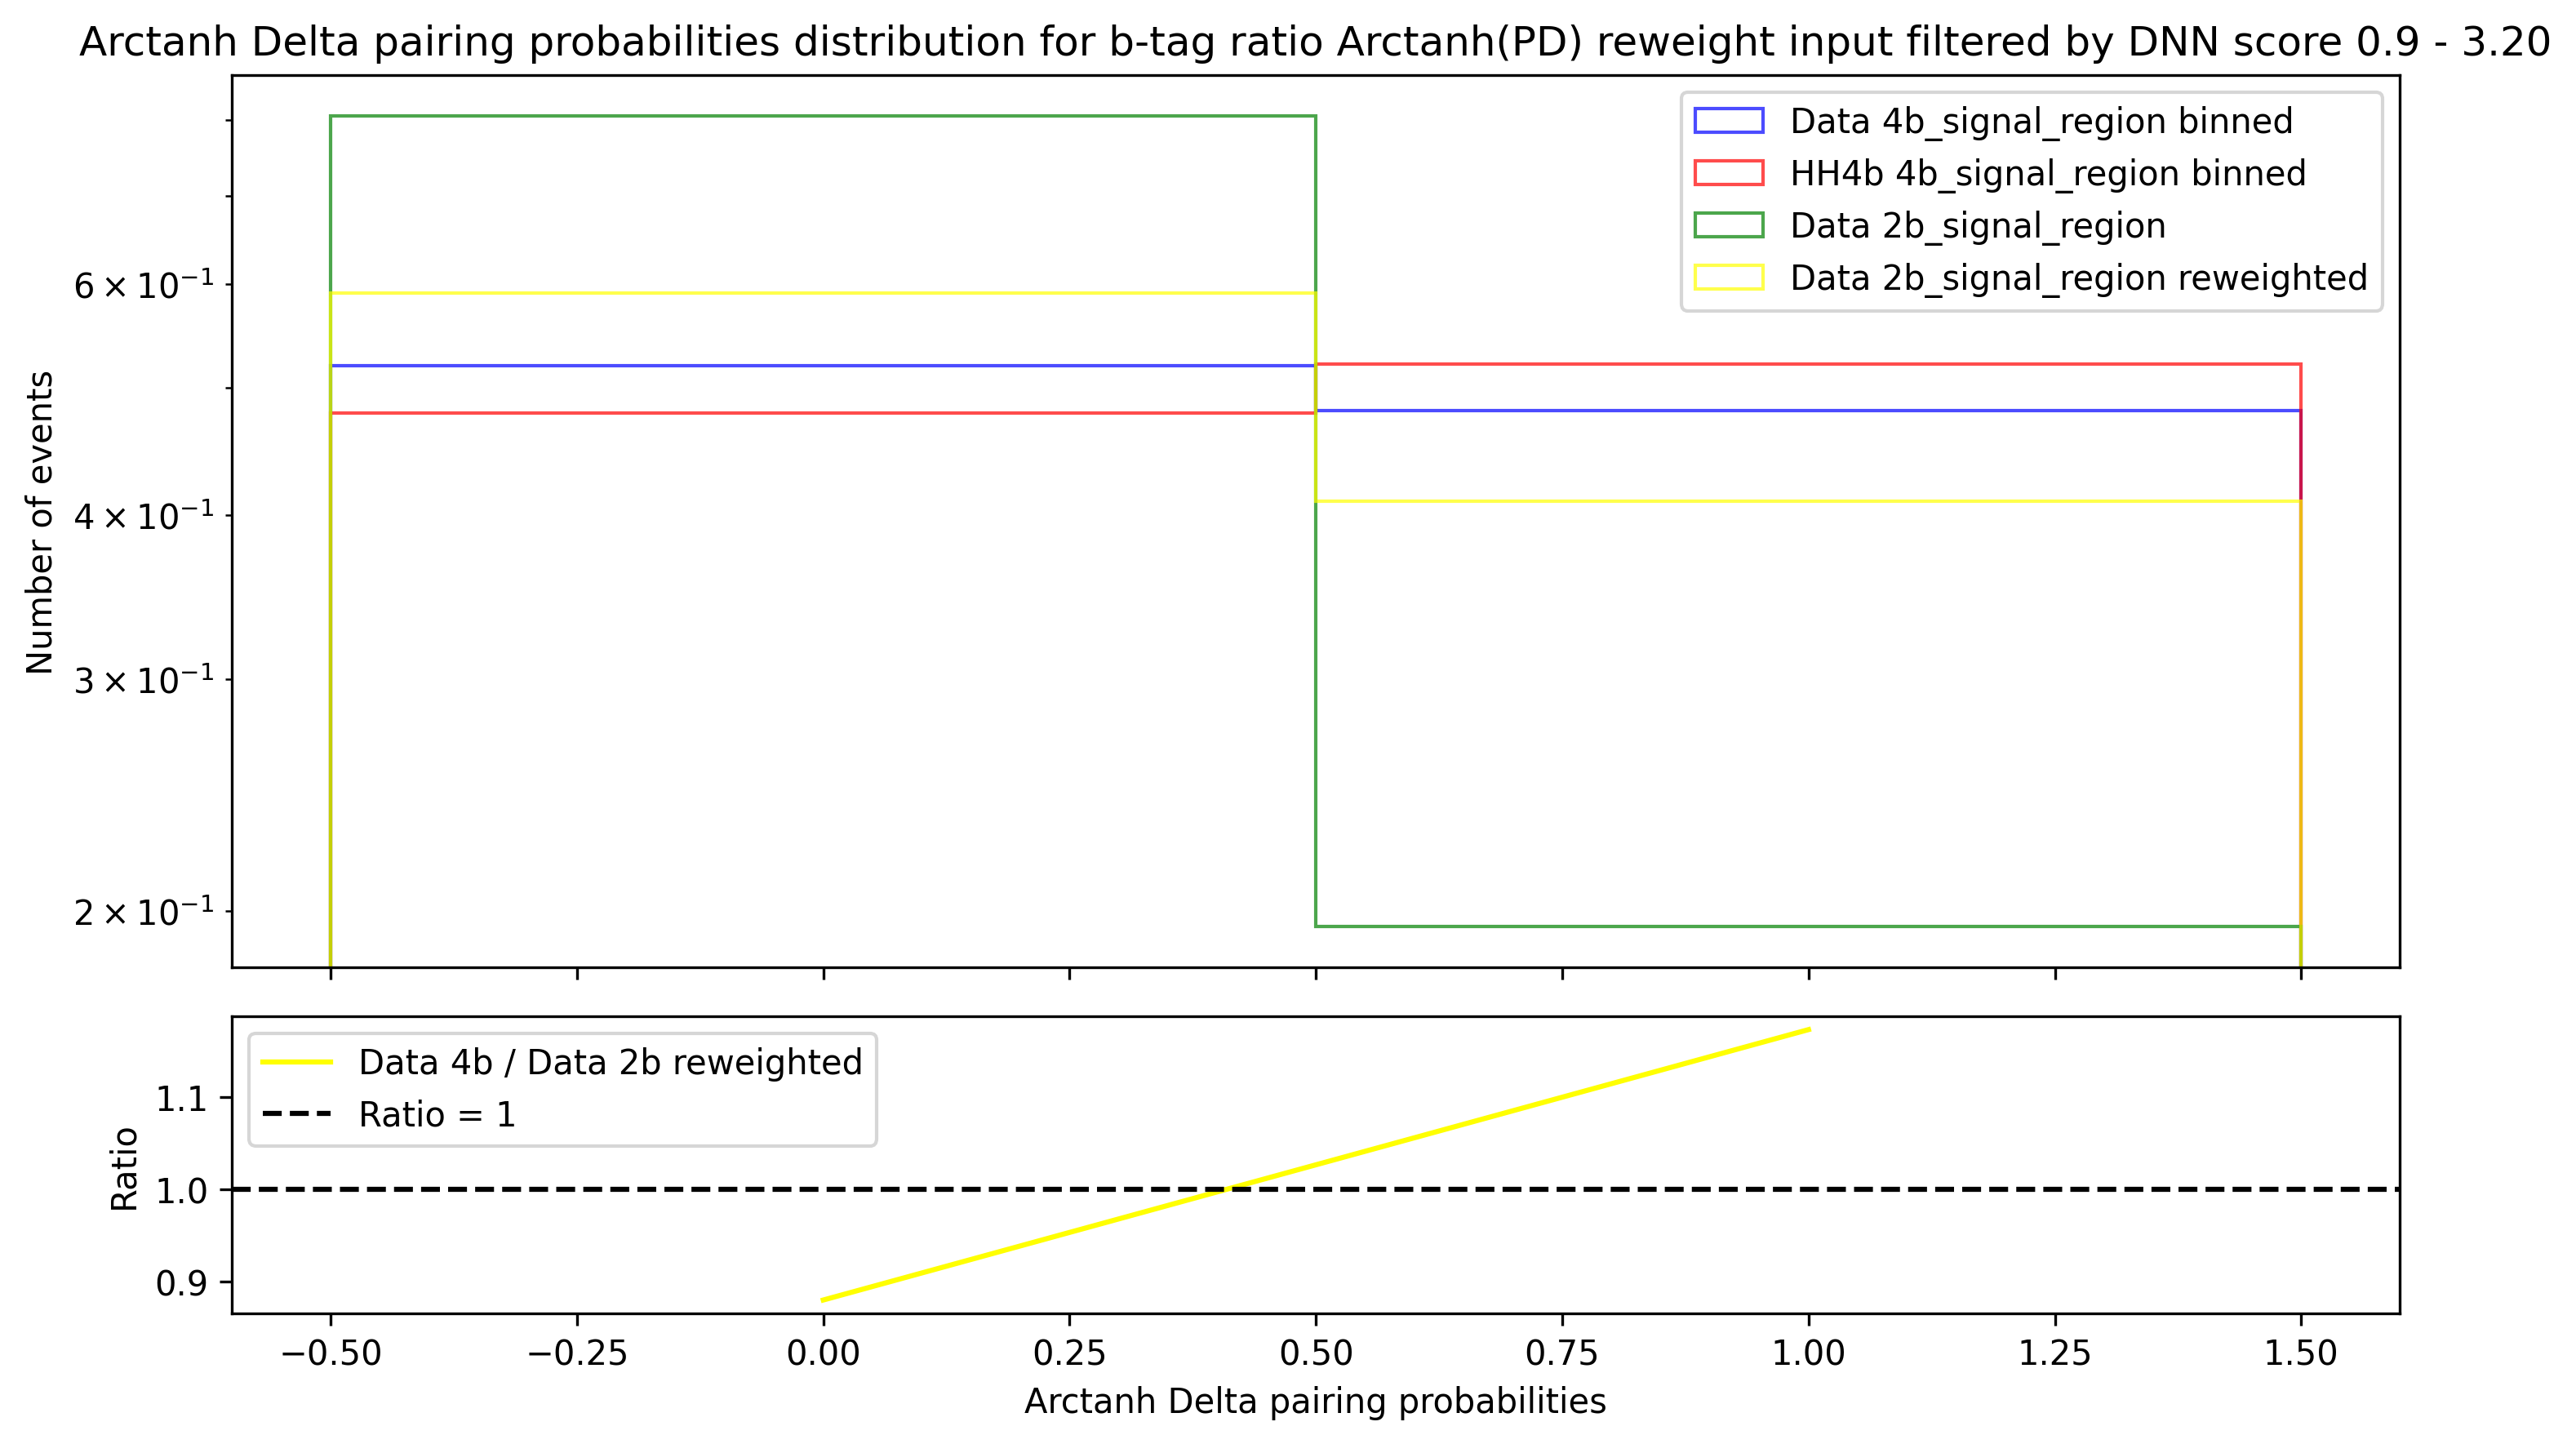

Region signal plotted
Data: DATA_JetMET_JMENano DATA_JetMET_JMENano_2022_postEE
MC: GluGlutoHHto4B_spanet GluGlutoHHto4B_spanet_kl-1p00_kt-1p00_c2-0p00_2022_postEE
777


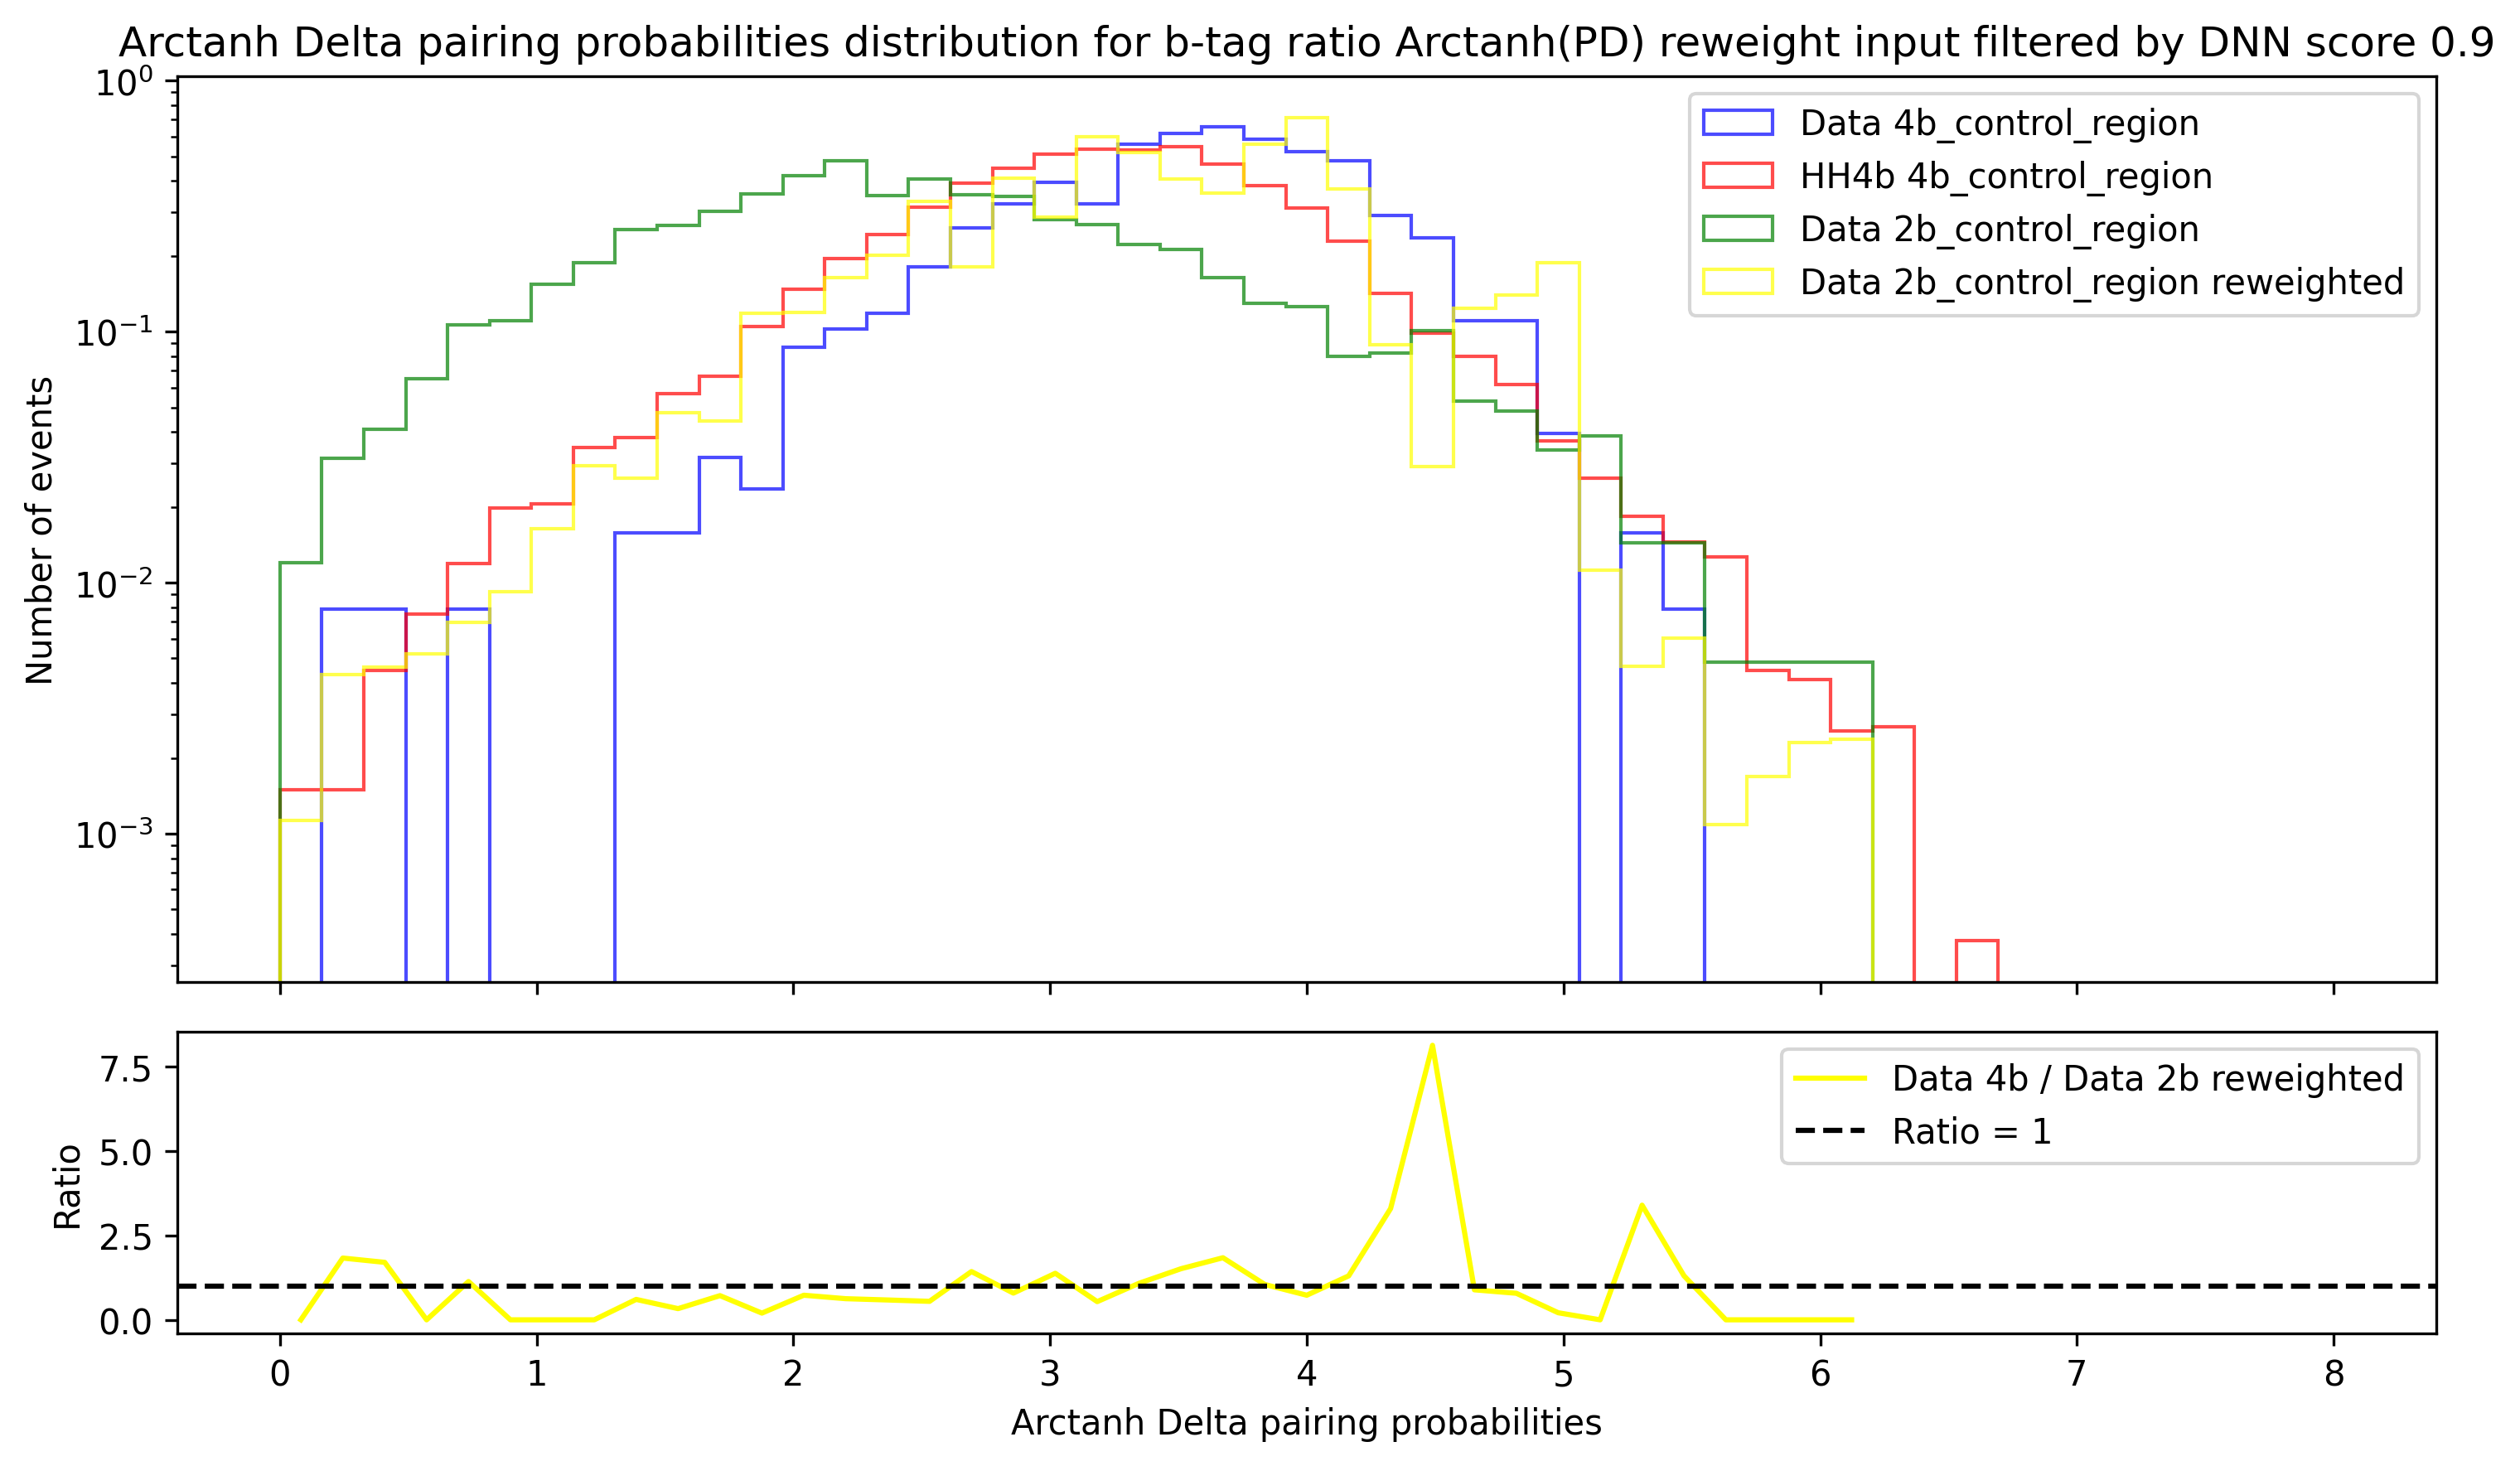

777


/tmp/ipykernel_1386628/2355170080.py:43: RuntimeWarning: divide by zero encountered in divide
  ratio_d = hist_d / hist_m
/tmp/ipykernel_1386628/2355170080.py:44: RuntimeWarning: divide by zero encountered in divide
  ratio_d2 = hist_d / hist_d2
/tmp/ipykernel_1386628/2355170080.py:46: RuntimeWarning: divide by zero encountered in divide
  ratio_d2_rw = hist_d / hist_d2_rw


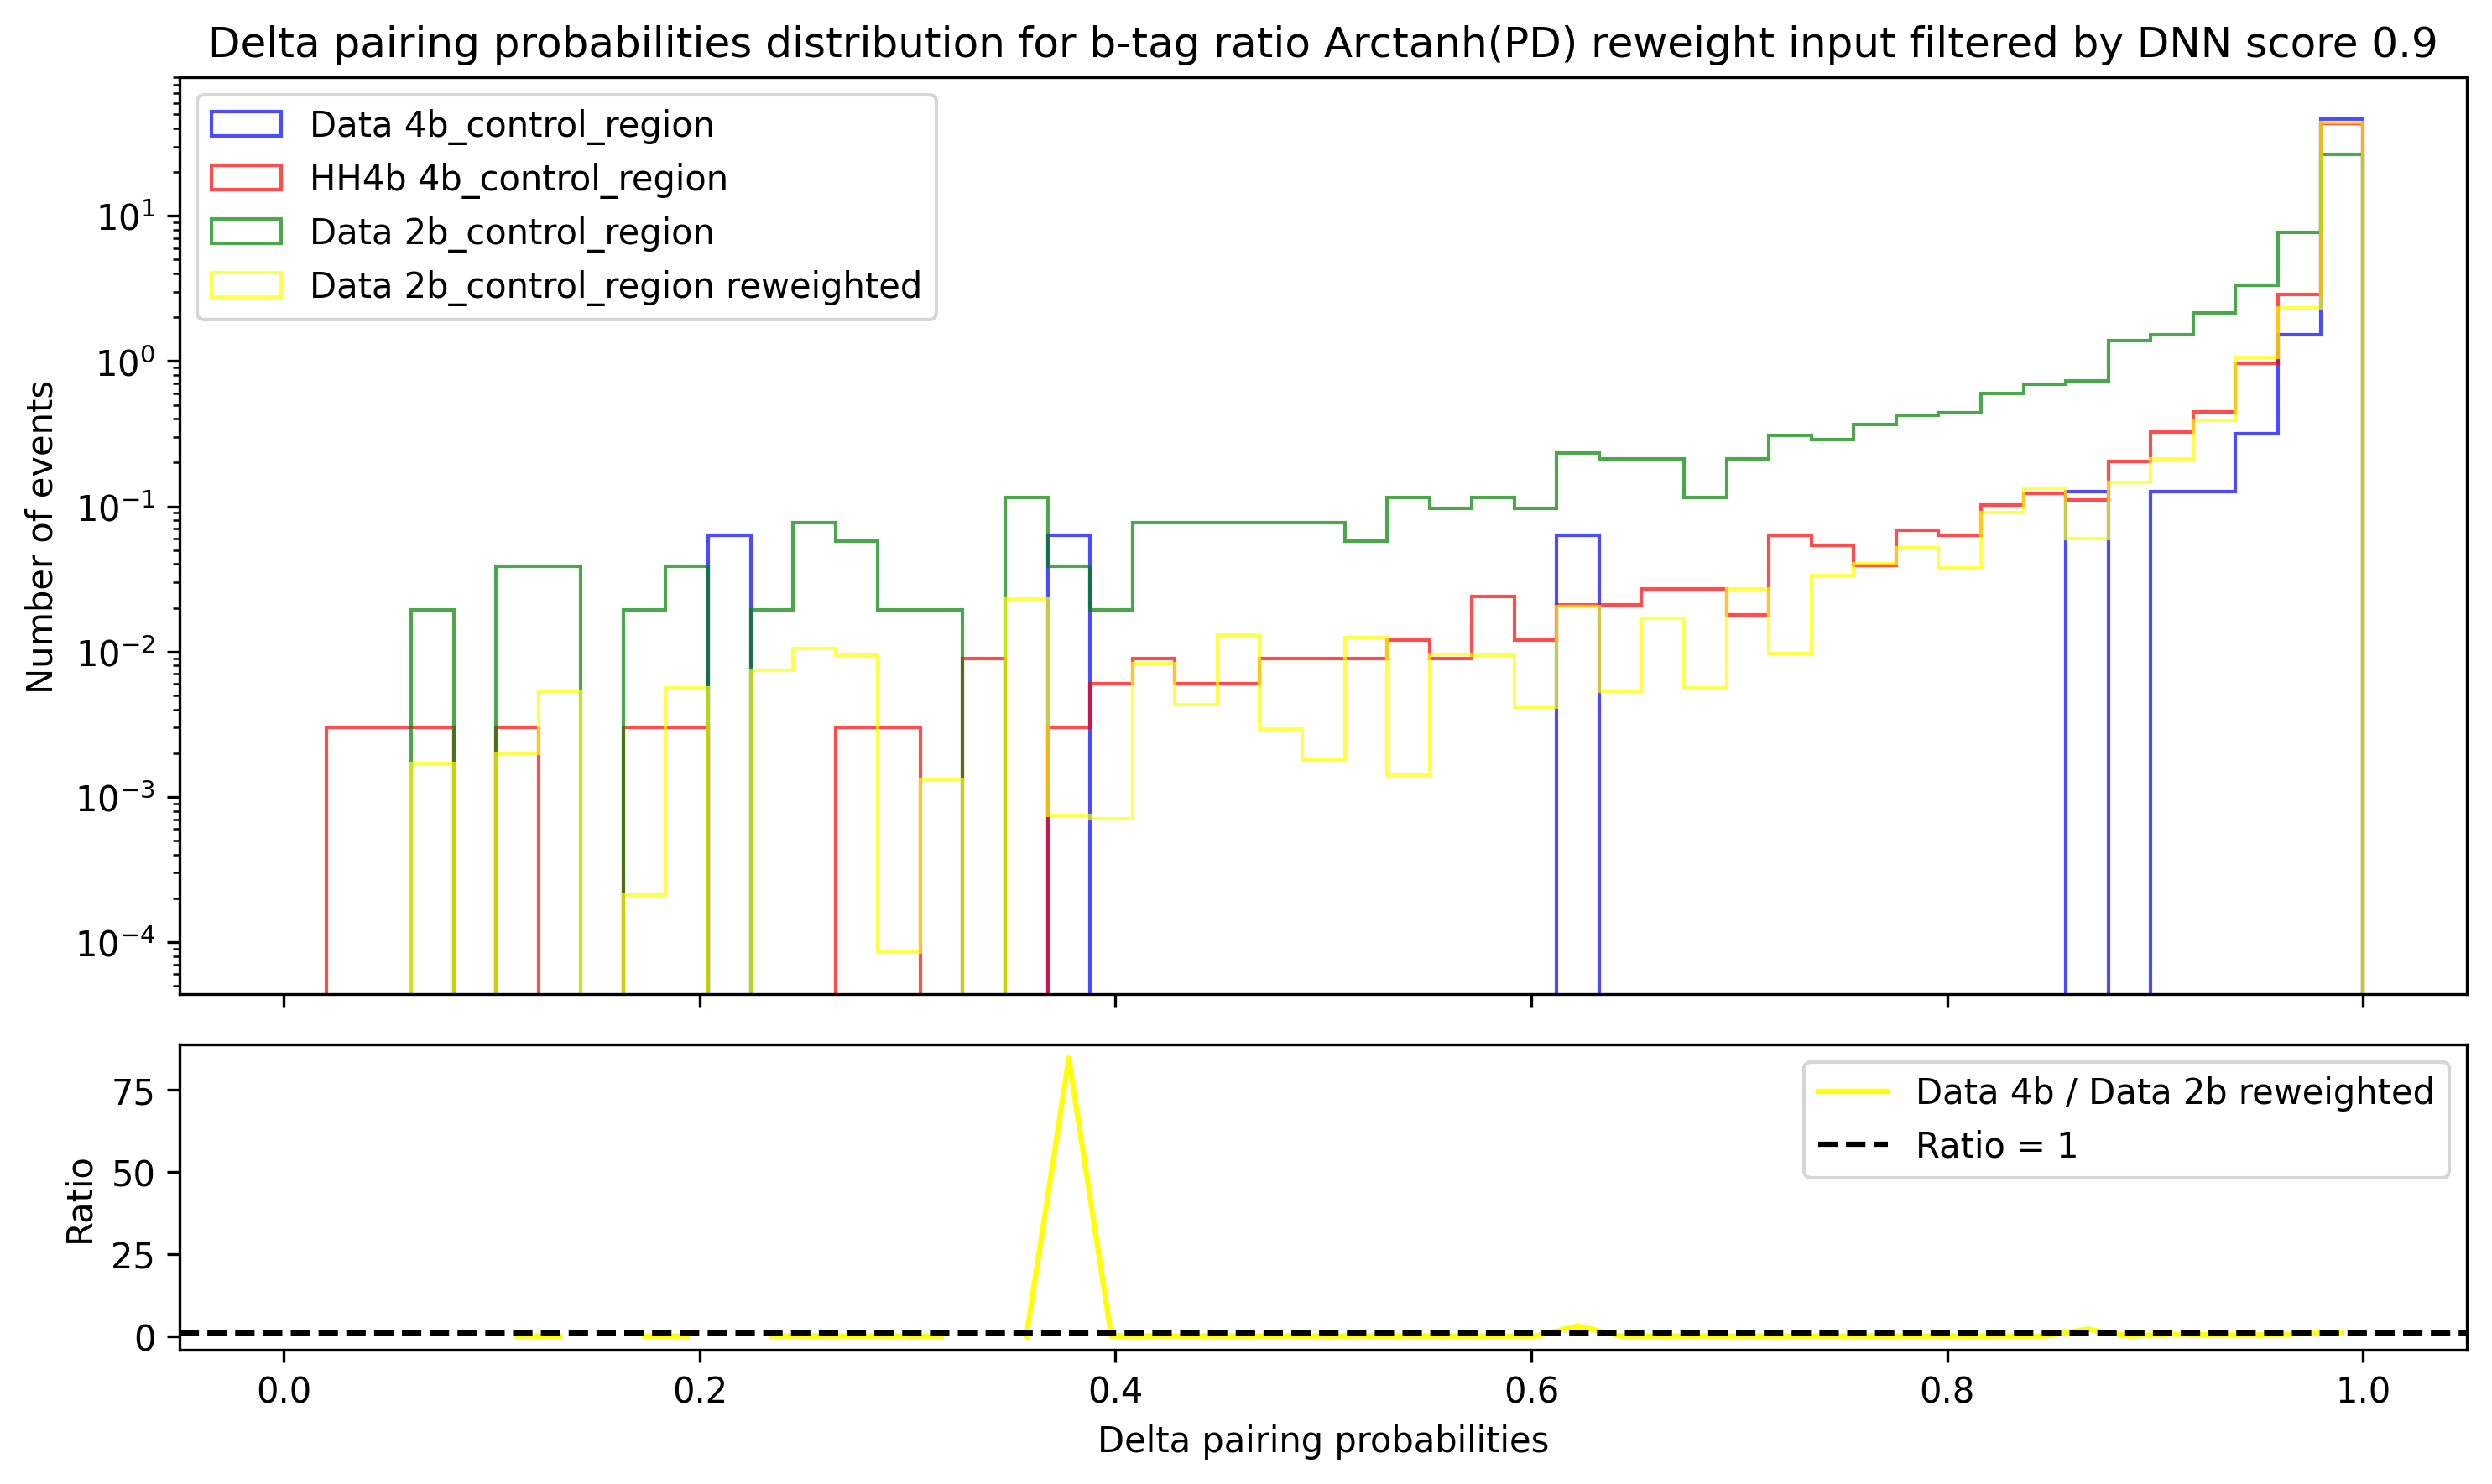

777


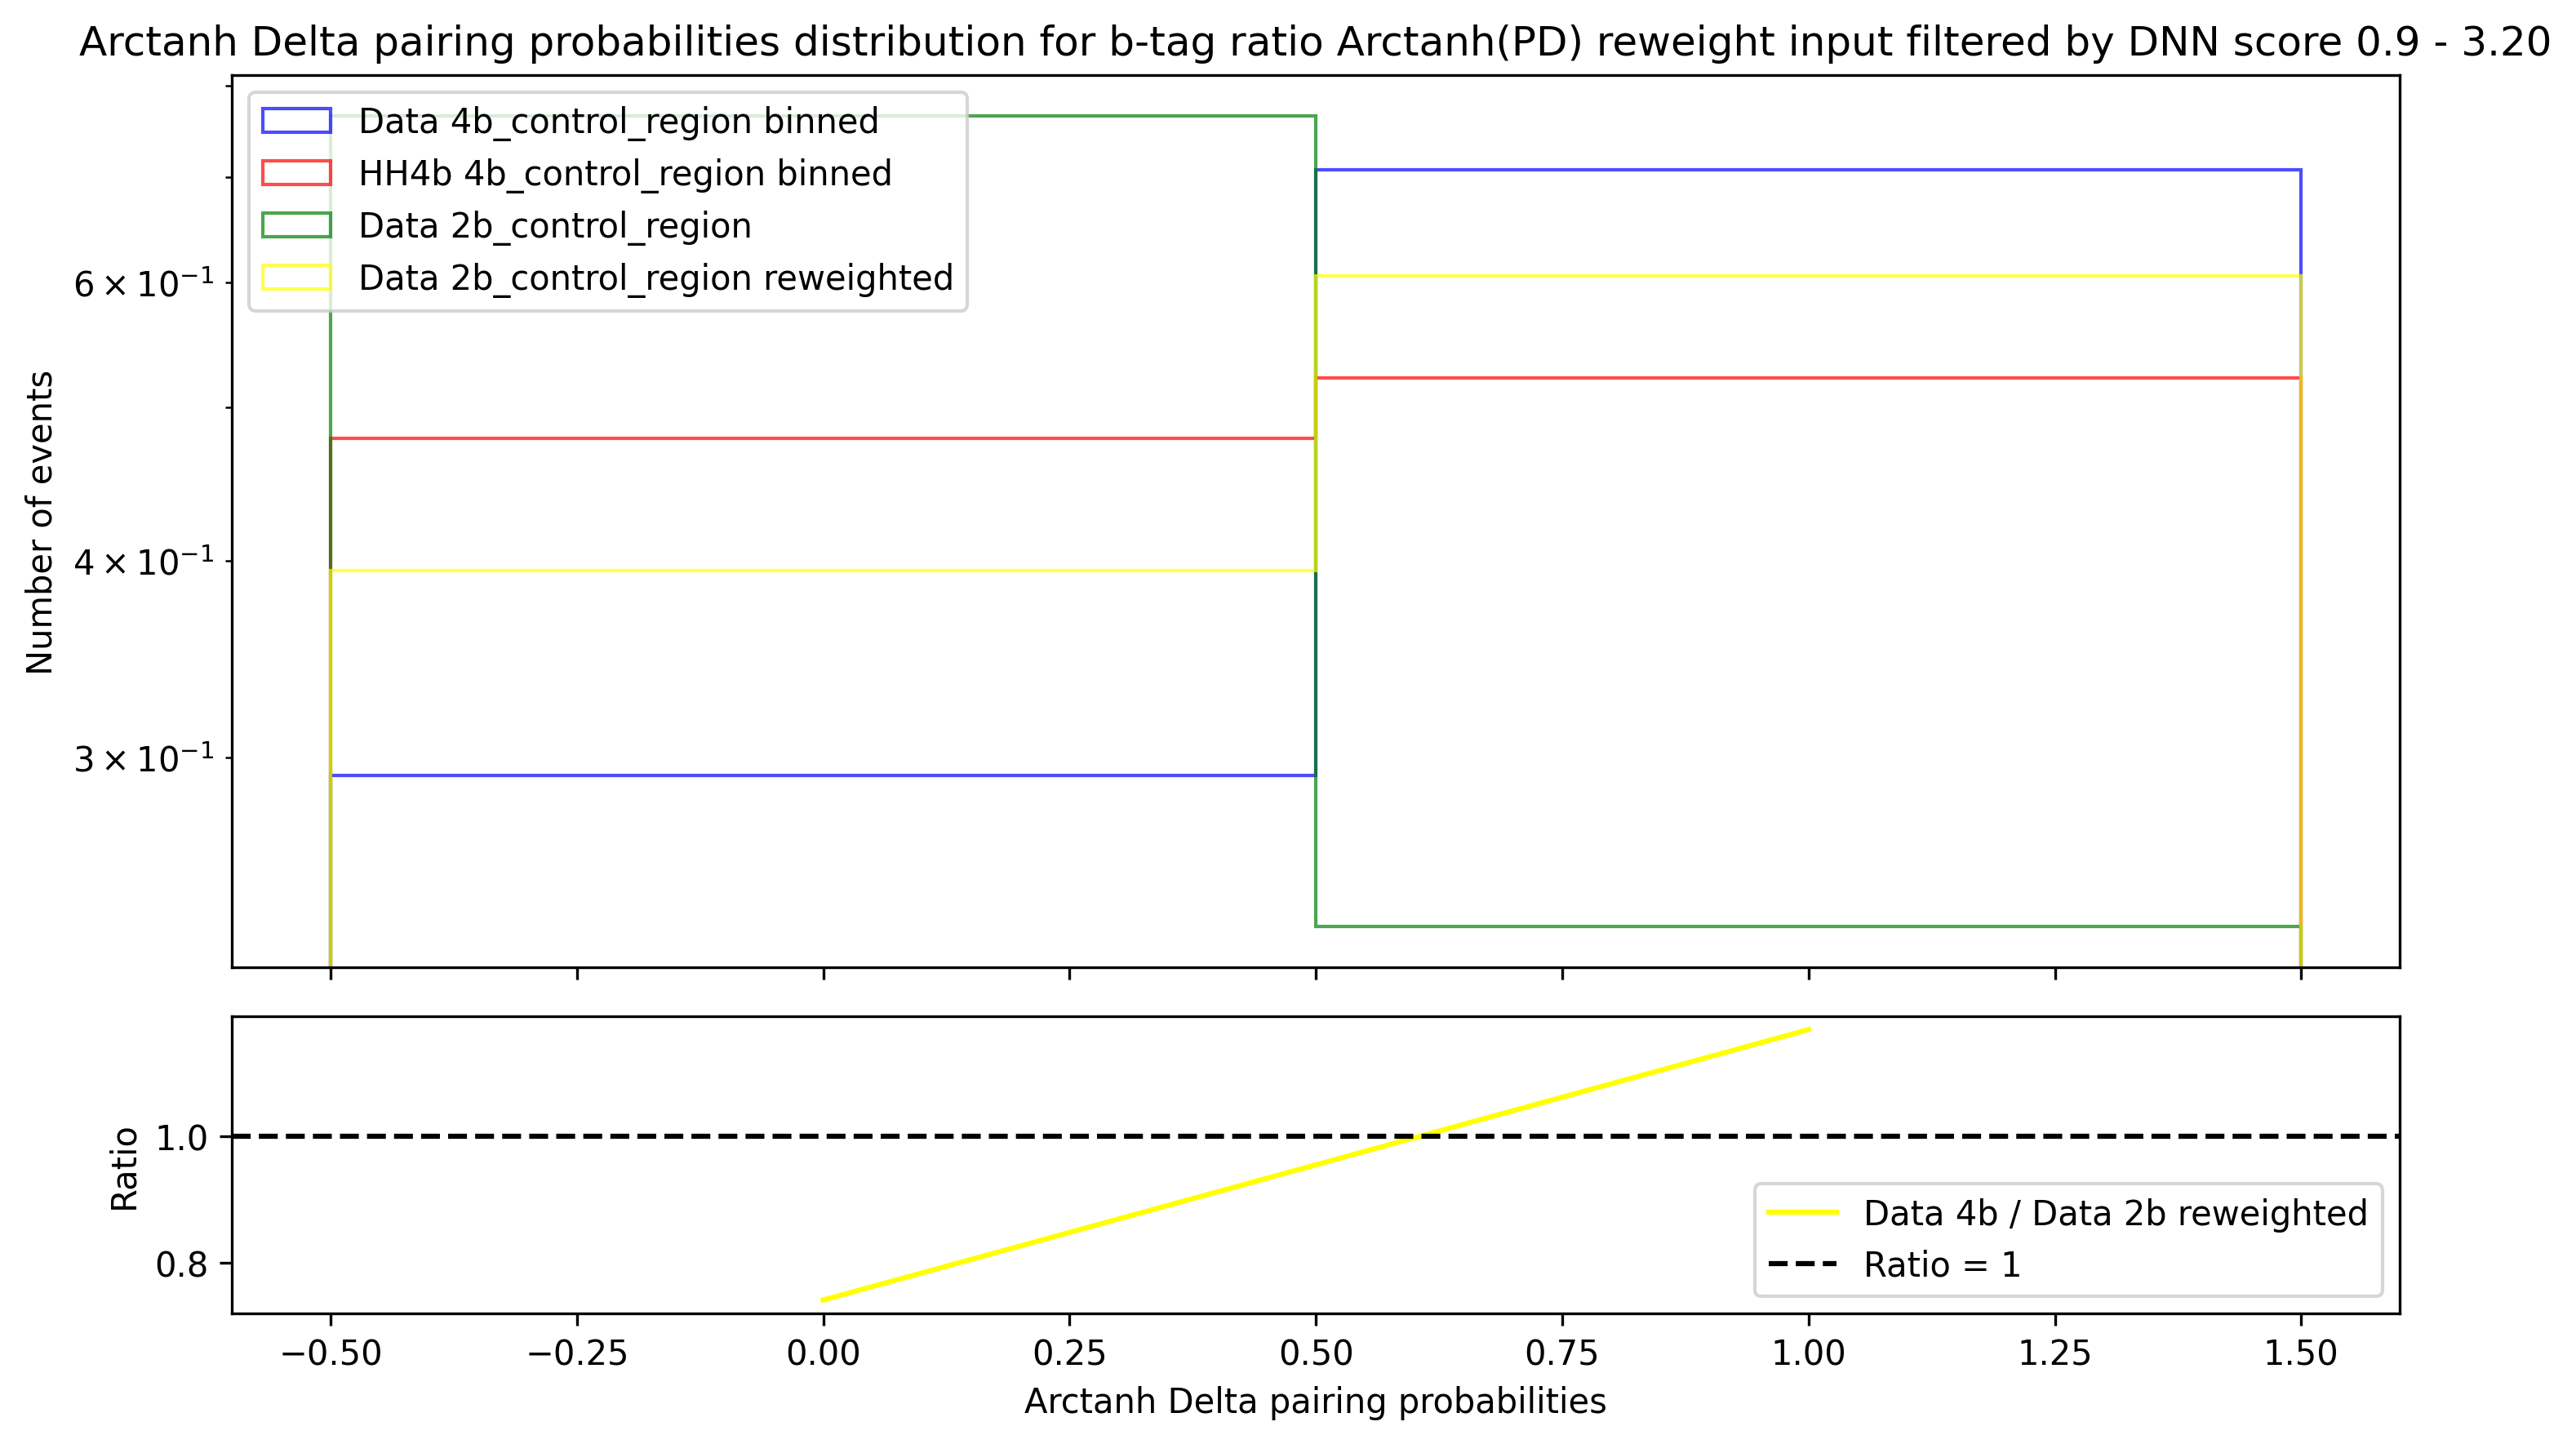

Region control plotted


In [57]:
#input_data = "/work/mmalucch/out_hh4b/SigBkg/out_2022postEE_ggFSPANetDataset_SPANETptVary0p3_1p7_Morphing_DNN_AN_1e-3_e20drop75_minDelta1em5_SPANet_only2022postEE_noEarlyStopping_20folds_DeltaProbabilityMorphing_SigBkg_DNN_ptFlatSPANet_class_weights_e5drop75_postEE_DeltaProbability/output_DATA_JetMET_JMENano_G_2022_postEE_EraG.coffea"
#input_mc = "/work/mmalucch/out_hh4b/SigBkg/out_2022postEE_ggFSPANetDataset_SPANETptVary0p3_1p7_Morphing_DNN_AN_1e-3_e20drop75_minDelta1em5_SPANet_only2022postEE_noEarlyStopping_20folds_DeltaProbabilityMorphing_SigBkg_DNN_ptFlatSPANet_class_weights_e5drop75_postEE_DeltaProbability/output_GluGlutoHHto4B_spanet_kl-1p00_kt-1p00_c2-0p00_2022_postEE.coffea"
input_data = ["/work/tharte/datasets/sig_bkg_classifier/spanet_ptflat_inclusive_b_trained_bratio_ArctanhDeltaProb/output_DATA_JetMET_JMENano_E_2022_postEE_EraE.coffea", "/work/tharte/datasets/sig_bkg_classifier/spanet_ptflat_inclusive_b_trained_bratio_ArctanhDeltaProb/output_DATA_JetMET_JMENano_F_2022_postEE_EraF.coffea", "/work/tharte/datasets/sig_bkg_classifier/spanet_ptflat_inclusive_b_trained_bratio_ArctanhDeltaProb/output_DATA_JetMET_JMENano_G_2022_postEE_EraG.coffea"]
input_mc = ["/work/tharte/datasets/sig_bkg_classifier/spanet_ptflat_inclusive_b_trained_bratio_ArctanhDeltaProb/output_GluGlutoHHto4B_spanet_kl-1p00_kt-1p00_c2-0p00_2022_postEE.coffea"]
title = "b-tag ratio Arctanh(PD) reweight input filtered by DNN score 0.9"

for region in ["signal", "control"]:
    category_4 = f"4b_{region}_region"
    category_2 = f"2b_{region}_region_postW"
    
    adp_d, adp_m, adp_d2, weights_m, weights_d2 = get_cols(input_data, input_mc, category_4, category_2, filter_dnn_score=True)
    plot_distribution(adp_d, adp_m, adp_d2, weights_m, weights_d2, title, category_4, category_2,np.linspace(0, 8, 50))
    plot_distribution(adp_d, adp_m, adp_d2, weights_m, weights_d2, title, category_4, category_2,np.linspace(0, 1, 50), tanh=True)
    
    arctanh_delta_prob_bin_edges=[-0.2, edge, 20]
    bin_adp_d=np.digitize(adp_d, arctanh_delta_prob_bin_edges)-1
    bin_adp_m=np.digitize(adp_m, arctanh_delta_prob_bin_edges)-1
    bin_adp_d2=np.digitize(adp_d2, arctanh_delta_prob_bin_edges)-1
    plot_distribution(
        bin_adp_d, bin_adp_m, bin_adp_d2, weights_m, weights_d2, f"{title} - {edge:.2f}", category_4 + " binned", category_2 + " binned", [-0.5, 0.5, 1.5]
    )
    print(f"Region {region} plotted")


## b-tag model without any PD input 

Data: DATA_JetMET_JMENano_G_skimmed DATA_JetMET_JMENano_G_2022_postEE_EraG
MC: GluGlutoHHto4B_spanet GluGlutoHHto4B_spanet_kl-1p00_kt-1p00_c2-0p00_2022_postEE
9018


/tmp/ipykernel_1160366/4143933197.py:43: RuntimeWarning: invalid value encountered in divide
  ratio_d = hist_d / hist_m
/tmp/ipykernel_1160366/4143933197.py:44: RuntimeWarning: divide by zero encountered in divide
  ratio_d2 = hist_d / hist_d2
/tmp/ipykernel_1160366/4143933197.py:44: RuntimeWarning: invalid value encountered in divide
  ratio_d2 = hist_d / hist_d2
/tmp/ipykernel_1160366/4143933197.py:46: RuntimeWarning: divide by zero encountered in divide
  ratio_d2_rw = hist_d / hist_d2_rw
/tmp/ipykernel_1160366/4143933197.py:46: RuntimeWarning: invalid value encountered in divide
  ratio_d2_rw = hist_d / hist_d2_rw


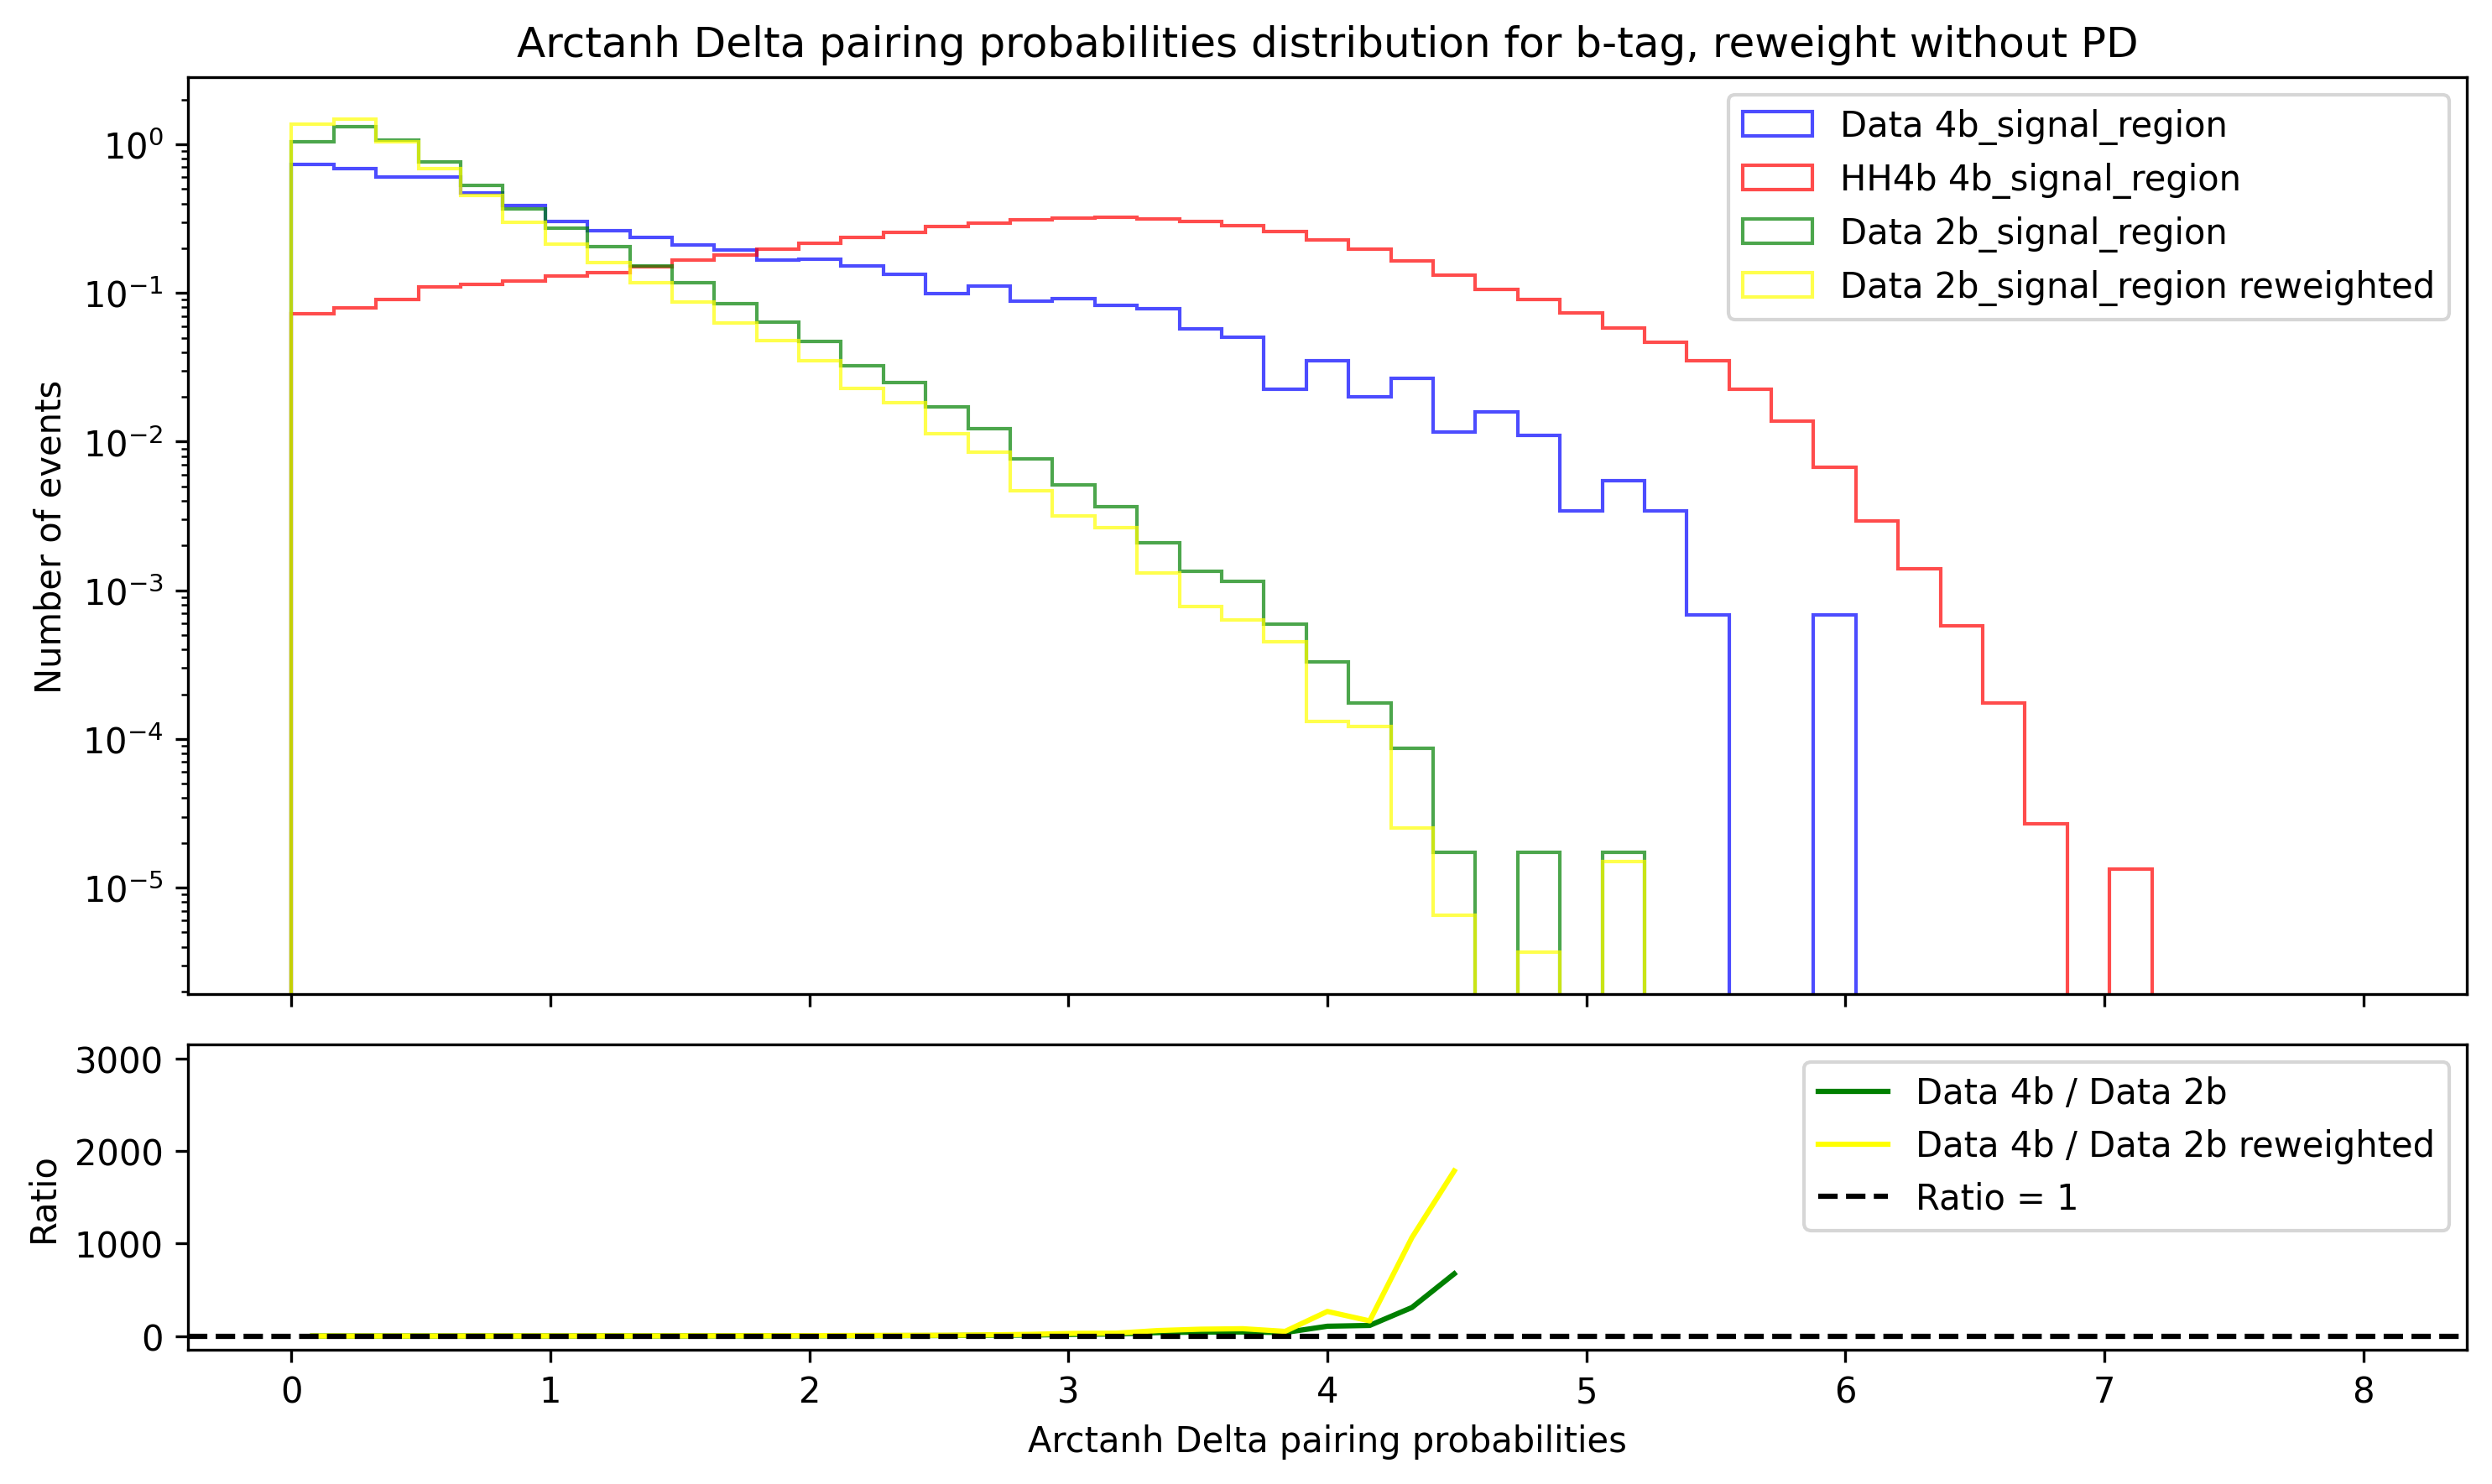

9018


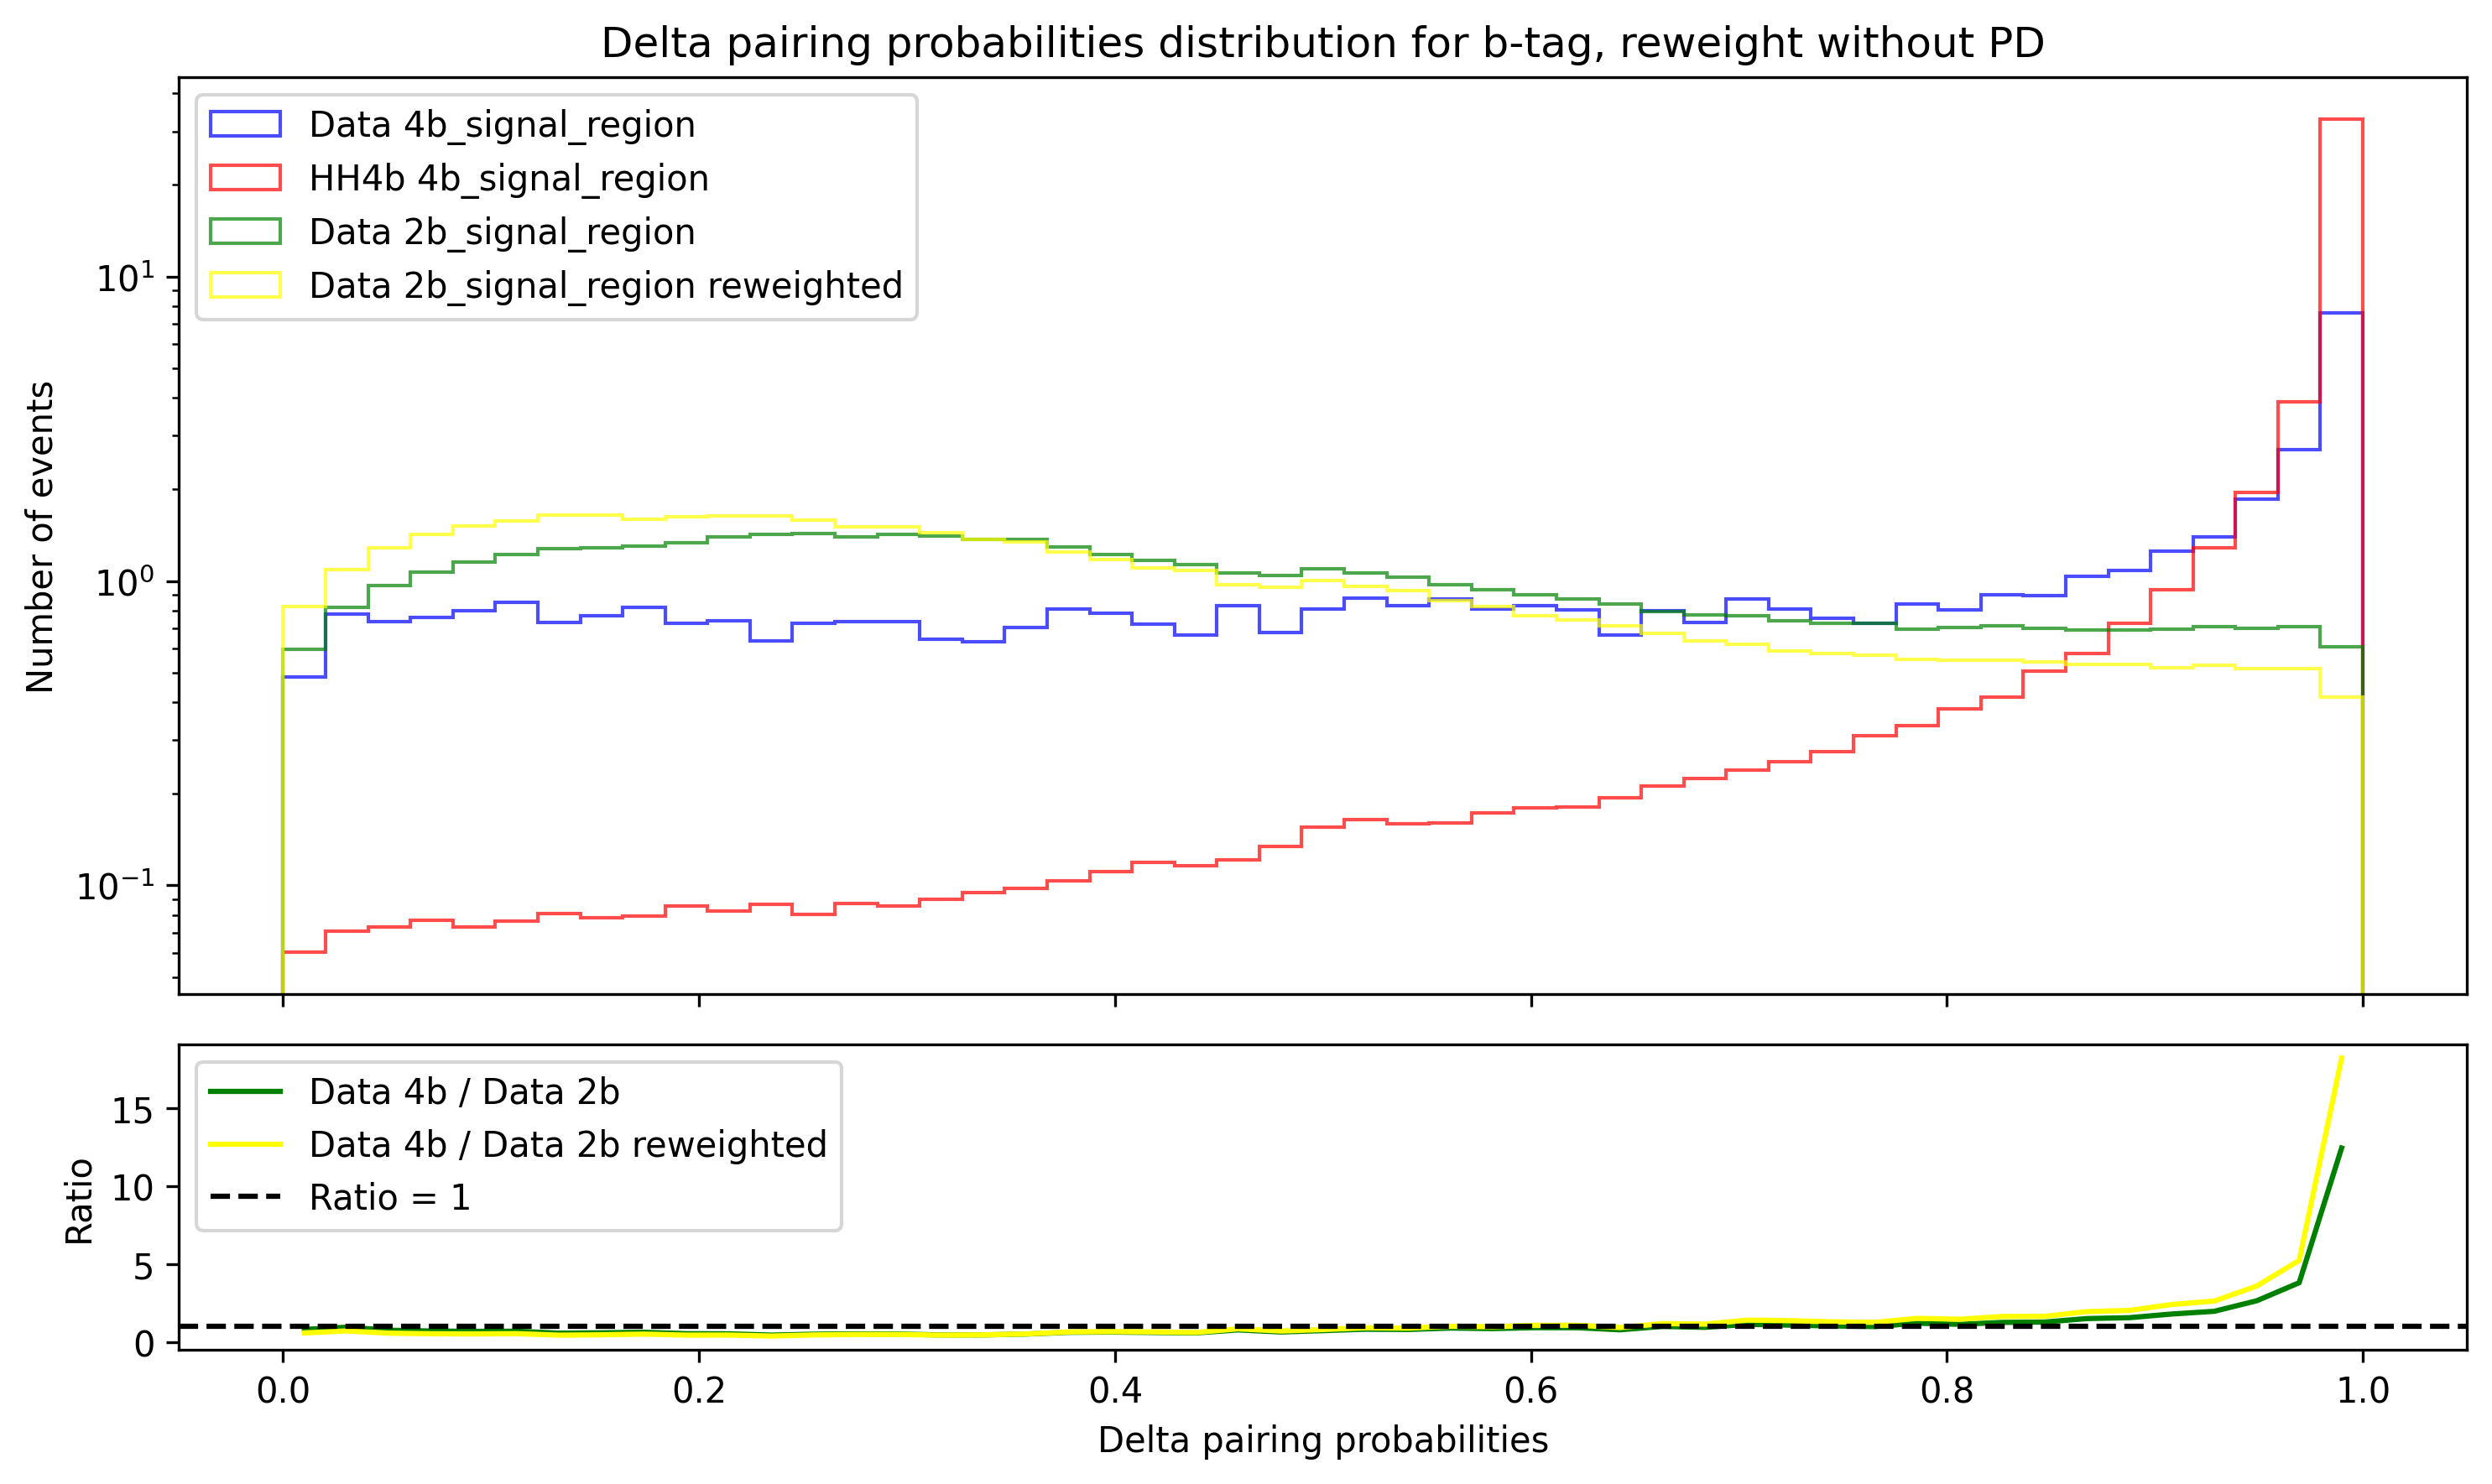

9018


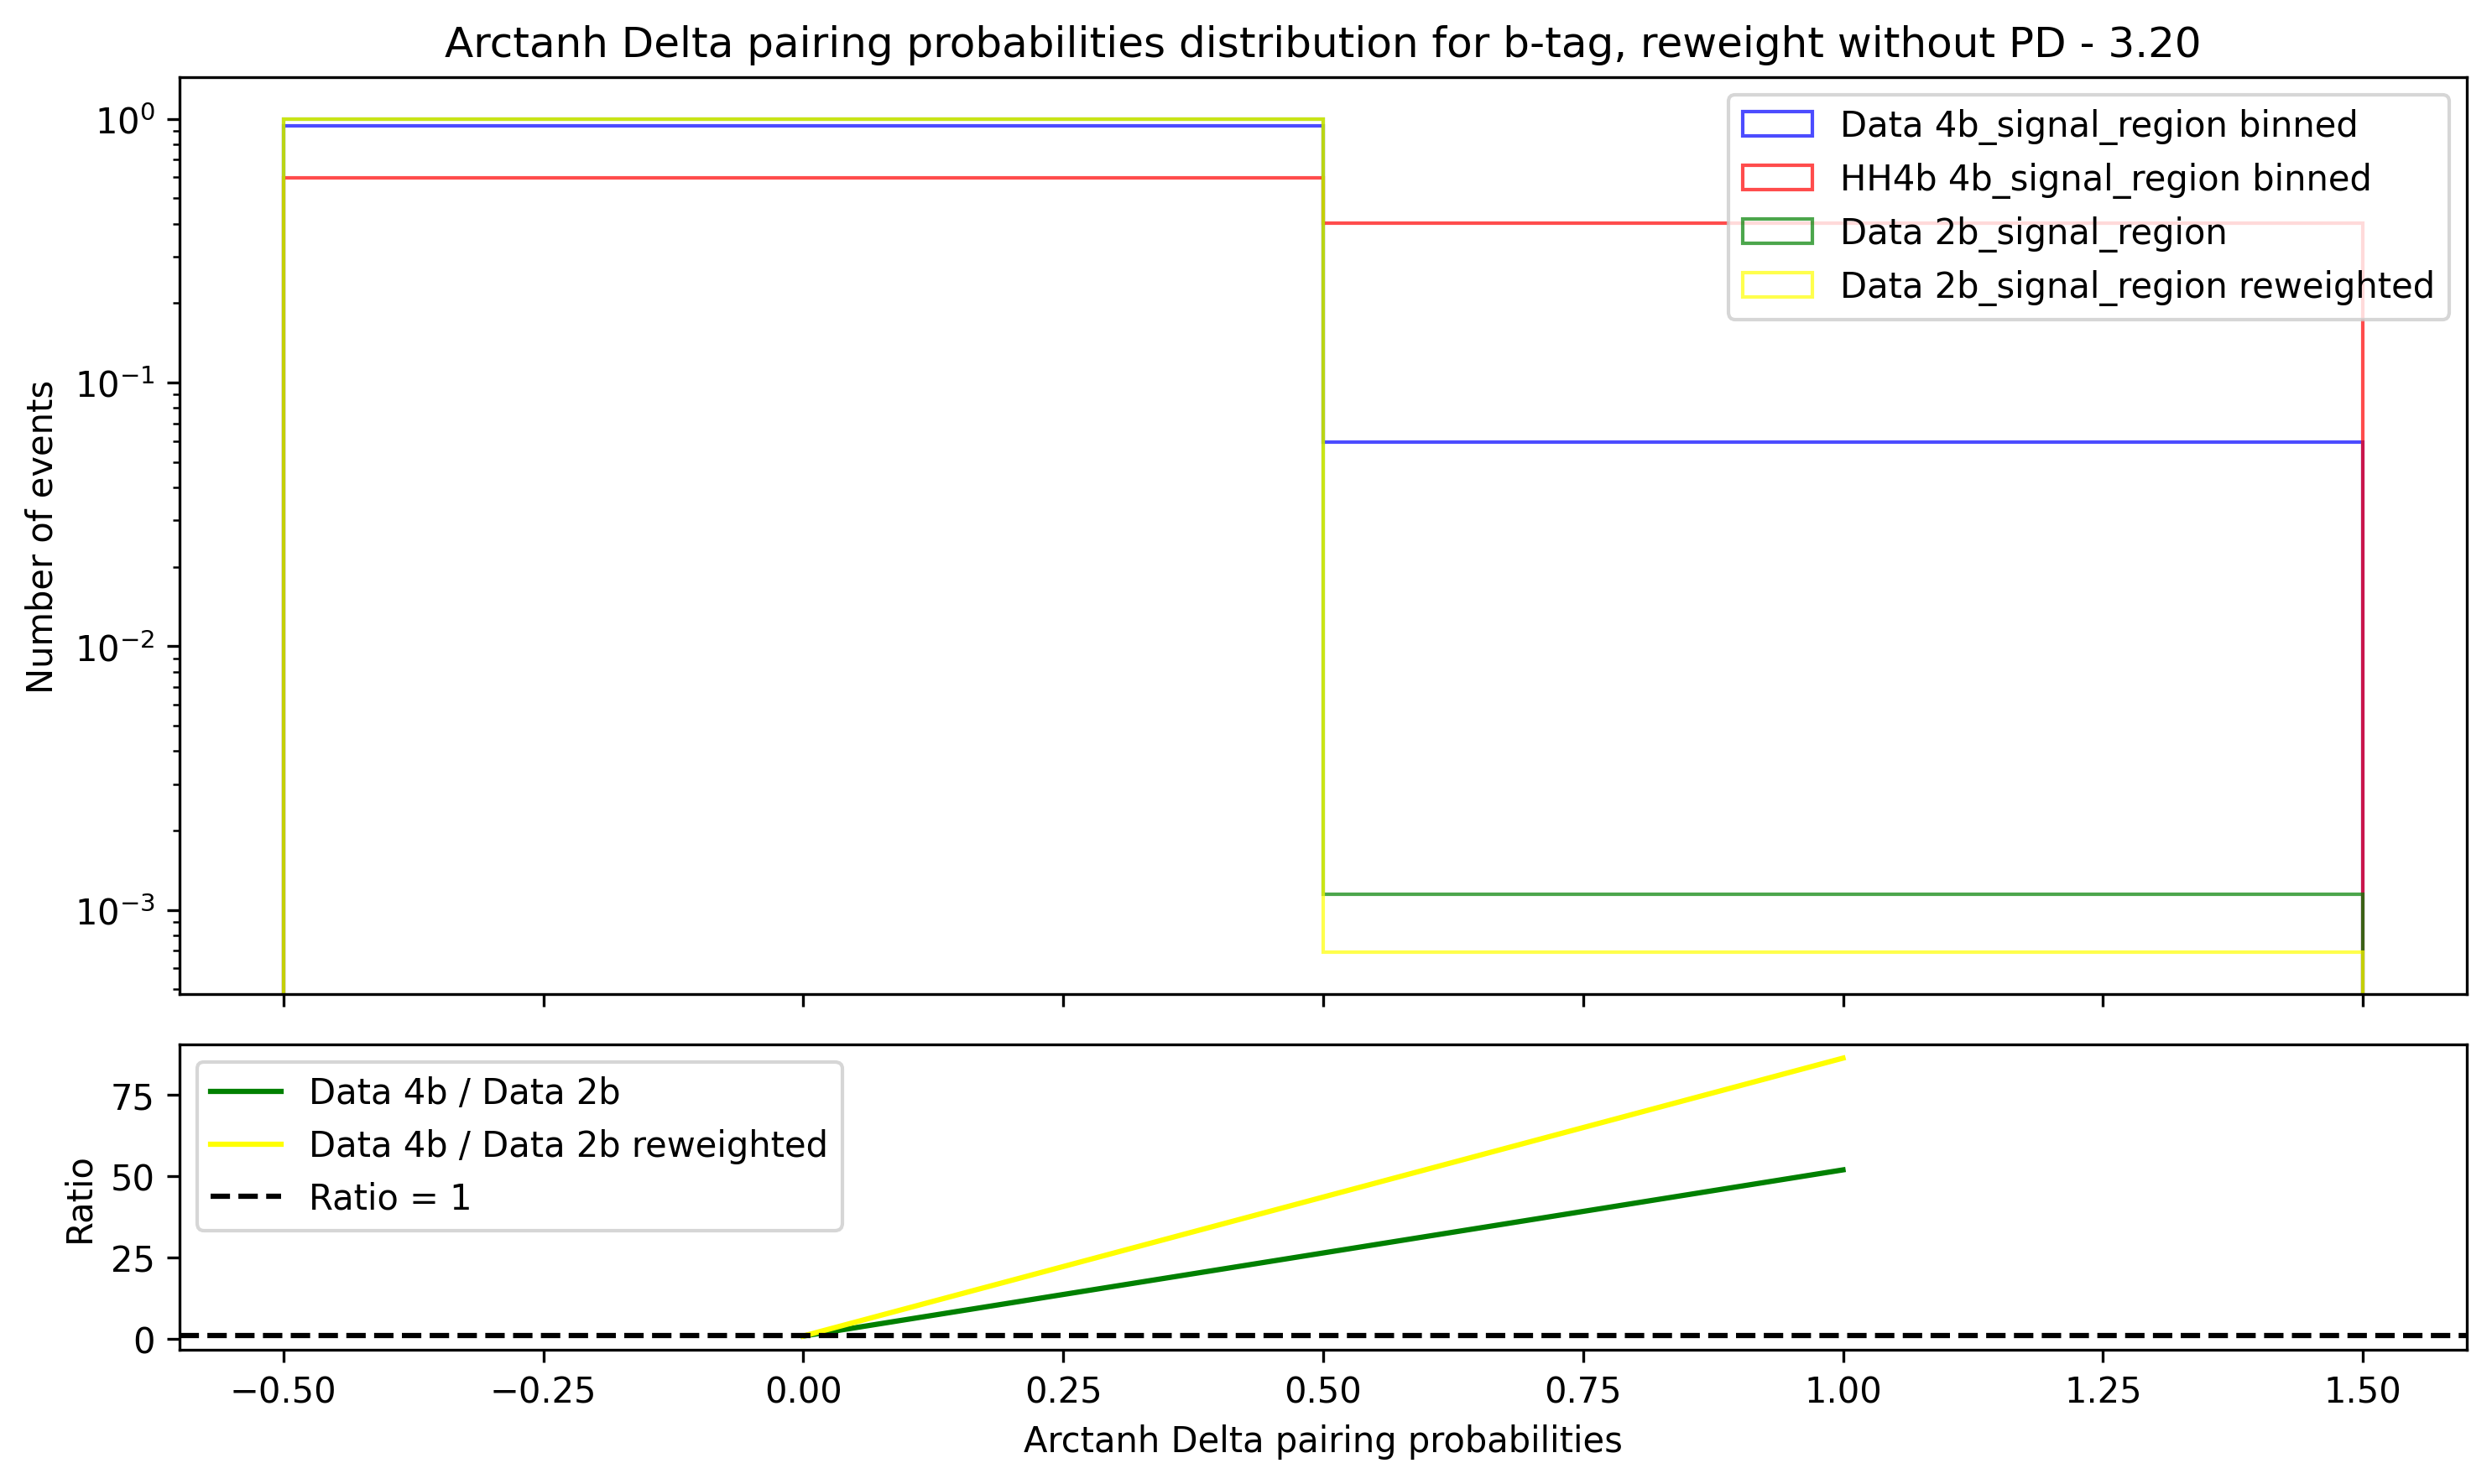

Data: DATA_JetMET_JMENano_G_skimmed DATA_JetMET_JMENano_G_2022_postEE_EraG
MC: GluGlutoHHto4B_spanet GluGlutoHHto4B_spanet_kl-1p00_kt-1p00_c2-0p00_2022_postEE
17128


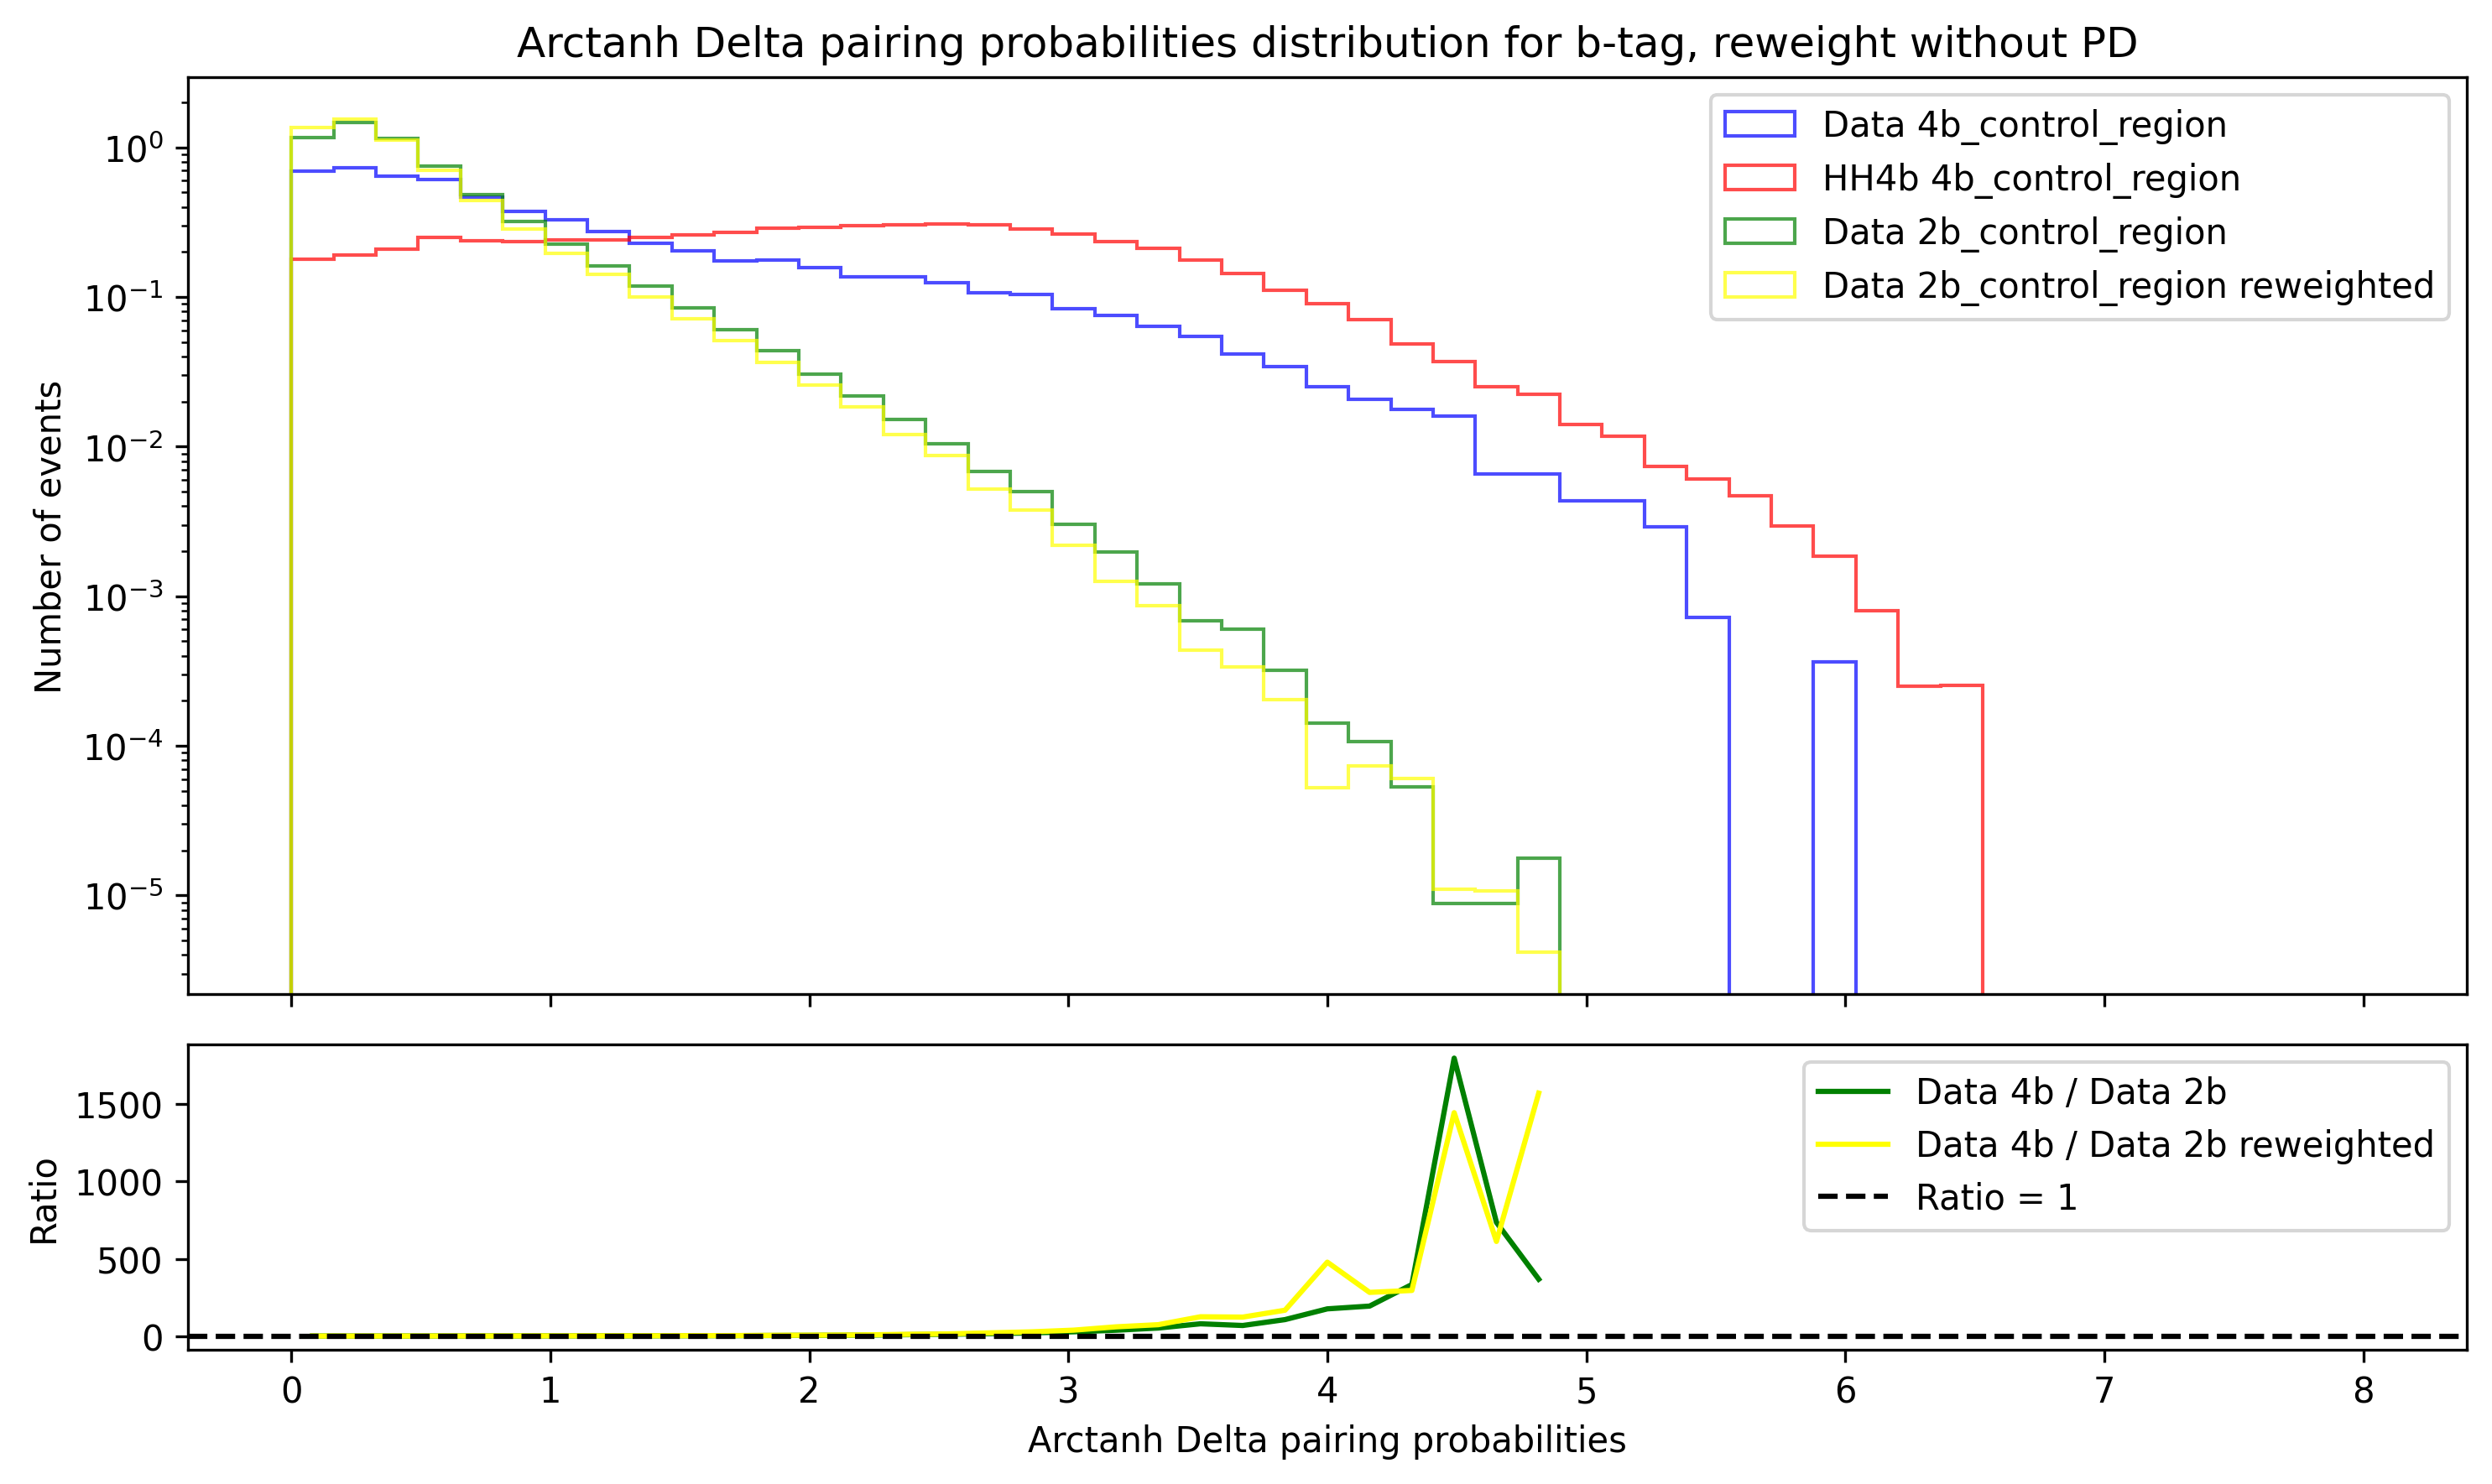

17128


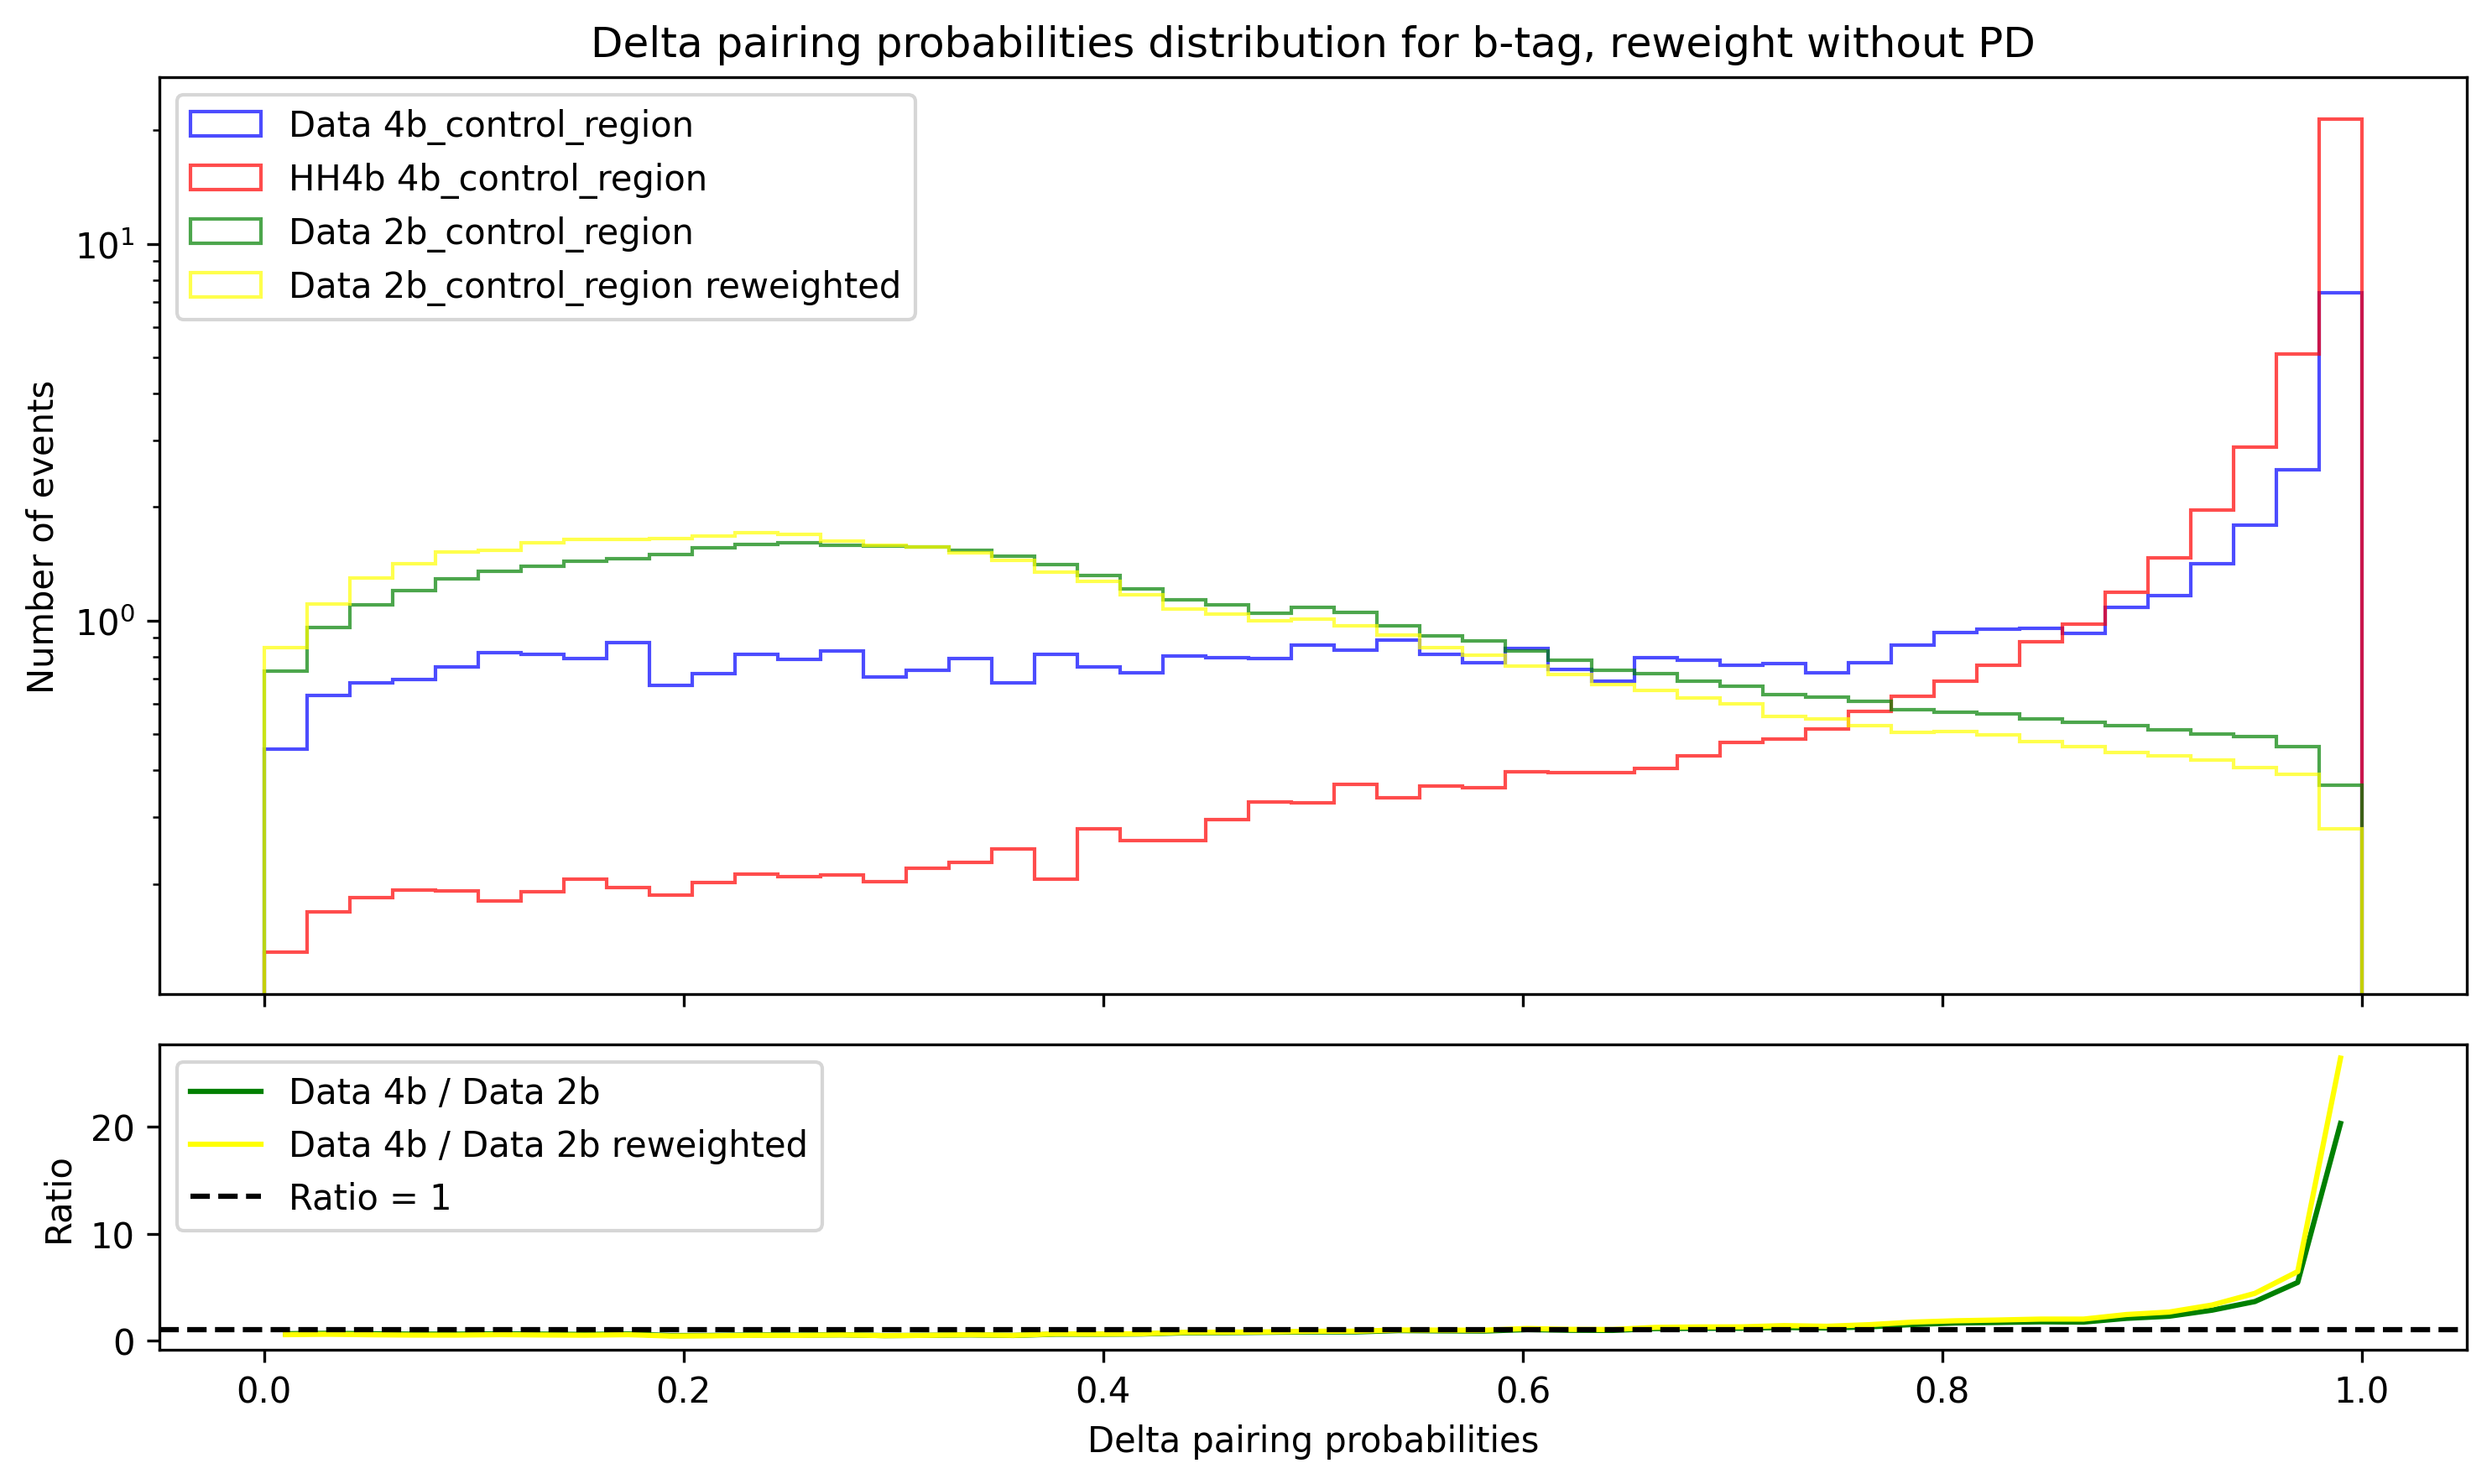

17128


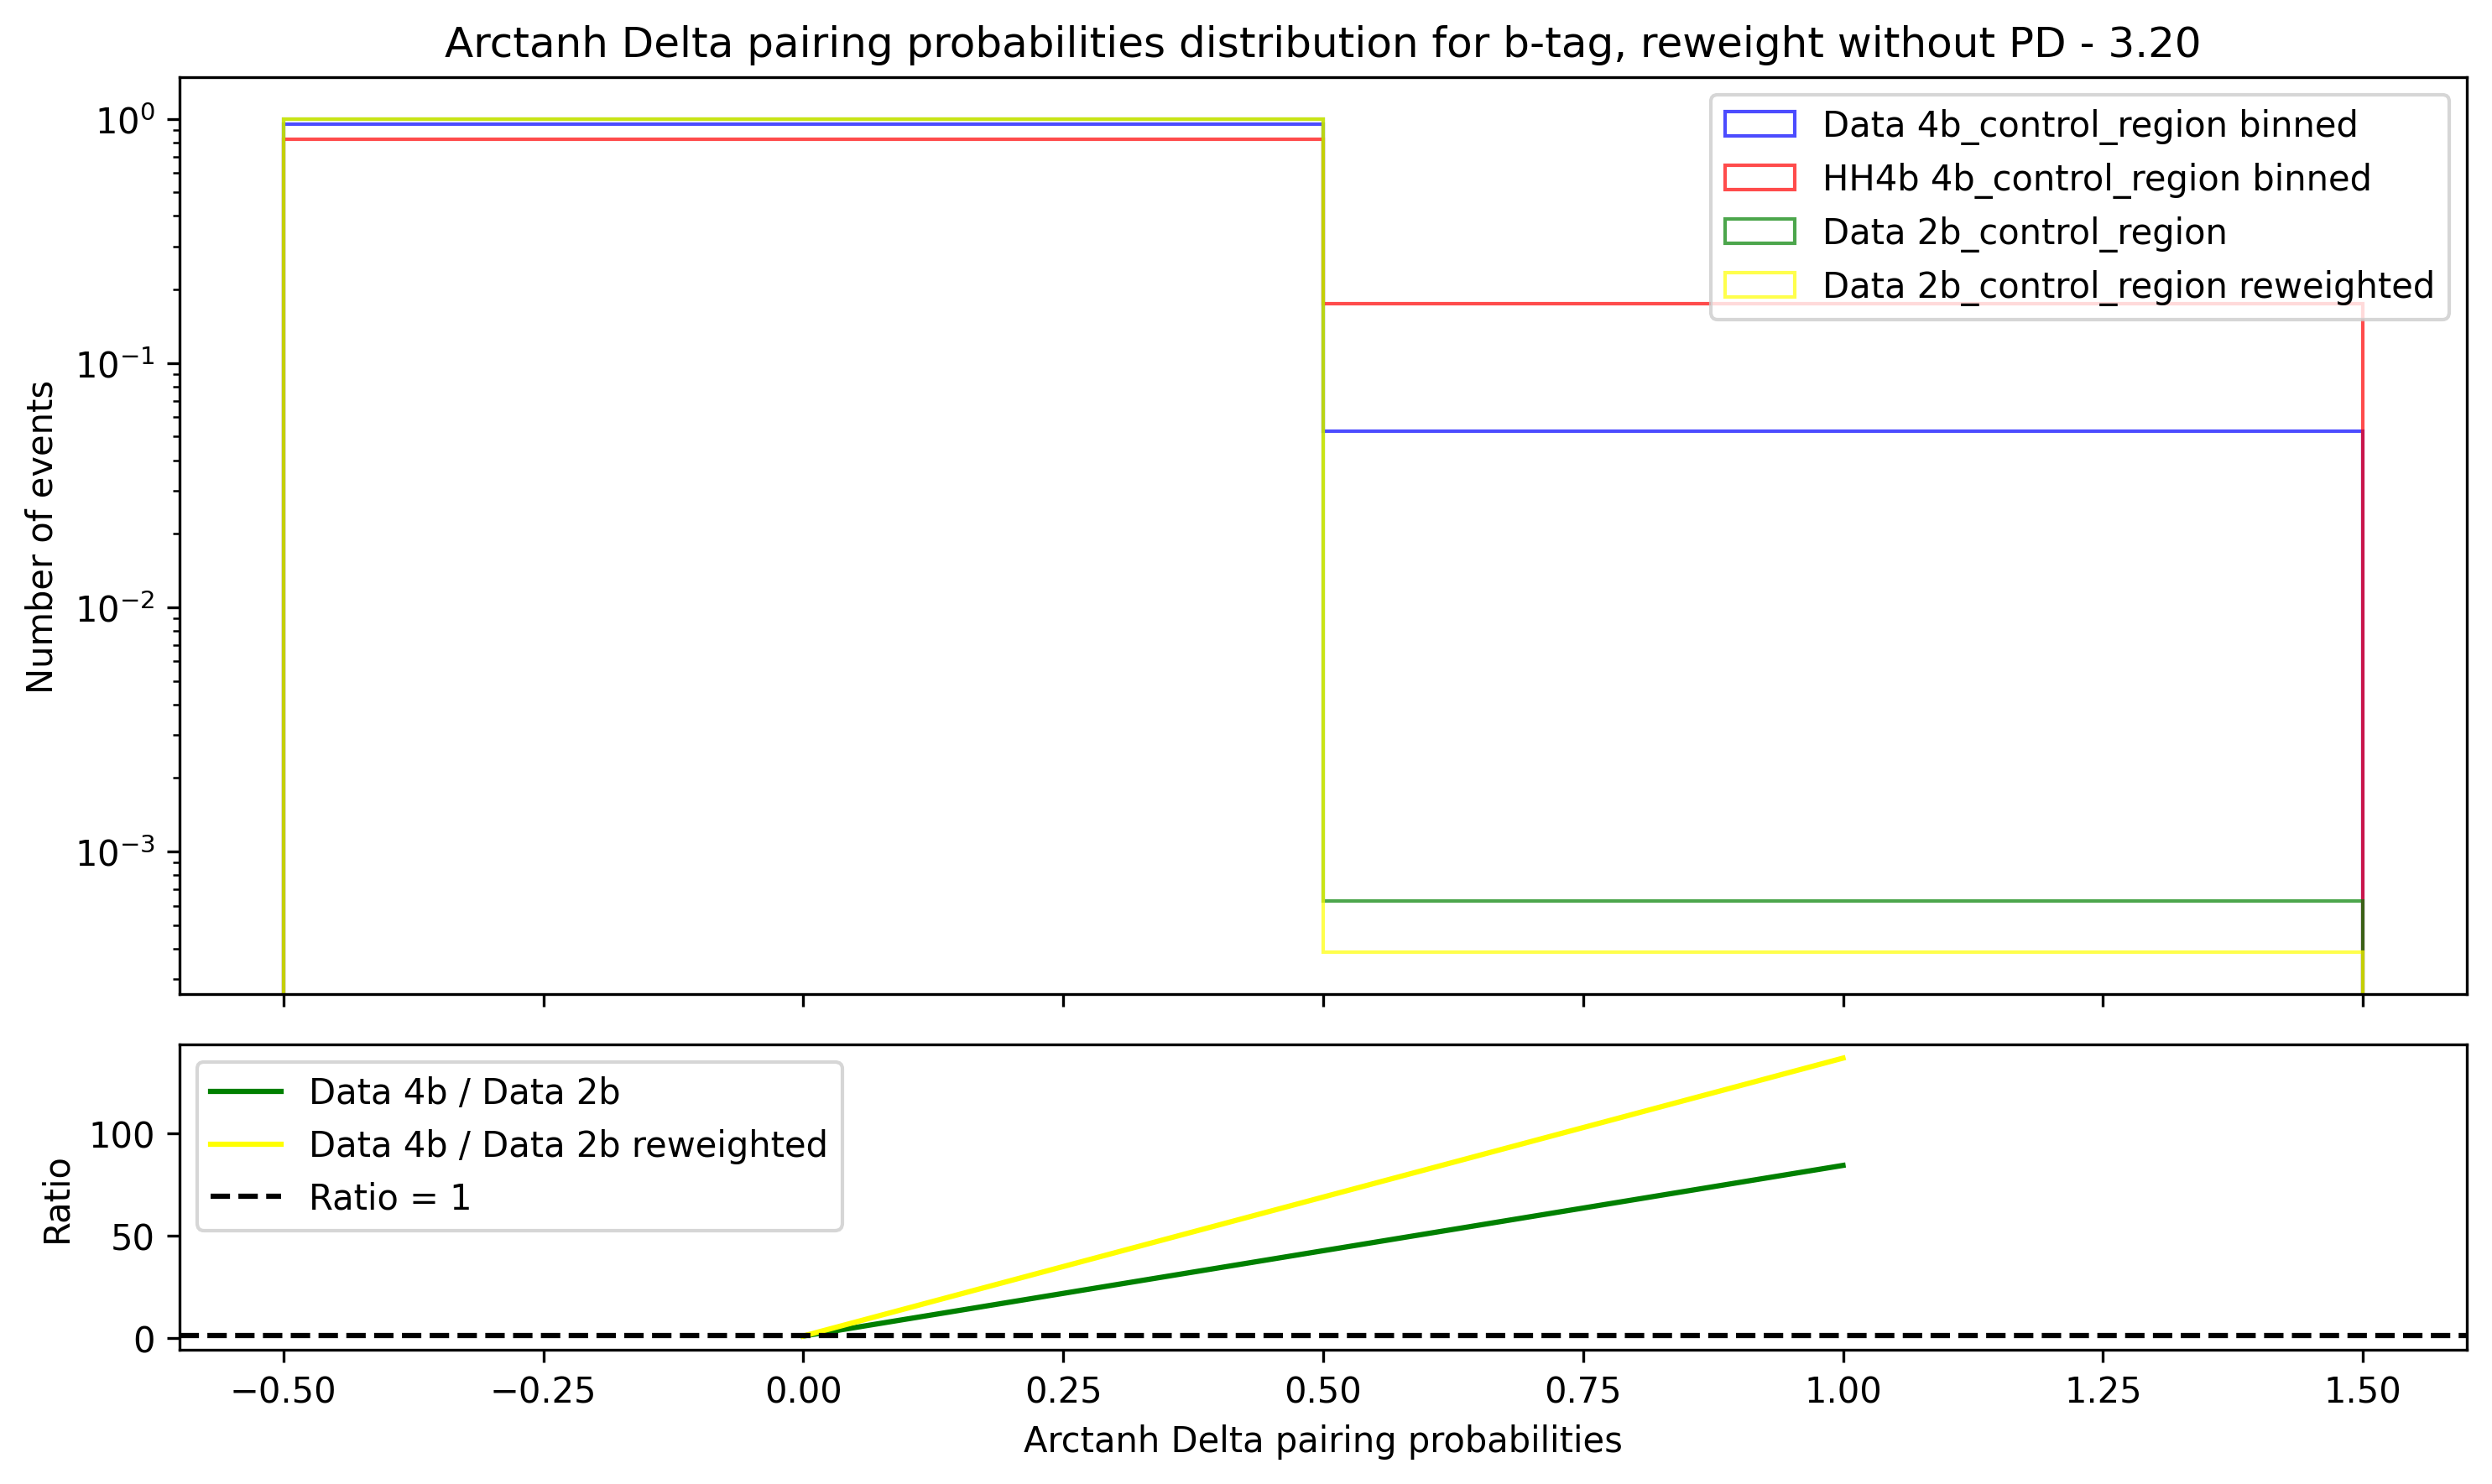

In [44]:
input_data = ["/work/tharte/datasets/sig_bkg_classifier/spanet_ptflat_inclusive_b_trained_btag/output_DATA_JetMET_JMENano_G_2022_postEE_EraG.coffea"]
input_mc = ["/work/tharte/datasets/sig_bkg_classifier/spanet_ptflat_inclusive_b_trained_btag/output_GluGlutoHHto4B_spanet_kl-1p00_kt-1p00_c2-0p00_2022_postEE.coffea"]

title = "b-tag, reweight without PD"

for region in ["signal", "control"]:
    category_4 = f"4b_{region}_region"
    category_2 = f"2b_{region}_region_postW"
    
    adp_d, adp_m, adp_d2, weights_m, weights_d2 = get_cols(input_data, input_mc, category_4, category_2)
    plot_distribution(adp_d, adp_m, adp_d2, weights_m, weights_d2, title, category_4, category_2,np.linspace(0, 8, 50))
    plot_distribution(adp_d, adp_m, adp_d2, weights_m, weights_d2, title, category_4, category_2,np.linspace(0, 1, 50), tanh=True)
    
    arctanh_delta_prob_bin_edges=[-0.2, edge, 20]
    bin_adp_d=np.digitize(adp_d, arctanh_delta_prob_bin_edges)-1
    bin_adp_m=np.digitize(adp_m, arctanh_delta_prob_bin_edges)-1
    bin_adp_d2=np.digitize(adp_d2, arctanh_delta_prob_bin_edges)-1
    plot_distribution(
        bin_adp_d, bin_adp_m, bin_adp_d2, weights_m, weights_d2, f"{title} - {edge:.2f}", category_4 + " binned", category_2 + " binned", [-0.5, 0.5, 1.5]
    )

# compare prob diff between two models

In [47]:
for input_data, input_mc, title in zip(
    [
        # "/work/mmalucch/out_hh4b/SigBkg/out_2022postEE_ggFSPANetDataset_SPANETptVary0p3_1p7_Morphing_DNN_AN_1e-3_e20drop75_minDelta1em5_SPANet_only2022postEE_noEarlyStopping_20folds_DeltaProbabilityMorphing_SigBkg_DNN_ptFlatSPANet_class_weights_e5drop75_postEE_DeltaProbability/output_DATA_JetMET_JMENano_G_2022_postEE_EraG.coffea",
        ["/work/tharte/datasets/samples_models_no_reweight/spanet_ptflat_inclusive_b_trained_bratio_ArctanhDeltaProb/output_DATA_JetMET_JMENano_E_2022_postEE_EraE.coffea", "/work/tharte/datasets/samples_models_no_reweight/spanet_ptflat_inclusive_b_trained_bratio_ArctanhDeltaProb/output_DATA_JetMET_JMENano_F_2022_postEE_EraF.coffea", "/work/tharte/datasets/samples_models_no_reweight/spanet_ptflat_inclusive_b_trained_bratio_ArctanhDeltaProb/output_DATA_JetMET_JMENano_G_2022_postEE_EraG.coffea"]
    ],
    [
        # "/work/mmalucch/out_hh4b/SigBkg/out_2022postEE_ggFSPANetDataset_SPANETptVary0p3_1p7_Morphing_DNN_AN_1e-3_e20drop75_minDelta1em5_SPANet_only2022postEE_noEarlyStopping_20folds_DeltaProbabilityMorphing_SigBkg_DNN_ptFlatSPANet_class_weights_e5drop75_postEE_DeltaProbability/output_GluGlutoHHto4B_spanet_kl-1p00_kt-1p00_c2-0p00_2022_postEE.coffea",
        "/work/tharte/datasets/samples_models_no_reweight/spanet_ptflat_inclusive_b_trained_bratio_ArctanhDeltaProb/output_GluGlutoHHto4B_spanet_kl-1p00_kt-1p00_c2-0p00_2022_postEE.coffea",
    ],
    [
        # "pt flat spanet", 
        "btag ratio spanet"
        ],
):
    for edge in np.linspace(3.2, 3.2, 1):
        for region in ["signal", "control"]:
            category_4 = f"4b_{region}_region"
            category_2 = f"2b_{region}_region_preW"
            
            adp_d, adp_m, adp_d2 = get_cols(input_data, input_mc, category_4, category_2)
            plot_distribution(adp_d, adp_m, adp_d2, title, category_4, category_2,np.linspace(0, 8, 50))
            plot_distribution(adp_d, adp_m, adp_d2, title, category_4, category_2,np.linspace(0, 1, 50), tanh=True)
            
            arctanh_delta_prob_bin_edges=[-0.2, edge, 20]
            bin_adp_d=np.digitize(adp_d, arctanh_delta_prob_bin_edges)-1
            bin_adp_m=np.digitize(adp_m, arctanh_delta_prob_bin_edges)-1
            bin_adp_d2=np.digitize(adp_d2, arctanh_delta_prob_bin_edges)-1
            plot_distribution(
                bin_adp_d, bin_adp_m, bin_adp_d2, f"{title} - {edge:.2f}", category_4 + " binned", category_2 + " binned", [-0.5, 0.5, 1.5]
            )
        

IsADirectoryError: [Errno 21] Is a directory: '/'

# Further commands not currently used

In [60]:
# for 10 values of the distribution,
# compute the s v b of mc/data of the distribution when we have 2 bins (1 above and 1 below)
N_step=100
plt.figure(figsize=(10, 6))
max_sig=0
for i in range(N_step):
    # get the values of the distribution
    val = np.linspace(-1, 10, N_step)[i]
    # get the number of events above and below the value
    n_above_d = np.sum(adp_d > val)
    n_below_d = np.sum(adp_d < val)
    n_above_m = np.sum(weights_m[adp_m > val])
    n_below_m = np.sum(weights_m[adp_m < val])

    # compute the s v b
    s = np.array([n_below_m, n_above_m])
    b = np.array([n_below_d, n_above_d])
    
    # not divide by zero
    svb_array = np.zeros(2)
    with np.errstate(divide='ignore', invalid='ignore'):
        svb_array = np.divide(s, np.sqrt(b), out=np.zeros_like(s), where=b != 0)
    # sum in quadrature
    svb = float(np.sqrt(np.sum(svb_array**2)))
    # print(svb, type(svb))

    # print(f"Value: {val:.3f} ,  S/sqrt(B): {svb:.3f}")
    if svb > max_sig:
        max_sig = svb
        max_val = val
    # plot the histogram of the distribution with the value
    # plt.hist(adp_d, bins=[-1, val, 10], histtype='step', label='Data', color='blue', alpha=0.7, density=True)
    # plt.hist(adp_m, bins=[-1, val, 10], histtype='step', label='MC', color='red', alpha=0.7, density=True)
    # plt.hist(adp_d2, bins=[-1, val, 10], histtype='step', label='Data 2b', color='green', alpha=0.7, density=True)
    # plt.xlabel('Arctanh Delta pairing probabilities')
    # plt.ylabel('Number of events')
    # plt.title('Arctanh Delta pairing probabilities distribution')
    # # log scale
    # plt.yscale('log')
    # plt.legend()
    # plt.grid()
    # plt.tight_layout()
    # plt.show()


print(f"Max S/sqrt(B): {max_sig:.3f} at value: {max_val:.3f}")

IndexError: boolean index did not match indexed array along dimension 0; dimension is 168655 but corresponding boolean dimension is 169062

<Figure size 3000x1800 with 0 Axes>

In [4]:
if False:
    edges, best_score = optimize_bin_edges(2, adp_m, weights_m, adp_d, n_scan=1000)
    print("Optimal bin edges:", edges, "with score:", best_score)

    edges, best_score = optimize_bin_edges(2, adp_m, np.ones_like(adp_m), adp_d, n_scan=1000)
    print("Optimal bin edges:", edges, "with score:", best_score)




In [ ]:
input_data = "/work/mmalucch/out_hh4b/SigBkg/out_2022postEE_ggFSPANetDataset_SPANETptVary0p3_1p7_Morphing_DNN_AN_1e-3_e20drop75_minDelta1em5_SPANet_only2022postEE_noEarlyStopping_20folds_DeltaProbabilityMorphing_SigBkg_DNN_ptFlatSPANet_class_weights_e5drop75_postEE_DeltaProbability/output_DATA_JetMET_JMENano_G_2022_postEE_EraG.coffea"
input_mc = "/work/mmalucch/out_hh4b/SigBkg/out_2022postEE_ggFSPANetDataset_SPANETptVary0p3_1p7_Morphing_DNN_AN_1e-3_e20drop75_minDelta1em5_SPANet_only2022postEE_noEarlyStopping_20folds_DeltaProbabilityMorphing_SigBkg_DNN_ptFlatSPANet_class_weights_e5drop75_postEE_DeltaProbability/output_GluGlutoHHto4B_spanet_kl-1p00_kt-1p00_c2-0p00_2022_postEE.coffea"


o_d = load(input_data)
sample_d=list(o_d["columns"].keys())[0]
dataset_d=list(o_d["columns"][sample_d].keys())[0]

o_m = load(input_mc)
sample_m=list(o_m["columns"].keys())[0]
dataset_m=list(o_m["columns"][sample_m].keys())[0]

category_4='4b_signal_region'
# category_4='4b_control_region'

print(f"Data: {sample_d} {dataset_d}")
print(f"MC: {sample_m} {dataset_m}")
col_d = o_d["columns"][sample_d][dataset_d][category_4]
col_m = o_m["columns"][sample_m][dataset_m][category_4]

category_2='2b_signal_region_postW'
# category_2='2b_control_region_postW'
col_d2 = o_d["columns"][sample_d][dataset_d][category_2]




In [3]:
adp_d=col_d["events_Arctanh_Delta_pairing_probabilities"].value
adp_m=col_m["events_Arctanh_Delta_pairing_probabilities"].value
weights_m=col_m["weight"].value
adp_d2=col_d2["events_Arctanh_Delta_pairing_probabilities"].value
weights_d2=col_d2["weight"].value

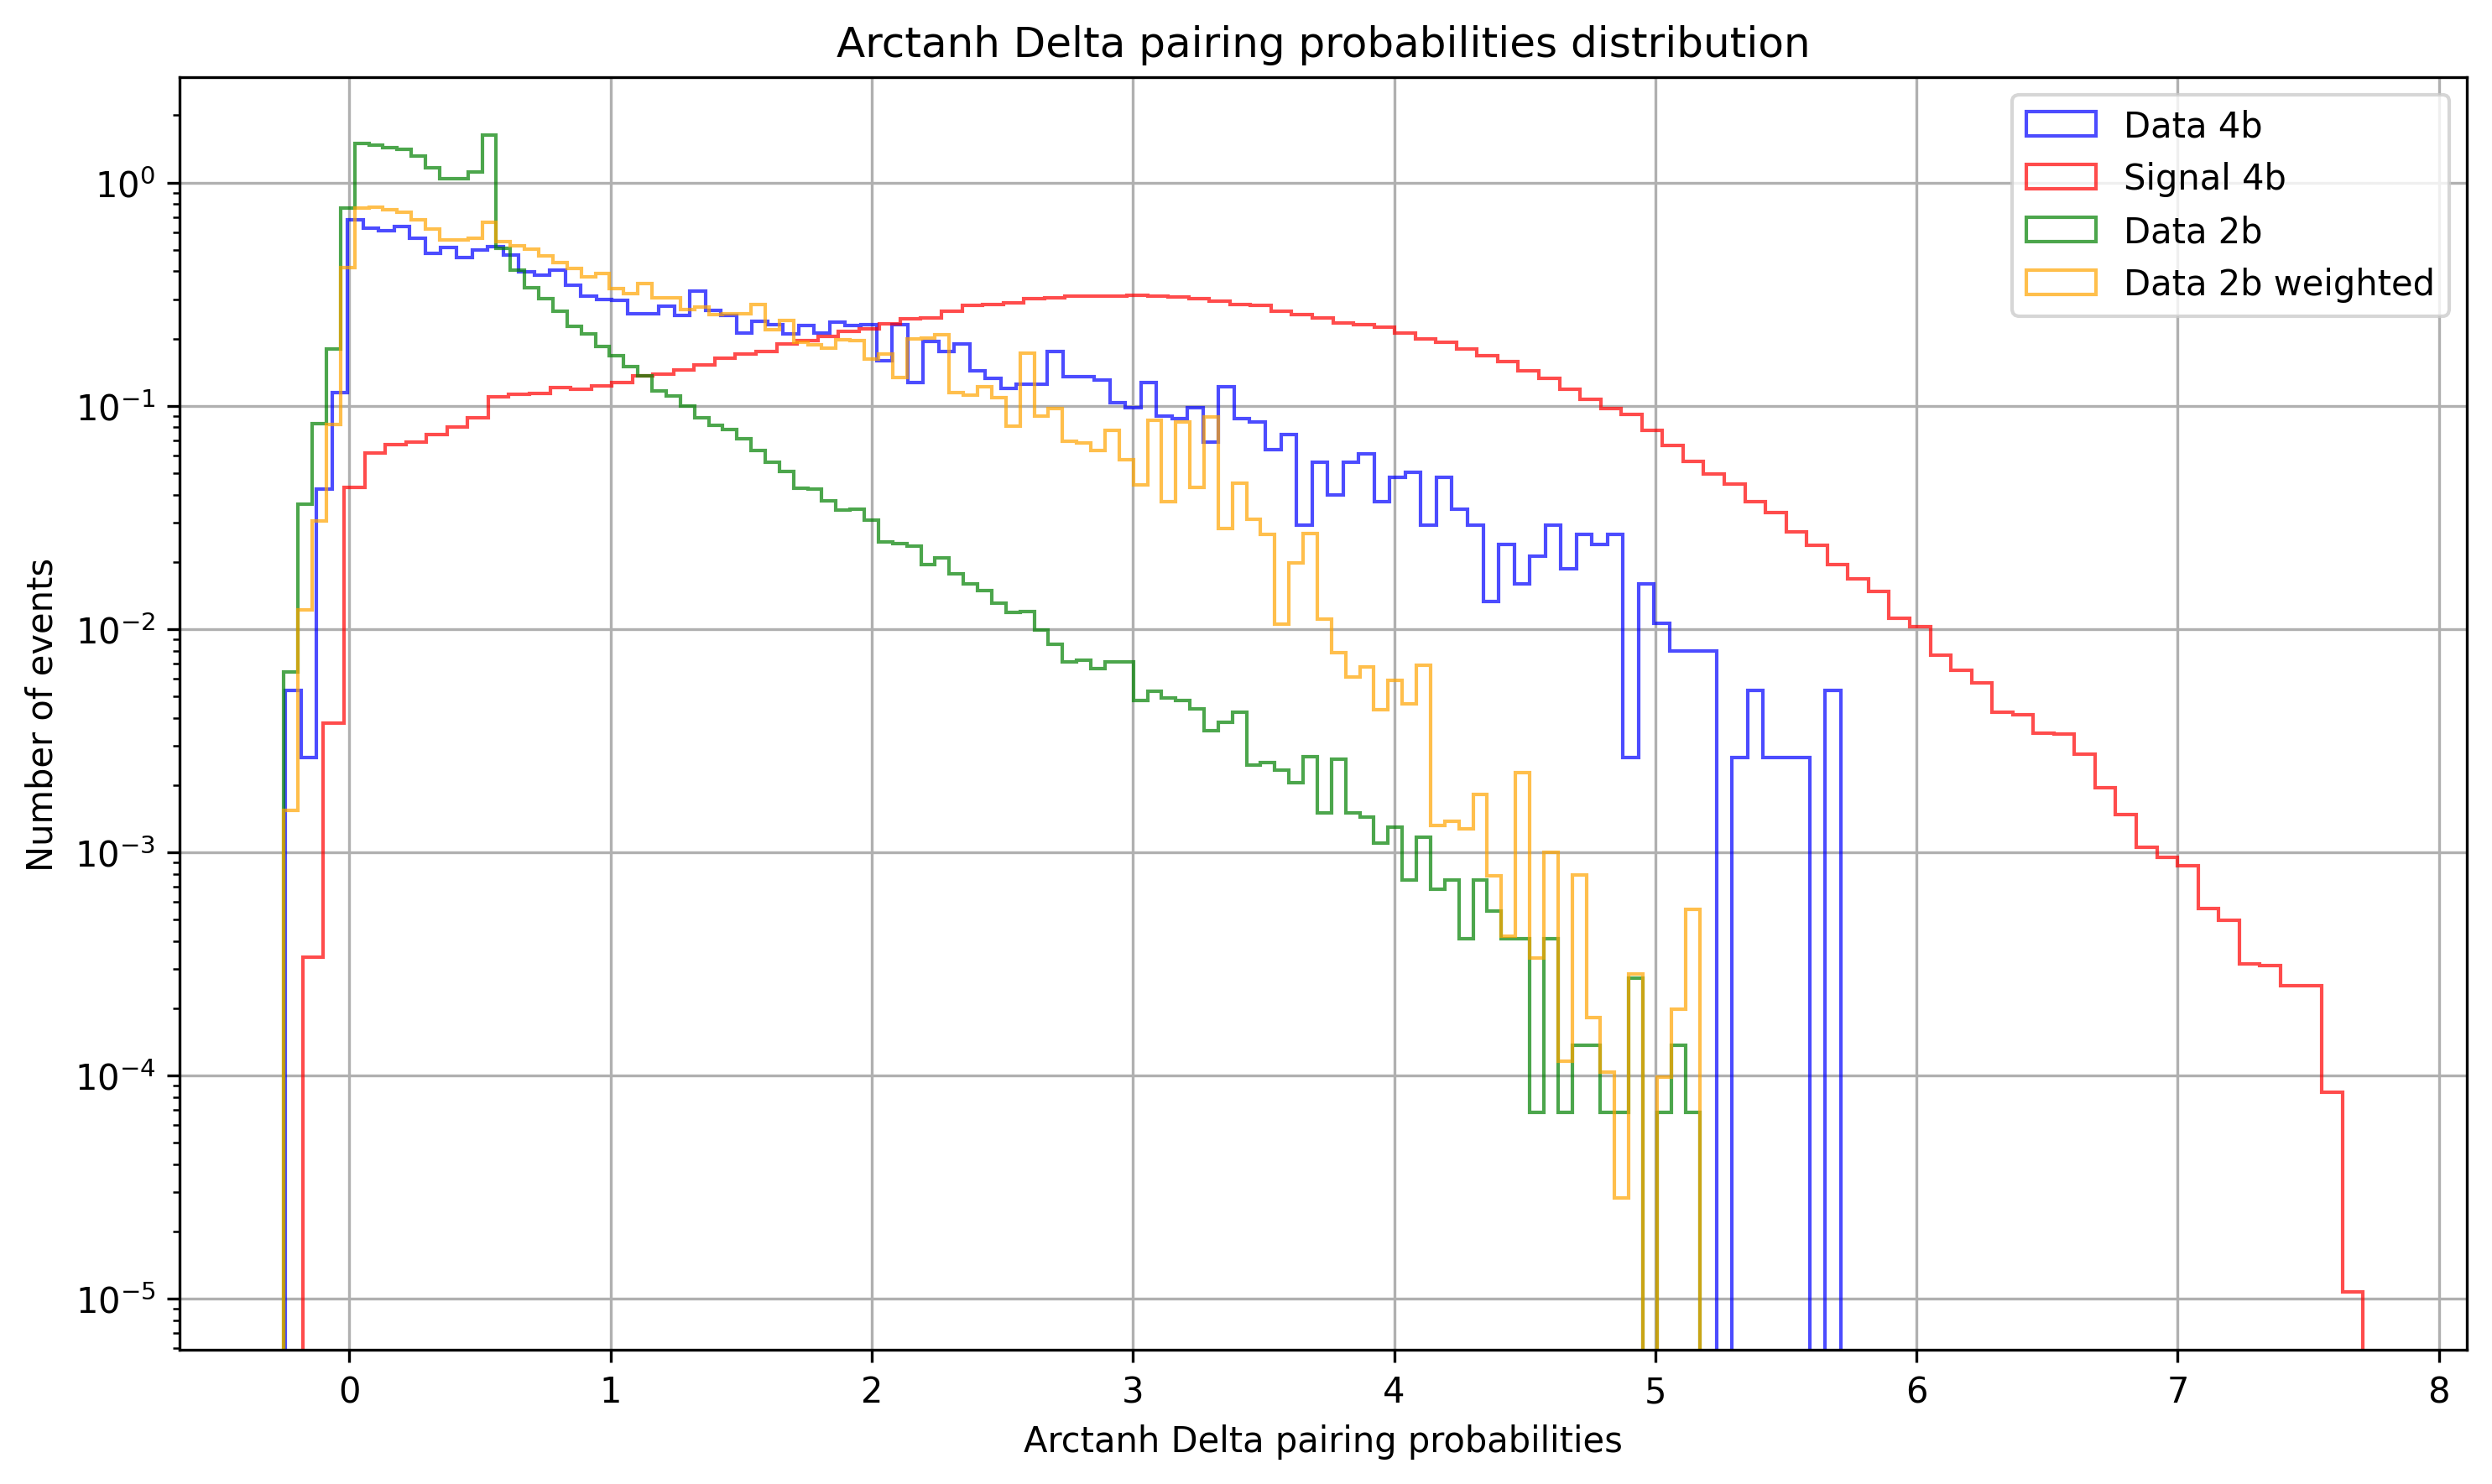

Data 2b histogram: [6.43265963e-03 3.62692511e-02 8.30086822e-02 1.79087981e-01
 7.71166397e-01 1.50195759e+00 1.47362652e+00 1.43831532e+00
 1.40683635e+00 1.31452084e+00 1.16650123e+00 1.04058534e+00
 1.03887453e+00 1.11469779e+00 1.63156884e+00 5.07495785e-01
 4.05873450e-01 3.37783063e-01 3.02950895e-01 2.64628668e-01
 2.27332929e-01 2.09951061e-01 1.84699450e-01 1.66906988e-01
 1.49114525e-01 1.36454503e-01 1.16745929e-01 1.10655432e-01
 9.98430893e-02 8.83464211e-02 8.19137614e-02 7.80815387e-02
 7.12382838e-02 6.32316755e-02 5.57725276e-02 5.06400864e-02
 4.28387758e-02 4.22228829e-02 3.73641719e-02 3.40794095e-02
 3.42847072e-02 3.06577821e-02 2.46357177e-02 2.40198248e-02
 2.35407969e-02 1.93664114e-02 2.08034950e-02 1.76555977e-02
 1.58763514e-02 1.49182957e-02 1.30706169e-02 1.18388310e-02
 1.19756961e-02 9.85428709e-03 8.55406865e-03 7.11698512e-03
 7.25385022e-03 6.63795728e-03 7.11698512e-03 7.11698512e-03
 4.79027845e-03 5.26930629e-03 4.92714354e-03 4.79027845e-03
 4.37

In [4]:
# plot the columns histograms
plt.figure(figsize=(10, 6))
plt.hist(adp_d, bins=100, histtype='step', label='Data 4b', color='blue', alpha=0.7, density=True)
plt.hist(adp_m, bins=100, weights=weights_m, histtype='step', label='Signal 4b', color='red', alpha=0.7, density=True)
plt.hist(adp_d2, bins=100, histtype='step', label='Data 2b', color='green', alpha=0.7, density=True)
plt.hist(adp_d2, bins=100, weights=weights_d2, histtype='step', label='Data 2b weighted', color='orange', alpha=0.7, density=True)
plt.xlabel('Arctanh Delta pairing probabilities')
plt.ylabel('Number of events')
plt.title('Arctanh Delta pairing probabilities distribution')
# log scale
plt.yscale('log')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


# get the histogram
hist_d, edges_d = np.histogram(adp_d, bins=100, density=True)
hist_m, edges_m = np.histogram(adp_m, bins=100, weights=weights_m, density=True)
hist_d2, edges_d2 = np.histogram(adp_d2, bins=100, density=True)
# print(f"Data 4b histogram: {hist_d} {edges_d}")
# print(f"Signal 4b histogram: {hist_m} {edges_m}")
print(f"Data 2b histogram: {hist_d2} {edges_d2}")
for i in range(len(hist_d2)):
    print(f"Data 2b histogram bin {i}: {edges_d2[i]} - {edges_d2[i+1]}: {hist_d2[i]}")


